This Python notebook is focused on the usage of Neural Networks and Support Vector Regression for the task of WN the specific application, Peak Electricity Demand, as it relates to observed weather conditions (as is described in the Thesis: "ML-ASSISTED DATA ANALYTICS AND WEATHER NORMALIZATION TO AID IN COMMERCIAL BUILDING ENERGY AUDITS").

# Libraries & Packages

In [ ]:
pip install tensorflow

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main.py", line 78, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/__init__.py", line 114, in create_command
    module = importlib.import_module(module_path)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlo

KeyboardInterrupt: 

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_recall_fscore_support
from scipy.interpolate import griddata
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
# Import and organize data:

# Importing MONTHLY file from GitHub for Monthly Data
url_monthly = 'https://raw.githubusercontent.com/gvanwalsen/adv-weather-norm/main/LV_B1_monthlyrawdata.csv'
df_monthly = pd.read_csv(url_monthly)

# Importing DAILY file from GitHub for Daily SVR attempt
url_daily = 'https://raw.githubusercontent.com/gvanwalsen/adv-weather-norm/main/LV_B1_dailyrawdata.csv'
df_daily = pd.read_csv(url_daily)

# Importing HOURLY file from GitHub for Daily SVR attempt
url_hourly = 'https://raw.githubusercontent.com/gvanwalsen/adv-weather-norm/main/LV_B1_hourlyrawdata.csv'
df_hourly = pd.read_csv(url_hourly)

# Light Data Re-arrangement
b1_daily_arr = np.array(df_daily)
b1_daily_raw = b1_daily_arr[0:1461,0:32]
# print(b1_daily_raw)

b1_hourly_arr = np.array(df_hourly)
b1_hourly_raw = b1_hourly_arr[0:36064,0:25]
# print(b1_hourly_raw)

b1_monthly_arr = np.array(df_monthly)
b1_monthly_raw = b1_monthly_arr[0:72,0:32]
# print(b1_monthly_raw)

b1_daily_df = pd.DataFrame({ 'datetime': b1_daily_raw[:,0],
                                'Year': b1_daily_raw[:,1],
                                'Month': b1_daily_raw[:,2],
                                'EnergyUse': b1_daily_raw[:,6],
                                'Temp': b1_daily_raw[:,9],
                                'feelslike': b1_daily_raw[:,12],
                                'RelHum': b1_daily_raw[:,13],
                                'Humidity': b1_daily_raw[:,14],
                                'Precip': b1_daily_raw[:,15],
                                'Snow': b1_daily_raw[:,19],
                                'WindGust': b1_daily_raw[:,21],
                                'WindSpeed': b1_daily_raw[:,22],
                                'WindDir': b1_daily_raw[:,23],
                                'SeaLevelPressure': b1_daily_raw[:,24],
                                'CloudCover': b1_daily_raw[:,25],
                                'Visibility': b1_daily_raw[:,26],
                                'SolarRadiation': b1_daily_raw[:,27],
                                'SolarEnergy': b1_daily_raw[:,28],
                                'UVIndex': b1_daily_raw[:,29]})

b1_hourly_df = pd.DataFrame({ 'Year': b1_hourly_raw[:,0],
                                'Month': b1_hourly_raw[:,1],
                                'Day': b1_hourly_raw[:,2],
                                'Hour': b1_hourly_raw[:,3],
                                'EnergyUse': b1_hourly_raw[:,6],
                                'Temp': b1_hourly_raw[:,7],
                                'feelslike': b1_hourly_raw[:,8],
                                'RelHum': b1_hourly_raw[:,9],
                                'Humidity': b1_hourly_raw[:,10],
                                'Precip': b1_hourly_raw[:,11],
                                'Snow': b1_hourly_raw[:,14],
                                'WindGust': b1_hourly_raw[:,16],
                                'WindSpeed': b1_hourly_raw[:,17],
                                'WindDir': b1_hourly_raw[:,18],
                                'SeaLevelPressure': b1_hourly_raw[:,19],
                                'CloudCover': b1_hourly_raw[:,20],
                                'Visibility': b1_hourly_raw[:,21],
                                'SolarRadiation': b1_hourly_raw[:,22],
                                'SolarEnergy': b1_hourly_raw[:,23],
                                'UVIndex': b1_hourly_raw[:,24]})

b1_monthly_df = pd.DataFrame({ 'Year': b1_monthly_raw[:,0],
                                'Month': b1_monthly_raw[:,1],
                                'EnergyUse': b1_monthly_raw[:,3],
                                'Temp': b1_monthly_raw[:,6],
                                'feelslike': b1_monthly_raw[:,9],
                                'RelHum': b1_monthly_raw[:,10],
                                'Humidity': b1_monthly_raw[:,11],
                                'Precip': b1_monthly_raw[:,12],
                                'Snow': b1_monthly_raw[:,16],
                                'WindGust': b1_monthly_raw[:,18],
                                'WindSpeed': b1_monthly_raw[:,19],
                                'WindDir': b1_monthly_raw[:,20],
                                'SeaLevelPressure': b1_monthly_raw[:,21],
                                'CloudCover': b1_monthly_raw[:,22],
                                'Visibility': b1_monthly_raw[:,23],
                                'SolarRadiation': b1_monthly_raw[:,24],
                                'SolarEnergy': b1_monthly_raw[:,25],
                                'UVIndex': b1_monthly_raw[:,26]})

# Feature Scaling (necessary for data to be scaled down ahead of NN processing)
sc_Xd = StandardScaler()
sc_yd = StandardScaler()

# Building 1, NN (Peak Producing Weather Analysis, Monthly)

In [ ]:
# Use the existing 'datetime' column and rename it to 'timestamp' and keep only EnergyUse
# DO THIS FOR THE ENTIRE DATASET
data_converted_nn_m_yr_PPWA = b1_monthly_df.copy() # Create a copy to avoid modifying the original DataFrame
data_converted_nn_m_yr_PPWA['timestamp'] = data_converted_nn_m_yr_PPWA['Month'].astype(str) + ',' + ' ' + data_converted_nn_m_yr_PPWA['Year'].astype(str)
data_converted_nn_m_yr_PPWA = data_converted_nn_m_yr_PPWA[['timestamp', 'EnergyUse']]

# Drop blank values
data_converted_nn_m_yr_PPWA = data_converted_nn_m_yr_PPWA.dropna()

In [ ]:
# Exclude datetime column
data_tensor_nn_m_yr_PPWA = tf.convert_to_tensor(data_converted_nn_m_yr_PPWA.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# print(data_tensor_nn_d_yr_PPWA)

# Define the autoencoder model
input_dim_nn_m_yr_PPWA = data_converted_nn_m_yr_PPWA.shape[1] - 1
encoding_dim_nn_m_yr_PPWA = 10

input_layer_nn_m_yr_PPWA = Input(shape=(input_dim_nn_m_yr_PPWA,))
encoder_nn_m_yr_PPWA = Dense(encoding_dim_nn_m_yr_PPWA, activation='relu')(input_layer_nn_m_yr_PPWA)
decoder_nn_m_yr_PPWA = Dense(input_dim_nn_m_yr_PPWA, activation='relu')(encoder_nn_m_yr_PPWA)
autoencoder_nn_m_yr_PPWA = Model(inputs=input_layer_nn_m_yr_PPWA, outputs=decoder_nn_m_yr_PPWA)

# Compile and fit the model
autoencoder_nn_m_yr_PPWA.compile(optimizer='adam', loss='mae')
autoencoder_nn_m_yr_PPWA.fit(data_tensor_nn_m_yr_PPWA, data_tensor_nn_m_yr_PPWA, epochs=40,
				batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions_nn_m_yr_PPWA = autoencoder_nn_m_yr_PPWA.predict(data_tensor_nn_m_yr_PPWA)
mae_nn_m_yr_PPWA = tf.reduce_mean(tf.square(data_tensor_nn_m_yr_PPWA - reconstructions_nn_m_yr_PPWA),
					axis=1)
anomaly_scores_nn_m_yr_PPWA = pd.Series(mae_nn_m_yr_PPWA.numpy(), name='anomaly_scores')
anomaly_scores_nn_m_yr_PPWA.index = data_converted_nn_m_yr_PPWA.index

Epoch 1/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 98930.2812 
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 98420.3906
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 100192.1719
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 97480.6719 
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 101724.8438
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 100645.2344
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 99969.1875 
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 102979.6562
Epoch 9/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 101295.8438
Epoch 10/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 101846.4688
Epoch 11/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 97994.2812
Epoch 12/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 100255.0312
Epoch 13/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 98326.1953
Epoch 14/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 99402.7031 
Epoch 15/40
3/3 ━━━━━━━━━━━━━━━━

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [ ]:
threshold_nn_m_yr_PPWA = anomaly_scores_nn_m_yr_PPWA.quantile(0.90)
anomalous_nn_m_yr_PPWA = anomaly_scores_nn_m_yr_PPWA > threshold_nn_m_yr_PPWA
binary_labels_nn_m_yr_PPWA = anomalous_nn_m_yr_PPWA.astype(int)
precision_nn_m_yr_PPWA, recall_nn_m_yr_PPWA, f1_score_nn_m_yr_PPWA, _ = precision_recall_fscore_support(binary_labels_nn_m_yr_PPWA, anomalous_nn_m_yr_PPWA, average='binary')

In [ ]:
test_nn_m_yr_PPWA = data_converted_nn_m_yr_PPWA['EnergyUse'].values
predictions_nn_m_yr_PPWA = anomaly_scores_nn_m_yr_PPWA.values

print("Precision: ", precision_nn_m_yr_PPWA)
print("Recall: ", recall_nn_m_yr_PPWA)
print("F1 Score: ", f1_score_nn_m_yr_PPWA)

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


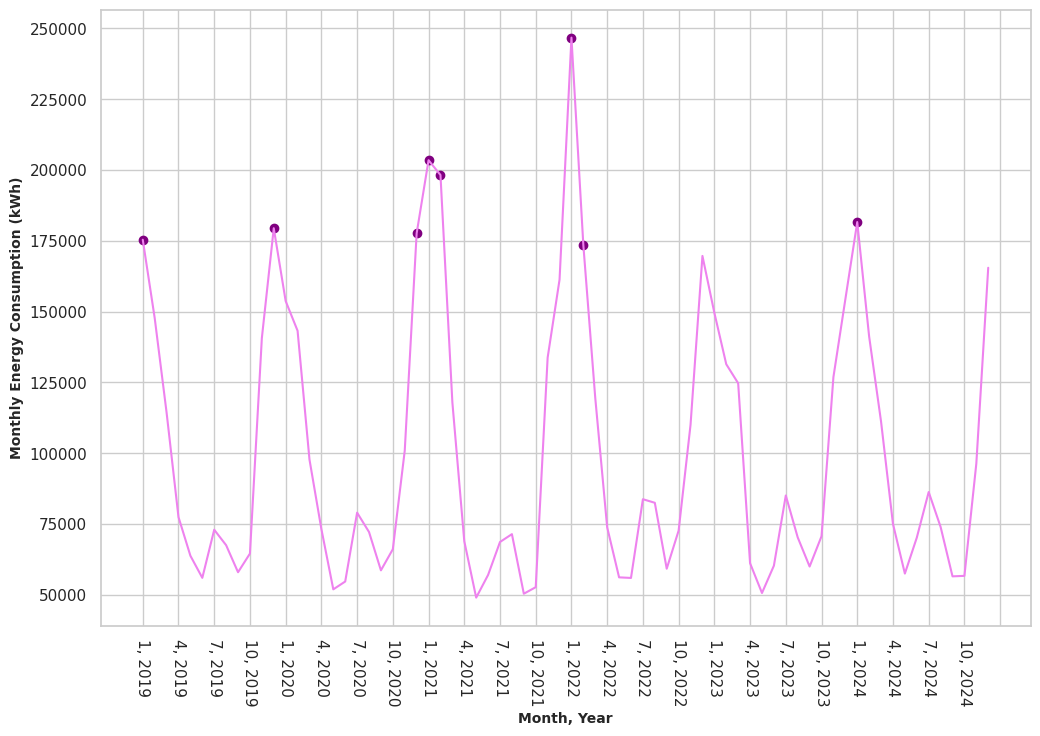

In [ ]:
# Plot the data with anomalies marked in yellow
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(data_converted_nn_m_yr_PPWA['timestamp'], data_converted_nn_m_yr_PPWA['EnergyUse'], color='violet')
plt.scatter(data_converted_nn_m_yr_PPWA['timestamp'][anomalous_nn_m_yr_PPWA], data_converted_nn_m_yr_PPWA['EnergyUse'][anomalous_nn_m_yr_PPWA], marker='o', color='purple')
plt.xlabel('Month, Year', fontweight ='bold', fontsize = 10)
plt.ylabel('Monthly Energy Consumption (kWh)', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 73, 3))
plt.tick_params(axis ='x', rotation = -90)
plt.show()

In [ ]:
# Isolate the anomalous values
anomalous_nn_m_yr_PPWA_true = data_converted_nn_m_yr_PPWA[anomalous_nn_m_yr_PPWA]
# anomalous_nn_d_yr_PPWA_index = anomalous_nn_d_yr_PPWA_true.index # This line is no longer needed

# Directly filter b1_monthly_df using the boolean series anomalous_nn_m_yr_PPWA
# Ensure the index of anomalous_nn_m_yr_PPWA aligns with b1_monthly_df if needed,
# but since both were derived from the same original data and filtered/indexed similarly,
# direct boolean indexing should work if the indices are aligned.
# Given the previous reset_index calls, the indices should now be 0-based and aligned.
anomalous_nn_m_yr_PPWA_weather = b1_monthly_df[anomalous_nn_m_yr_PPWA]

anomalous_nn_m_yr_PPWA_weather = anomalous_nn_m_yr_PPWA_weather[['Year', 'Month', 'EnergyUse', 'Temp', 'RelHum', 'Humidity', 'UVIndex']]
print(anomalous_nn_m_yr_PPWA_weather)

    Year Month EnergyUse       Temp     RelHum   Humidity   UVIndex
0   2019     1    175368  32.396774  19.896774  61.796774  2.709677
11  2019    12    179423  36.758065  28.409677  73.325806  2.032258
23  2020    12    177625  36.525806  27.554839  71.174194  2.483871
24  2021     1    203445  33.290323  22.051613  65.219355  3.032258
25  2021     2    198212       32.1  22.239286       69.1  3.178571
36  2022     1    246721  28.548387  17.222581  64.348387  3.032258
37  2022     2    173370  35.796429  24.017857     65.375  4.607143
60  2024     1    181602  34.422581  25.525806  71.619355  2.677419


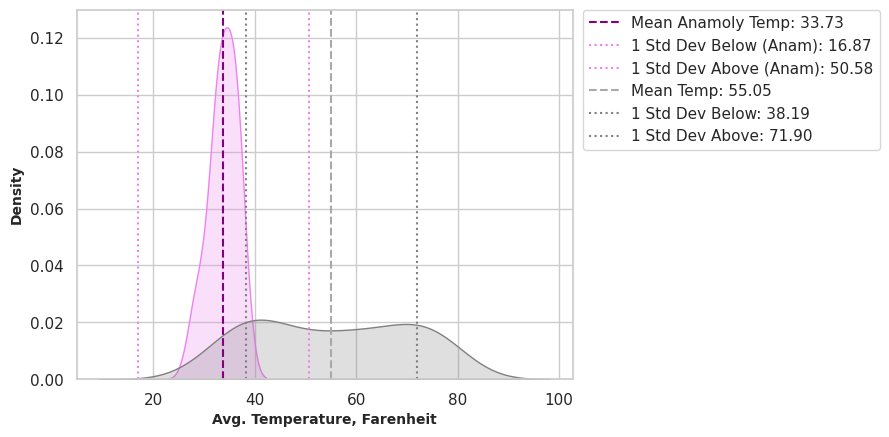

In [ ]:
# Visualize distrubution of anamolous temperatures
anamalous_temp_nn_m_yr_mean = np.mean(anomalous_nn_m_yr_PPWA_weather['Temp'])
anamalous_temp_nn_m_yr_std_dev = np.std(anomalous_nn_m_yr_PPWA_weather['Temp'])

temp_nn_m_yr_mean = np.mean(b1_daily_df['Temp'])
temp_nn_m_yr_std_dev = np.std(b1_daily_df['Temp'])

sns.set(style='whitegrid')
sns.kdeplot(anomalous_nn_m_yr_PPWA_weather['Temp'], fill=True, color="violet")
plt.axvline(anamalous_temp_nn_m_yr_mean, color='purple', linestyle='--', label=f'Mean Anamoly Temp: {anamalous_temp_nn_m_yr_mean:.2f}')
plt.axvline(anamalous_temp_nn_m_yr_mean - temp_nn_m_yr_std_dev, color='violet', linestyle=':', label=f'1 Std Dev Below (Anam): {anamalous_temp_nn_m_yr_mean - temp_nn_m_yr_std_dev:.2f}')
plt.axvline(anamalous_temp_nn_m_yr_mean + temp_nn_m_yr_std_dev, color='violet', linestyle=':', label=f'1 Std Dev Above (Anam): {anamalous_temp_nn_m_yr_mean + temp_nn_m_yr_std_dev:.2f}')

sns.kdeplot(b1_monthly_df['Temp'], fill=True, color="grey")
plt.axvline(temp_nn_m_yr_mean, color='darkgrey', linestyle='--', label=f'Mean Temp: {temp_nn_m_yr_mean:.2f}')
plt.axvline(temp_nn_m_yr_mean - temp_nn_m_yr_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Below: {temp_nn_m_yr_mean - temp_nn_m_yr_std_dev:.2f}')
plt.axvline(temp_nn_m_yr_mean + temp_nn_m_yr_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Above: {temp_nn_m_yr_mean + temp_nn_m_yr_std_dev:.2f}')

plt.xlabel('Avg. Temperature, Farenheit', fontweight ='bold', fontsize = 10)
plt.ylabel('Density', fontweight ='bold', fontsize = 10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# Building 1, NN (Peak Producing Weather Analysis, Daily) Individual Years

In [ ]:
# Start with Daily Data, Analyzing Daily Data Over the Course of a single calendar year
# Seperate Data by Year (DAILY)
b1_daily_2019 = b1_daily_df[(b1_daily_df['Year'] == 2019)]
b1_daily_2020 = b1_daily_df[(b1_daily_df['Year'] == 2020)]
b1_daily_2021 = b1_daily_df[(b1_daily_df['Year'] == 2021)]
b1_daily_2022 = b1_daily_df[(b1_daily_df['Year'] == 2022)]

In [ ]:
# Use the existing 'datetime' column and rename it to 'timestamp' and keep only EnergyUse
# DO THIS FOR EACH INDIVIDUAL YEAR
# 2019:
data_converted_nn_d_19_PPWA = b1_daily_2019.copy() # Create a copy to avoid modifying the original DataFrame
data_converted_nn_d_19_PPWA = data_converted_nn_d_19_PPWA.rename(columns={'datetime': 'timestamp'})
data_converted_nn_d_19_PPWA = data_converted_nn_d_19_PPWA[['timestamp', 'EnergyUse']]

#print(data_converted_nn_d_19_PPWA)

# 2020:
data_converted_nn_d_20_PPWA = b1_daily_2020.copy() # Create a copy to avoid modifying the original DataFrame
data_converted_nn_d_20_PPWA = data_converted_nn_d_20_PPWA.rename(columns={'datetime': 'timestamp'})
data_converted_nn_d_20_PPWA = data_converted_nn_d_20_PPWA[['timestamp', 'EnergyUse']]

#print(data_converted_nn_d_20_PPWA)

# 2021:
data_converted_nn_d_21_PPWA = b1_daily_2021.copy() # Create a copy to avoid modifying the original DataFrame
data_converted_nn_d_21_PPWA = data_converted_nn_d_21_PPWA.rename(columns={'datetime': 'timestamp'})
data_converted_nn_d_21_PPWA = data_converted_nn_d_21_PPWA[['timestamp', 'EnergyUse']]

#print(data_converted_nn_d_21_PPWA)

# 2022:
data_converted_nn_d_22_PPWA = b1_daily_2022.copy() # Create a copy to avoid modifying the original DataFrame
data_converted_nn_d_22_PPWA = data_converted_nn_d_22_PPWA.rename(columns={'datetime': 'timestamp'})
data_converted_nn_d_22_PPWA = data_converted_nn_d_22_PPWA[['timestamp', 'EnergyUse']]

#print(data_converted_nn_d_22_PPWA)

In [ ]:
# Drop blank values
data_converted_nn_d_19_PPWA = data_converted_nn_d_19_PPWA.dropna()
data_converted_nn_d_20_PPWA = data_converted_nn_d_20_PPWA.dropna()
data_converted_nn_d_21_PPWA = data_converted_nn_d_21_PPWA.dropna()
data_converted_nn_d_22_PPWA = data_converted_nn_d_22_PPWA.dropna()

In [ ]:
# 2019:
# Exclude datetime column
data_tensor_nn_d_19_PPWA = tf.convert_to_tensor(data_converted_nn_d_19_PPWA.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# print(data_tensor_nn_d_19_PPWA)

# Define the autoencoder model
input_dim_nn_d_19_PPWA = data_converted_nn_d_19_PPWA.shape[1] - 1
encoding_dim_nn_d_19_PPWA = 10

input_layer_nn_d_19_PPWA = Input(shape=(input_dim_nn_d_19_PPWA,))
encoder_nn_d_19_PPWA = Dense(encoding_dim_nn_d_19_PPWA, activation='relu')(input_layer_nn_d_19_PPWA)
decoder_nn_d_19_PPWA = Dense(input_dim_nn_d_19_PPWA, activation='relu')(encoder_nn_d_19_PPWA)
autoencoder_nn_d_19_PPWA = Model(inputs=input_layer_nn_d_19_PPWA, outputs=decoder_nn_d_19_PPWA)

# Compile and fit the model
autoencoder_nn_d_19_PPWA.compile(optimizer='adam', loss='mae')
autoencoder_nn_d_19_PPWA.fit(data_tensor_nn_d_19_PPWA, data_tensor_nn_d_19_PPWA, epochs=40,
				batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions_nn_d_19_PPWA = autoencoder_nn_d_19_PPWA.predict(data_tensor_nn_d_19_PPWA)
mae_nn_d_19_PPWA = tf.reduce_mean(tf.square(data_tensor_nn_d_19_PPWA - reconstructions_nn_d_19_PPWA),
					axis=1)
anomaly_scores_nn_d_19_PPWA = pd.Series(mae_nn_d_19_PPWA.numpy(), name='anomaly_scores')
anomaly_scores_nn_d_19_PPWA.index = data_converted_nn_d_19_PPWA.index

Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3380.4829  
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3346.9104 
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3414.5859 
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3444.5959 
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3345.8372 
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3460.3870 
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3425.2310 
Epoch 8/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3313.3718 
Epoch 9/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3434.0103 
Epoch 10/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3351.3406 
Epoch 11/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3487.2925 
Epoch 12/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3330.4180 
Epoch 13/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3336.4316 
Epoch 14/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3324.0479 
Epoch 15/40
12/12 ━━━━━━━━━━

In [ ]:
threshold_nn_d_19_PPWA = anomaly_scores_nn_d_19_PPWA.quantile(0.95)
anomalous_nn_d_19_PPWA = anomaly_scores_nn_d_19_PPWA > threshold_nn_d_19_PPWA
binary_labels_nn_d_19_PPWA = anomalous_nn_d_19_PPWA.astype(int)
precision_nn_d_19_PPWA, recall_nn_d_19_PPWA, f1_score_nn_d_19_PPWA, _ = precision_recall_fscore_support(binary_labels_nn_d_19_PPWA, anomalous_nn_d_19_PPWA, average='binary')

In [ ]:
test_nn_d_19_PPWA = data_converted_nn_d_19_PPWA['EnergyUse'].values
predictions_nn_d_19_PPWA = anomaly_scores_nn_d_19_PPWA.values

print("Precision: ", precision_nn_d_19_PPWA)
print("Recall: ", recall_nn_d_19_PPWA)
print("F1 Score: ", f1_score_nn_d_19_PPWA)

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


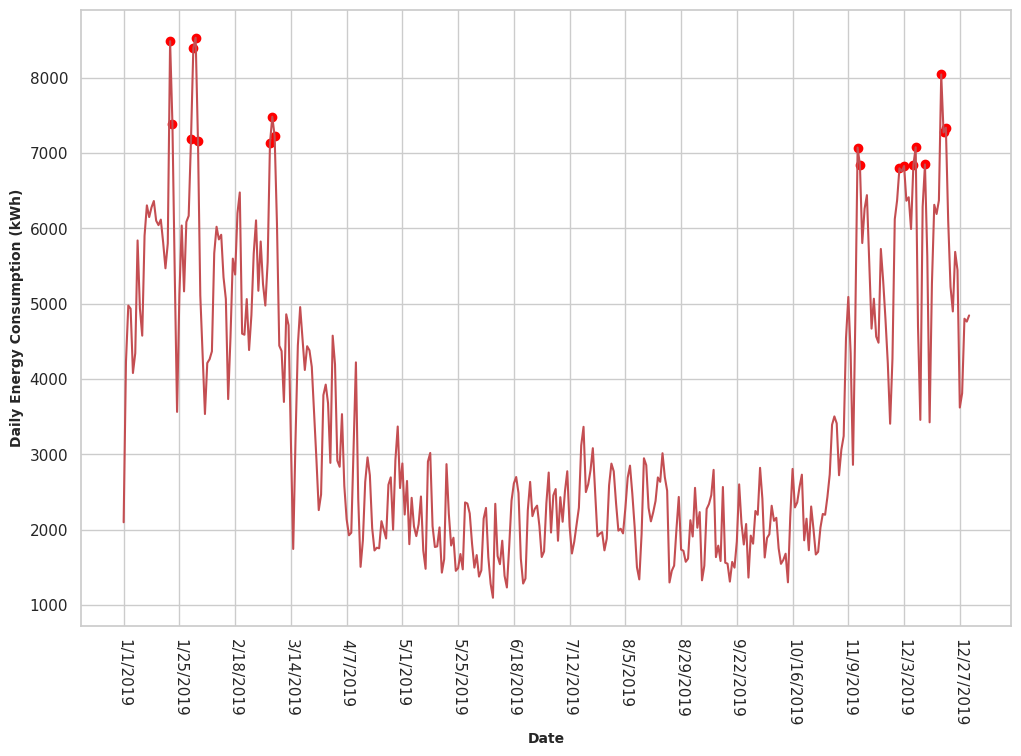

In [ ]:
# Plot the data with anomalies marked in red
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(data_converted_nn_d_19_PPWA['timestamp'], data_converted_nn_d_19_PPWA['EnergyUse'], color='r')
plt.scatter(data_converted_nn_d_19_PPWA['timestamp'][anomalous_nn_d_19_PPWA], data_converted_nn_d_19_PPWA['EnergyUse'][anomalous_nn_d_19_PPWA], marker='o', color='red')
plt.xlabel('Date', fontweight ='bold', fontsize = 10)
plt.ylabel('Daily Energy Consumption (kWh)', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 365, 24))
plt.tick_params(axis ='x', rotation = -90)
plt.show()

In [ ]:
# Isolate the anomolous values
anomalous_nn_d_19_PPWA_true = data_converted_nn_d_19_PPWA[anomalous_nn_d_19_PPWA]
anomalous_nn_d_19_PPWA_index = anomalous_nn_d_19_PPWA_true.index

anomalous_nn_d_19_PPWA_weather = b1_daily_2019.iloc[anomalous_nn_d_19_PPWA_index]
anomalous_nn_d_19_PPWA_weather = anomalous_nn_d_19_PPWA_weather[['datetime', 'EnergyUse', 'Temp', 'RelHum', 'Humidity', 'UVIndex']]
print(anomalous_nn_d_19_PPWA_weather)

       datetime EnergyUse  Temp RelHum Humidity UVIndex
20    1/21/2019   8485.96  12.6   -6.6     41.9       4
21    1/22/2019    7392.0  21.1    3.2     46.7       5
29    1/30/2019    7184.8  19.9    4.2     50.7       5
30    1/31/2019   8397.22   8.8   -9.6     42.3       5
31     2/1/2019   8532.16  12.9    4.1     68.6       2
32     2/2/2019   7164.08  21.2   13.9     73.8       4
63     3/5/2019    7133.0  24.5    8.0     49.4       7
64     3/6/2019    7483.0  20.5    4.5     49.7       7
65     3/7/2019    7228.2  24.0   10.5     56.5       4
316  11/13/2019   7074.06  26.7    7.8     44.9       4
317  11/14/2019   6843.06  33.1   19.4     57.8       5
334   12/1/2019    6797.7  32.8   26.8     79.6       0
336   12/3/2019   6828.36  34.0   23.6     67.3       4
340   12/7/2019   6837.18  33.1   18.5     55.3       4
341   12/8/2019   7077.42  30.8   20.2     66.2       2
345  12/12/2019   6848.94  29.2   14.4     53.9       3
352  12/19/2019   8044.68  21.0    6.4     53.0 

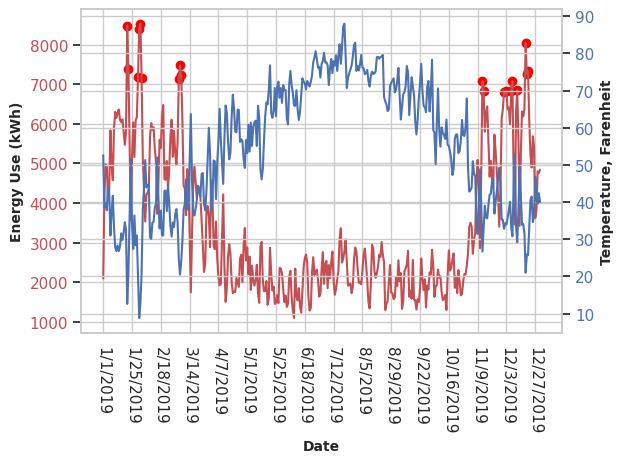

In [ ]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Date', fontweight ='bold', fontsize = 10)
ax1.set_ylabel('Energy Use (kWh)', fontweight ='bold', fontsize = 10)
ax1.plot(data_converted_nn_d_19_PPWA['timestamp'], data_converted_nn_d_19_PPWA['EnergyUse'], color='r')
plt.scatter(data_converted_nn_d_19_PPWA['timestamp'][anomalous_nn_d_19_PPWA], data_converted_nn_d_19_PPWA['EnergyUse'][anomalous_nn_d_19_PPWA], marker='o', color='red')
ax1.set_xticks(np.arange(0, 365, 24))
ax1.tick_params(axis ='y', labelcolor='r')
ax1.tick_params(axis ='x', rotation = -90)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

ax2.set_ylabel('Temperature, Farenheit', fontweight ='bold', fontsize = 10)  # we already handled the x-label with ax1
ax2.plot(data_converted_nn_d_19_PPWA['timestamp'], b1_daily_2019['Temp'], color='b')
ax2.tick_params(axis ='y', labelcolor='b')
ax2.tick_params(axis ='x', rotation = -90)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

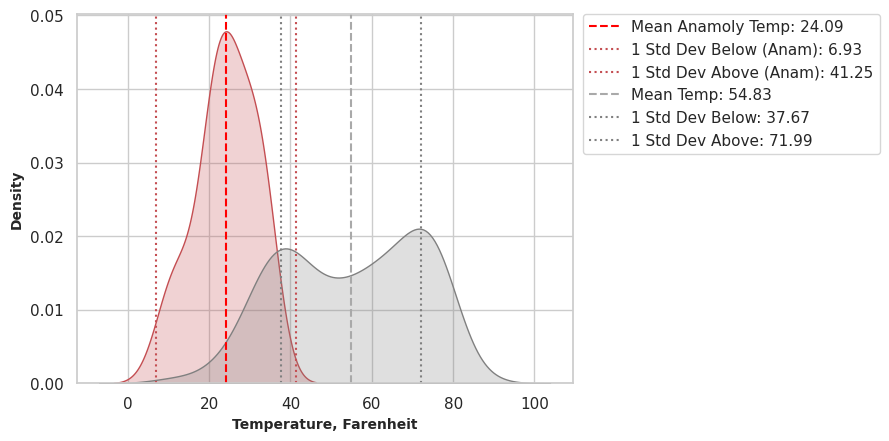

In [ ]:
# Visualize distrubution of anamolous temperatures
anamalous_temp_nn_d_19_mean = np.mean(anomalous_nn_d_19_PPWA_weather['Temp'])
anamalous_temp_nn_d_19_std_dev = np.std(anomalous_nn_d_19_PPWA_weather['Temp'])

temp_nn_d_19_mean = np.mean(b1_daily_2019['Temp'])
temp_nn_d_19_std_dev = np.std(b1_daily_2019['Temp'])

sns.set(style='whitegrid')
sns.kdeplot(anomalous_nn_d_19_PPWA_weather['Temp'], fill=True, color="r")
plt.axvline(anamalous_temp_nn_d_19_mean, color='red', linestyle='--', label=f'Mean Anamoly Temp: {anamalous_temp_nn_d_19_mean:.2f}')
plt.axvline(anamalous_temp_nn_d_19_mean - temp_nn_d_19_std_dev, color='r', linestyle=':', label=f'1 Std Dev Below (Anam): {anamalous_temp_nn_d_19_mean - temp_nn_d_19_std_dev:.2f}')
plt.axvline(anamalous_temp_nn_d_19_mean + temp_nn_d_19_std_dev, color='r', linestyle=':', label=f'1 Std Dev Above (Anam): {anamalous_temp_nn_d_19_mean + temp_nn_d_19_std_dev:.2f}')

sns.kdeplot(b1_daily_2019['Temp'], fill=True, color="grey")
plt.axvline(temp_nn_d_19_mean, color='darkgrey', linestyle='--', label=f'Mean Temp: {temp_nn_d_19_mean:.2f}')
plt.axvline(temp_nn_d_19_mean - temp_nn_d_19_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Below: {temp_nn_d_19_mean - temp_nn_d_19_std_dev:.2f}')
plt.axvline(temp_nn_d_19_mean + temp_nn_d_19_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Above: {temp_nn_d_19_mean + temp_nn_d_19_std_dev:.2f}')

plt.xlabel('Temperature, Farenheit', fontweight ='bold', fontsize = 10)
plt.ylabel('Density', fontweight ='bold', fontsize = 10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

In [ ]:
# 2020:
# Exclude datetime column
data_tensor_nn_d_20_PPWA = tf.convert_to_tensor(data_converted_nn_d_20_PPWA.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# print(data_tensor_nn_d_20_PPWA)

# Define the autoencoder model
input_dim_nn_d_20_PPWA = data_converted_nn_d_20_PPWA.shape[1] - 1
encoding_dim_nn_d_20_PPWA = 10

input_layer_nn_d_20_PPWA = Input(shape=(input_dim_nn_d_20_PPWA,))
encoder_nn_d_20_PPWA = Dense(encoding_dim_nn_d_20_PPWA, activation='relu')(input_layer_nn_d_20_PPWA)
decoder_nn_d_20_PPWA = Dense(input_dim_nn_d_20_PPWA, activation='relu')(encoder_nn_d_20_PPWA)
autoencoder_nn_d_20_PPWA = Model(inputs=input_layer_nn_d_20_PPWA, outputs=decoder_nn_d_20_PPWA)

# Compile and fit the model
autoencoder_nn_d_20_PPWA.compile(optimizer='adam', loss='mae')
autoencoder_nn_d_20_PPWA.fit(data_tensor_nn_d_20_PPWA, data_tensor_nn_d_20_PPWA, epochs=40,
				batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions_nn_d_20_PPWA = autoencoder_nn_d_20_PPWA.predict(data_tensor_nn_d_20_PPWA)
mae_nn_d_20_PPWA = tf.reduce_mean(tf.square(data_tensor_nn_d_20_PPWA - reconstructions_nn_d_20_PPWA),
					axis=1)
anomaly_scores_nn_d_20_PPWA = pd.Series(mae_nn_d_20_PPWA.numpy(), name='anomaly_scores')
anomaly_scores_nn_d_20_PPWA.index = data_converted_nn_d_20_PPWA.index

Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3111.8843  
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3071.7041 
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3187.5239 
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3182.4060 
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3080.0601 
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3114.3369  
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3104.0276 
Epoch 8/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3171.2224 
Epoch 9/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3054.9438 
Epoch 10/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3149.9944 
Epoch 11/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3047.4890  
Epoch 12/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3094.7053 
Epoch 13/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3170.4231  
Epoch 14/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3098.2832 
Epoch 15/40
12/12 ━━━━━━━

In [ ]:
threshold_nn_d_20_PPWA = anomaly_scores_nn_d_20_PPWA.quantile(0.95)
anomalous_nn_d_20_PPWA = anomaly_scores_nn_d_20_PPWA > threshold_nn_d_20_PPWA
binary_labels_nn_d_20_PPWA = anomalous_nn_d_20_PPWA.astype(int)
precision_nn_d_20_PPWA, recall_nn_d_20_PPWA, f1_score_nn_d_20_PPWA, _ = precision_recall_fscore_support(binary_labels_nn_d_20_PPWA, anomalous_nn_d_20_PPWA, average='binary')

In [ ]:
test_nn_d_20_PPWA = data_converted_nn_d_20_PPWA['EnergyUse'].values
predictions_nn_d_20_PPWA = anomaly_scores_nn_d_20_PPWA.values

print("Precision: ", precision_nn_d_20_PPWA)
print("Recall: ", recall_nn_d_20_PPWA)
print("F1 Score: ", f1_score_nn_d_20_PPWA)

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


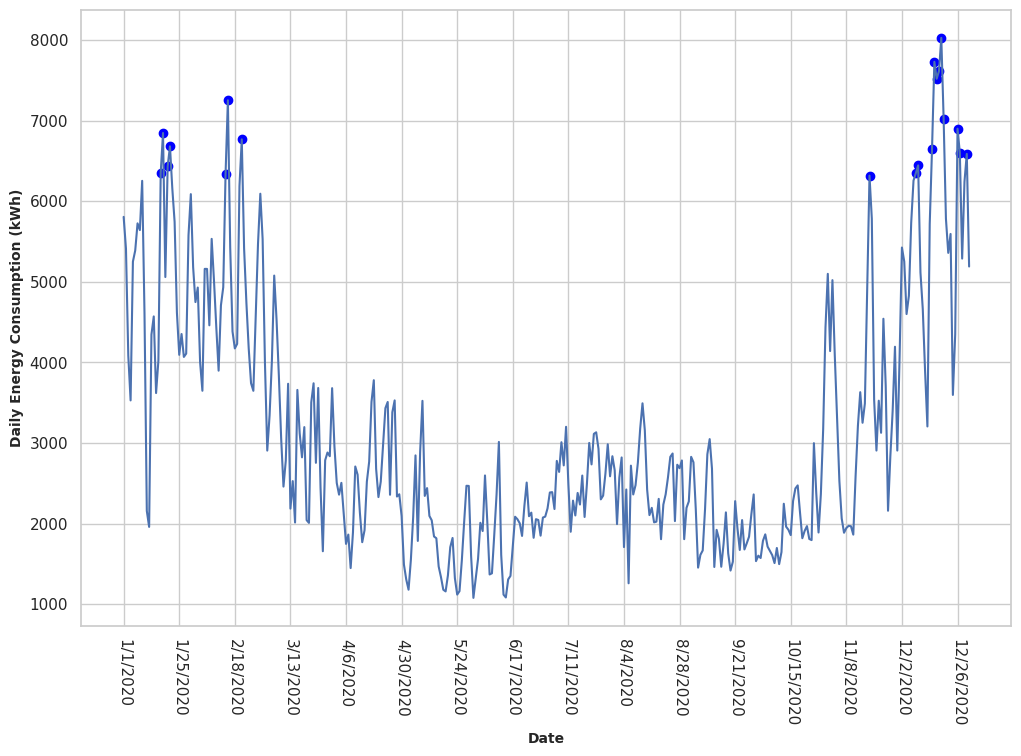

In [ ]:
# Plot the data with anomalies marked in blue
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(data_converted_nn_d_20_PPWA['timestamp'], data_converted_nn_d_20_PPWA['EnergyUse'], color='b')
plt.scatter(data_converted_nn_d_20_PPWA['timestamp'][anomalous_nn_d_20_PPWA], data_converted_nn_d_20_PPWA['EnergyUse'][anomalous_nn_d_20_PPWA], marker='o', color='blue')
plt.xlabel('Date', fontweight ='bold', fontsize = 10)
plt.ylabel('Daily Energy Consumption (kWh)', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 365, 24))
plt.tick_params(axis ='x', rotation = -90)
plt.show()

In [ ]:
# Isolate the anomalous values
anomalous_nn_d_20_PPWA_true = data_converted_nn_d_20_PPWA[anomalous_nn_d_20_PPWA]
# anomalous_nn_d_20_PPWA_index = anomalous_nn_d_20_PPWA_true.index # This line is no longer needed

# Directly filter b1_daily_2020 using the boolean series anomalous_nn_d_20_PPWA
# Ensure the index of anomalous_nn_d_20_PPWA aligns with b1_daily_2020 if needed,
# but since both were derived from the same original data and filtered/indexed similarly,
# direct boolean indexing should work if the indices are aligned.
# Given the previous reset_index calls, the indices should now be 0-based and aligned.
anomalous_nn_d_20_PPWA_weather = b1_daily_2020[anomalous_nn_d_20_PPWA]

anomalous_nn_d_20_PPWA_weather = anomalous_nn_d_20_PPWA_weather[['datetime', 'EnergyUse', 'Temp', 'RelHum', 'Humidity', 'UVIndex']]
print(anomalous_nn_d_20_PPWA_weather)

       datetime EnergyUse  Temp RelHum Humidity UVIndex
381   1/17/2020   6354.18  26.6    5.4     40.5       4
382   1/18/2020   6847.68  24.1   13.8     67.2       1
384   1/20/2020   6434.82  25.5    6.0     44.2       5
385   1/21/2020   6681.78  24.7    7.1     48.0       5
409   2/14/2020   6342.42  29.8   14.1     53.0       5
410   2/15/2020    7253.4  21.1    2.7     45.5       4
416   2/21/2020    6768.3  26.7    6.2     42.9       6
687  11/18/2020   6318.48  32.6   15.4     49.1       4
707   12/8/2020   6348.72  32.9   19.7     58.7       3
708   12/9/2020   6445.32  32.5   25.3     75.2       2
714  12/15/2020   6654.48  32.3   18.1     56.0       3
715  12/16/2020   7730.94  26.8   17.8     70.0       1
716  12/17/2020   7520.94  28.8   21.9     76.1       3
717  12/18/2020   7615.44  27.3   18.0     68.1       3
718  12/19/2020    8028.3  23.5   13.6     66.7       3
719  12/20/2020   7026.18  30.6   25.9     82.7       2
725  12/26/2020    6900.6  25.5   11.8     55.7 

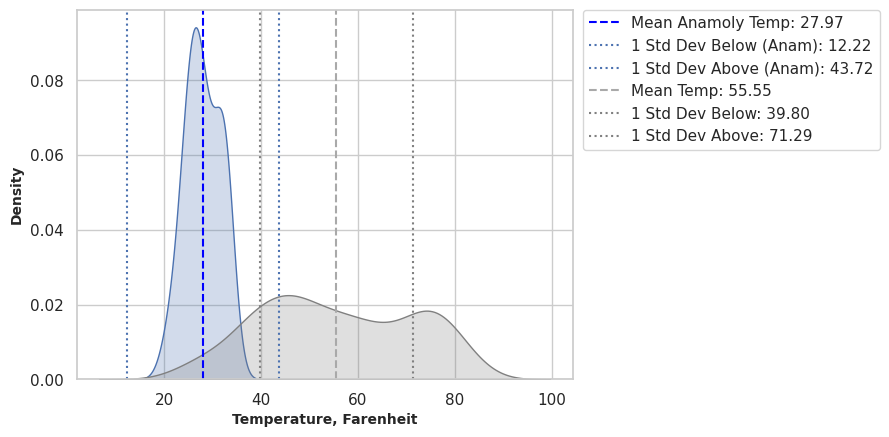

In [ ]:
# Visualize distrubution of anamolous temperatures
anamalous_temp_nn_d_20_mean = np.mean(anomalous_nn_d_20_PPWA_weather['Temp'])
anamalous_temp_nn_d_20_std_dev = np.std(anomalous_nn_d_20_PPWA_weather['Temp'])

temp_nn_d_20_mean = np.mean(b1_daily_2020['Temp'])
temp_nn_d_20_std_dev = np.std(b1_daily_2020['Temp'])

sns.set(style='whitegrid')
sns.kdeplot(anomalous_nn_d_20_PPWA_weather['Temp'], fill=True, color="b")
plt.axvline(anamalous_temp_nn_d_20_mean, color='blue', linestyle='--', label=f'Mean Anamoly Temp: {anamalous_temp_nn_d_20_mean:.2f}')
plt.axvline(anamalous_temp_nn_d_20_mean - temp_nn_d_20_std_dev, color='b', linestyle=':', label=f'1 Std Dev Below (Anam): {anamalous_temp_nn_d_20_mean - temp_nn_d_20_std_dev:.2f}')
plt.axvline(anamalous_temp_nn_d_20_mean + temp_nn_d_20_std_dev, color='b', linestyle=':', label=f'1 Std Dev Above (Anam): {anamalous_temp_nn_d_20_mean + temp_nn_d_20_std_dev:.2f}')

sns.kdeplot(b1_daily_2020['Temp'], fill=True, color="grey")
plt.axvline(temp_nn_d_20_mean, color='darkgrey', linestyle='--', label=f'Mean Temp: {temp_nn_d_20_mean:.2f}')
plt.axvline(temp_nn_d_20_mean - temp_nn_d_20_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Below: {temp_nn_d_20_mean - temp_nn_d_20_std_dev:.2f}')
plt.axvline(temp_nn_d_20_mean + temp_nn_d_20_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Above: {temp_nn_d_20_mean + temp_nn_d_20_std_dev:.2f}')

plt.xlabel('Temperature, Farenheit', fontweight ='bold', fontsize = 10)
plt.ylabel('Density', fontweight ='bold', fontsize = 10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

In [ ]:
# 2021:
# Exclude datetime column
data_tensor_nn_d_21_PPWA = tf.convert_to_tensor(data_converted_nn_d_21_PPWA.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# print(data_tensor_nn_d_21_PPWA)

# Define the autoencoder model
input_dim_nn_d_21_PPWA = data_converted_nn_d_21_PPWA.shape[1] - 1
encoding_dim_nn_d_21_PPWA = 10

input_layer_nn_d_21_PPWA = Input(shape=(input_dim_nn_d_21_PPWA,))
encoder_nn_d_21_PPWA = Dense(encoding_dim_nn_d_21_PPWA, activation='relu')(input_layer_nn_d_21_PPWA)
decoder_nn_d_21_PPWA = Dense(input_dim_nn_d_21_PPWA, activation='relu')(encoder_nn_d_21_PPWA)
autoencoder_nn_d_21_PPWA = Model(inputs=input_layer_nn_d_21_PPWA, outputs=decoder_nn_d_21_PPWA)

# Compile and fit the model
autoencoder_nn_d_21_PPWA.compile(optimizer='adam', loss='mae')
autoencoder_nn_d_21_PPWA.fit(data_tensor_nn_d_21_PPWA, data_tensor_nn_d_21_PPWA, epochs=40,
				batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions_nn_d_21_PPWA = autoencoder_nn_d_21_PPWA.predict(data_tensor_nn_d_21_PPWA)
mae_nn_d_21_PPWA = tf.reduce_mean(tf.square(data_tensor_nn_d_21_PPWA - reconstructions_nn_d_21_PPWA),
					axis=1)
anomaly_scores_nn_d_21_PPWA = pd.Series(mae_nn_d_21_PPWA.numpy(), name='anomaly_scores')
anomaly_scores_nn_d_21_PPWA.index = data_converted_nn_d_21_PPWA.index

Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3371.4731
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3441.8811 
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3494.4983 
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3434.1990 
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3411.1926 
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3397.2510 
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3339.6292 
Epoch 8/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3298.1462 
Epoch 9/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3325.6287 
Epoch 10/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3473.0261 
Epoch 11/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3413.1003 
Epoch 12/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3211.6284 
Epoch 13/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3459.1257 
Epoch 14/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3317.8521 
Epoch 15/40
12/12 ━━━━━━━━━━━━

In [ ]:
threshold_nn_d_21_PPWA = anomaly_scores_nn_d_21_PPWA.quantile(0.95)
anomalous_nn_d_21_PPWA = anomaly_scores_nn_d_21_PPWA > threshold_nn_d_21_PPWA
binary_labels_nn_d_21_PPWA = anomalous_nn_d_21_PPWA.astype(int)
precision_nn_d_21_PPWA, recall_nn_d_21_PPWA, f1_score_nn_d_21_PPWA, _ = precision_recall_fscore_support(binary_labels_nn_d_21_PPWA, anomalous_nn_d_21_PPWA, average='binary')

In [ ]:
test_nn_d_21_PPWA = data_converted_nn_d_21_PPWA['EnergyUse'].values
predictions_nn_d_21_PPWA = anomaly_scores_nn_d_21_PPWA.values

print("Precision: ", precision_nn_d_21_PPWA)
print("Recall: ", recall_nn_d_21_PPWA)
print("F1 Score: ", f1_score_nn_d_21_PPWA)

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


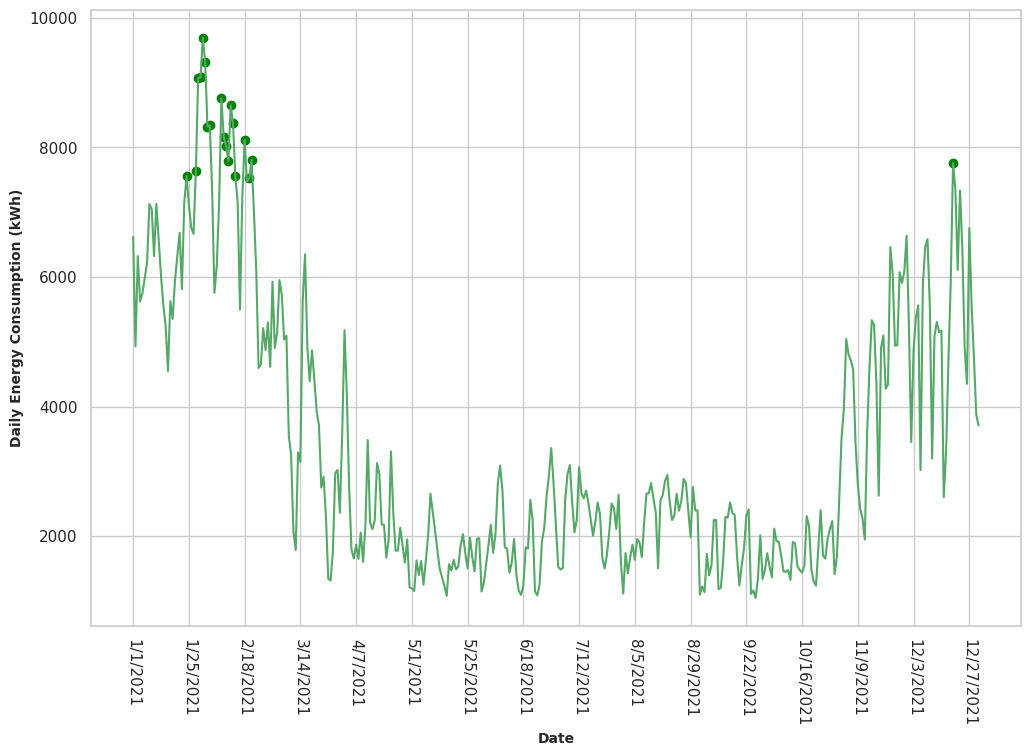

In [ ]:
# Plot the data with anomalies marked in green
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(data_converted_nn_d_21_PPWA['timestamp'], data_converted_nn_d_21_PPWA['EnergyUse'], color='g')
plt.scatter(data_converted_nn_d_21_PPWA['timestamp'][anomalous_nn_d_21_PPWA], data_converted_nn_d_21_PPWA['EnergyUse'][anomalous_nn_d_21_PPWA], marker='o', color='green')
plt.xlabel('Date', fontweight ='bold', fontsize = 10)
plt.ylabel('Daily Energy Consumption (kWh)', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 365, 24))
plt.tick_params(axis ='x', rotation = -90)
plt.show()

In [ ]:
# Isolate the anomalous values
anomalous_nn_d_21_PPWA_true = data_converted_nn_d_21_PPWA[anomalous_nn_d_21_PPWA]
# anomalous_nn_d_21_PPWA_index = anomalous_nn_d_21_PPWA_true.index # This line is no longer needed

# Directly filter b1_daily_2021 using the boolean series anomalous_nn_d_21_PPWA
# Ensure the index of anomalous_nn_d_21_PPWA aligns with b1_daily_2021 if needed,
# but since both were derived from the same original data and filtered/indexed similarly,
# direct boolean indexing should work if the indices are aligned.
# Given the previous reset_index calls, the indices should now be 0-based and aligned.
anomalous_nn_d_21_PPWA_weather = b1_daily_2021[anomalous_nn_d_21_PPWA]

anomalous_nn_d_21_PPWA_weather = anomalous_nn_d_21_PPWA_weather[['datetime', 'EnergyUse', 'Temp', 'RelHum', 'Humidity', 'UVIndex']]
print(anomalous_nn_d_21_PPWA_weather)

        datetime EnergyUse  Temp RelHum Humidity UVIndex
754    1/24/2021   7558.32  27.2    7.6     43.6       4
758    1/28/2021   7632.66  27.5   10.4     49.1       5
759    1/29/2021   9072.42  21.7    2.2     42.6       5
760    1/30/2021    9080.4  24.1    6.0     47.2       5
761    1/31/2021   9690.66  22.9   15.3     73.2       1
762     2/1/2021   9315.18  27.7   25.0     89.3       1
763     2/2/2021   8321.04  31.7   28.2     87.0       2
764     2/3/2021    8339.1  31.0   22.1     69.8       3
769     2/8/2021   8759.94  21.7    8.1     56.2       6
770     2/9/2021   8158.08  26.2   21.7     83.1       2
771    2/10/2021   8024.94  26.7   18.0     71.3       5
772    2/11/2021   7790.58  27.9   21.0     76.1       1
773    2/12/2021   8647.38  23.9    6.6     47.7       2
774    2/13/2021   8369.34  26.6   10.6     50.9       2
775    2/14/2021   7555.38  30.0   23.3     76.0       2
779    2/18/2021   8116.08  25.1   19.6     80.3       1
781    2/20/2021   7523.88  28.

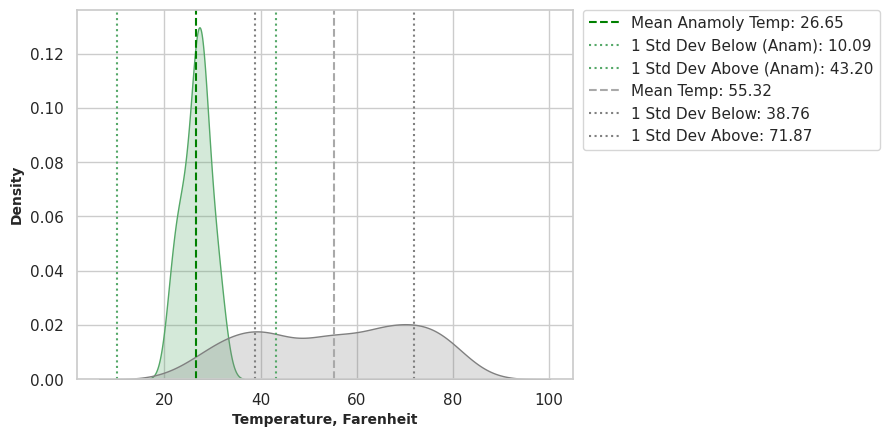

In [ ]:
# Visualize distrubution of anamolous temperatures
anamalous_temp_nn_d_21_mean = np.mean(anomalous_nn_d_21_PPWA_weather['Temp'])
anamalous_temp_nn_d_21_std_dev = np.std(anomalous_nn_d_21_PPWA_weather['Temp'])

temp_nn_d_21_mean = np.mean(b1_daily_2021['Temp'])
temp_nn_d_21_std_dev = np.std(b1_daily_2021['Temp'])

sns.set(style='whitegrid')
sns.kdeplot(anomalous_nn_d_21_PPWA_weather['Temp'], fill=True, color="g")
plt.axvline(anamalous_temp_nn_d_21_mean, color='green', linestyle='--', label=f'Mean Anamoly Temp: {anamalous_temp_nn_d_21_mean:.2f}')
plt.axvline(anamalous_temp_nn_d_21_mean - temp_nn_d_21_std_dev, color='g', linestyle=':', label=f'1 Std Dev Below (Anam): {anamalous_temp_nn_d_21_mean - temp_nn_d_21_std_dev:.2f}')
plt.axvline(anamalous_temp_nn_d_21_mean + temp_nn_d_21_std_dev, color='g', linestyle=':', label=f'1 Std Dev Above (Anam): {anamalous_temp_nn_d_21_mean + temp_nn_d_21_std_dev:.2f}')

sns.kdeplot(b1_daily_2021['Temp'], fill=True, color="grey")
plt.axvline(temp_nn_d_21_mean, color='darkgrey', linestyle='--', label=f'Mean Temp: {temp_nn_d_21_mean:.2f}')
plt.axvline(temp_nn_d_21_mean - temp_nn_d_21_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Below: {temp_nn_d_21_mean - temp_nn_d_21_std_dev:.2f}')
plt.axvline(temp_nn_d_21_mean + temp_nn_d_21_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Above: {temp_nn_d_21_mean + temp_nn_d_21_std_dev:.2f}')

plt.xlabel('Temperature, Farenheit', fontweight ='bold', fontsize = 10)
plt.ylabel('Density', fontweight ='bold', fontsize = 10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

In [ ]:
# 2022:
# Exclude datetime column
data_tensor_nn_d_22_PPWA = tf.convert_to_tensor(data_converted_nn_d_22_PPWA.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# print(data_tensor_nn_d_22_PPWA)

# Define the autoencoder model
input_dim_nn_d_22_PPWA = data_converted_nn_d_22_PPWA.shape[1] - 1
encoding_dim_nn_d_22_PPWA = 10

input_layer_nn_d_22_PPWA = Input(shape=(input_dim_nn_d_22_PPWA,))
encoder_nn_d_22_PPWA = Dense(encoding_dim_nn_d_22_PPWA, activation='relu')(input_layer_nn_d_22_PPWA)
decoder_nn_d_22_PPWA = Dense(input_dim_nn_d_22_PPWA, activation='relu')(encoder_nn_d_22_PPWA)
autoencoder_nn_d_22_PPWA = Model(inputs=input_layer_nn_d_22_PPWA, outputs=decoder_nn_d_22_PPWA)

# Compile and fit the model
autoencoder_nn_d_22_PPWA.compile(optimizer='adam', loss='mae')
autoencoder_nn_d_22_PPWA.fit(data_tensor_nn_d_22_PPWA, data_tensor_nn_d_22_PPWA, epochs=40,
				batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions_nn_d_22_PPWA = autoencoder_nn_d_22_PPWA.predict(data_tensor_nn_d_22_PPWA)
mae_nn_d_22_PPWA = tf.reduce_mean(tf.square(data_tensor_nn_d_22_PPWA - reconstructions_nn_d_22_PPWA),
					axis=1)
anomaly_scores_nn_d_22_PPWA = pd.Series(mae_nn_d_22_PPWA.numpy(), name='anomaly_scores'anomaly_scores_nn_d_22_PPWA.index = data_converted_nn_d_22_PPWA.index

Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3062.2029
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2969.5686  
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2932.2009 
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2576.3391 
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2481.4756 
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2303.5605 
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2082.7214 
Epoch 8/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2016.8042 
Epoch 9/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1856.1373 
Epoch 10/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1591.5443 
Epoch 11/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1485.0448 
Epoch 12/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1264.4718 
Epoch 13/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1074.5269 
Epoch 14/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 855.8429 
Epoch 15/40
12/12 ━━━━━━━━━━━━

In [ ]:
threshold_nn_d_22_PPWA = anomaly_scores_nn_d_22_PPWA.quantile(0.95)
anomalous_nn_d_22_PPWA = anomaly_scores_nn_d_22_PPWA > threshold_nn_d_22_PPWA
binary_labels_nn_d_22_PPWA = anomalous_nn_d_22_PPWA.astype(int)
precision_nn_d_22_PPWA, recall_nn_d_22_PPWA, f1_score_nn_d_22_PPWA, _ = precision_recall_fscore_support(binary_labels_nn_d_22_PPWA, anomalous_nn_d_22_PPWA, average='binary')

In [ ]:
test_nn_d_22_PPWA = data_converted_nn_d_22_PPWA['EnergyUse'].values
predictions_nn_d_22_PPWA = anomaly_scores_nn_d_22_PPWA.values

print("Precision: ", precision_nn_d_22_PPWA)
print("Recall: ", recall_nn_d_22_PPWA)
print("F1 Score: ", f1_score_nn_d_22_PPWA)

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


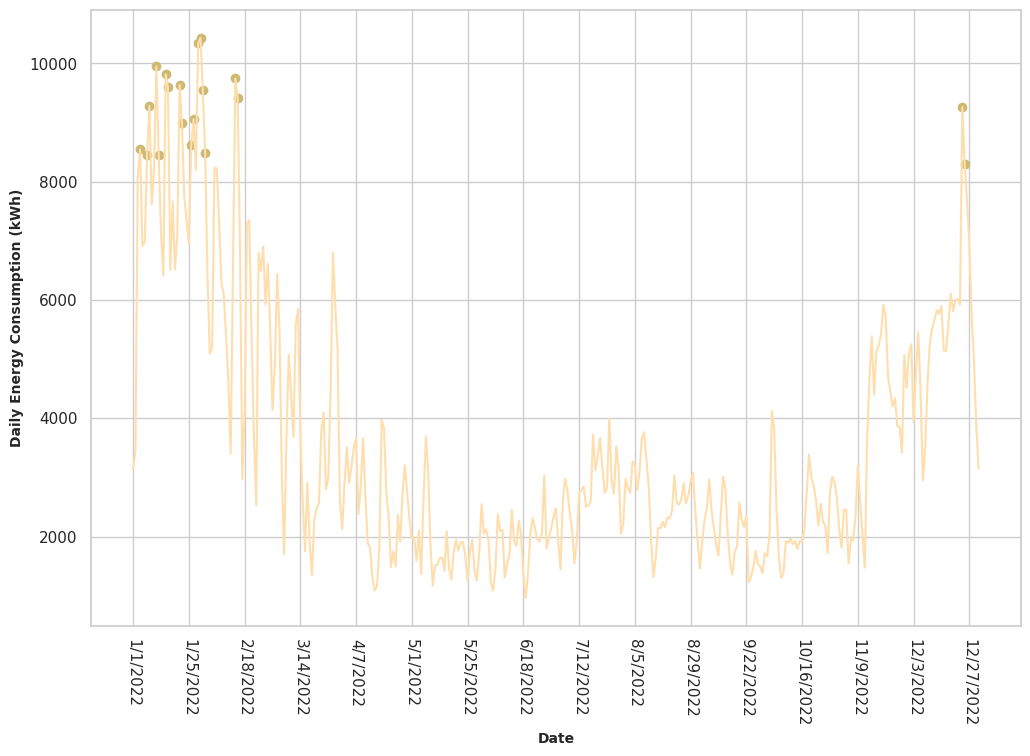

In [ ]:
# Plot the data with anomalies marked in yellow
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(data_converted_nn_d_22_PPWA['timestamp'], data_converted_nn_d_22_PPWA['EnergyUse'], color='navajowhite')
plt.scatter(data_converted_nn_d_22_PPWA['timestamp'][anomalous_nn_d_22_PPWA], data_converted_nn_d_22_PPWA['EnergyUse'][anomalous_nn_d_22_PPWA], marker='o', color='y')
plt.xlabel('Date', fontweight ='bold', fontsize = 10)
plt.ylabel('Daily Energy Consumption (kWh)', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 365, 24))
plt.tick_params(axis ='x', rotation = -90)
plt.show()

In [ ]:
# Isolate the anomalous values
anomalous_nn_d_22_PPWA_true = data_converted_nn_d_22_PPWA[anomalous_nn_d_22_PPWA]
# anomalous_nn_d_22_PPWA_index = anomalous_nn_d_22_PPWA_true.index # This line is no longer needed

# Directly filter b1_daily_2022 using the boolean series anomalous_nn_d_22_PPWA
# Ensure the index of anomalous_nn_d_22_PPWA aligns with b1_daily_2022 if needed,
# but since both were derived from the same original data and filtered/indexed similarly,
# direct boolean indexing should work if the indices are aligned.
# Given the previous reset_index calls, the indices should now be 0-based and aligned.
anomalous_nn_d_22_PPWA_weather = b1_daily_2022[anomalous_nn_d_22_PPWA]

anomalous_nn_d_22_PPWA_weather = anomalous_nn_d_22_PPWA_weather[['datetime', 'EnergyUse', 'Temp', 'RelHum', 'Humidity', 'UVIndex']]
print(anomalous_nn_d_22_PPWA_weather)

        datetime EnergyUse  Temp RelHum Humidity UVIndex
1099    1/4/2022   8547.84  25.2   12.4     58.6       1
1102    1/7/2022   8455.02  27.5   19.0     72.1       6
1103    1/8/2022   9281.16  22.8    7.4     51.6       5
1106   1/11/2022   9948.54  18.2    0.9     47.0       4
1107   1/12/2022   8444.94  27.0   14.9     60.8       4
1110   1/15/2022    9817.5  16.7   -5.8     36.4       3
1111   1/16/2022   9592.38  18.7   10.2     69.9       3
1116   1/21/2022   9637.74  18.1    1.9     49.6       4
1117   1/22/2022   8992.62  19.7    2.2     47.0       4
1121   1/26/2022   8615.46  22.5    5.6     48.8       2
1122   1/27/2022    9055.2  21.1    6.6     55.8       5
1124   1/29/2022  10343.34  19.9   11.5     72.5       2
1125   1/30/2022  10431.12  16.0    0.9     51.6       5
1126   1/31/2022   9549.54  20.9    8.9     60.2       5
1127    2/1/2022   8484.42  26.0   15.7     65.1       6
1140   2/14/2022   9746.52  19.8    3.3     48.6       6
1141   2/15/2022   9408.84  20.

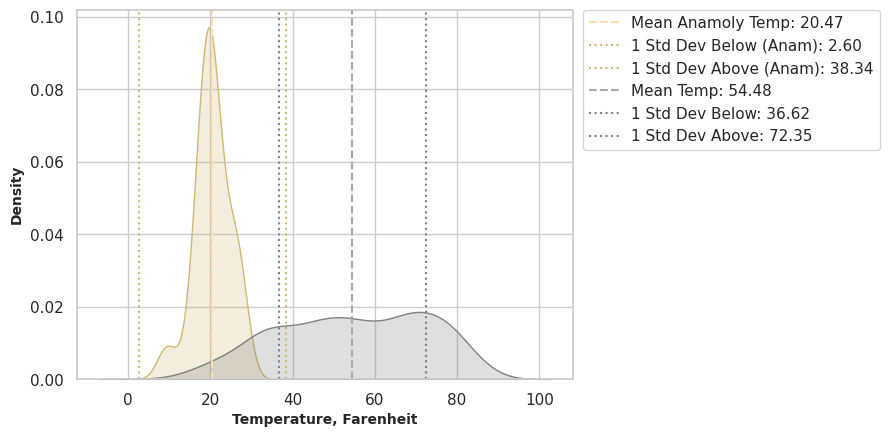

In [ ]:
# Visualize distrubution of anamolous temperatures
anamalous_temp_nn_d_22_mean = np.mean(anomalous_nn_d_22_PPWA_weather['Temp'])
anamalous_temp_nn_d_22_std_dev = np.std(anomalous_nn_d_22_PPWA_weather['Temp'])

temp_nn_d_22_mean = np.mean(b1_daily_2022['Temp'])
temp_nn_d_22_std_dev = np.std(b1_daily_2022['Temp'])

sns.set(style='whitegrid')
sns.kdeplot(anomalous_nn_d_22_PPWA_weather['Temp'], fill=True, color="y")
plt.axvline(anamalous_temp_nn_d_22_mean, color='navajowhite', linestyle='--', label=f'Mean Anamoly Temp: {anamalous_temp_nn_d_22_mean:.2f}')
plt.axvline(anamalous_temp_nn_d_22_mean - temp_nn_d_22_std_dev, color='y', linestyle=':', label=f'1 Std Dev Below (Anam): {anamalous_temp_nn_d_22_mean - temp_nn_d_22_std_dev:.2f}')
plt.axvline(anamalous_temp_nn_d_22_mean + temp_nn_d_22_std_dev, color='y', linestyle=':', label=f'1 Std Dev Above (Anam): {anamalous_temp_nn_d_22_mean + temp_nn_d_22_std_dev:.2f}')

sns.kdeplot(b1_daily_2022['Temp'], fill=True, color="grey")
plt.axvline(temp_nn_d_22_mean, color='darkgrey', linestyle='--', label=f'Mean Temp: {temp_nn_d_22_mean:.2f}')
plt.axvline(temp_nn_d_22_mean - temp_nn_d_22_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Below: {temp_nn_d_22_mean - temp_nn_d_22_std_dev:.2f}')
plt.axvline(temp_nn_d_22_mean + temp_nn_d_22_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Above: {temp_nn_d_22_mean + temp_nn_d_22_std_dev:.2f}')

plt.xlabel('Temperature, Farenheit', fontweight ='bold', fontsize = 10)
plt.ylabel('Density', fontweight ='bold', fontsize = 10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# Building 1, NN (Peak Producing Weather Analysis, Daily) Entire Year

In [ ]:
# Use the existing 'datetime' column and rename it to 'timestamp' and keep only EnergyUse
# DO THIS FOR THE ENTIRE DATASET
data_converted_nn_d_yr_PPWA = b1_daily_df.copy() # Create a copy to avoid modifying the original DataFrame
data_converted_nn_d_yr_PPWA = data_converted_nn_d_yr_PPWA.rename(columns={'datetime': 'timestamp'})
data_converted_nn_d_yr_PPWA = data_converted_nn_d_yr_PPWA[['timestamp', 'EnergyUse']]

# Drop blank values
data_converted_nn_d_yr_PPWA = data_converted_nn_d_yr_PPWA.dropna()

In [ ]:
# Exclude datetime column
data_tensor_nn_d_yr_PPWA = tf.convert_to_tensor(data_converted_nn_d_yr_PPWA.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# print(data_tensor_nn_d_yr_PPWA)

# Define the autoencoder model
input_dim_nn_d_yr_PPWA = data_converted_nn_d_yr_PPWA.shape[1] - 1
encoding_dim_nn_d_yr_PPWA = 10

input_layer_nn_d_yr_PPWA = Input(shape=(input_dim_nn_d_yr_PPWA,))
encoder_nn_d_yr_PPWA = Dense(encoding_dim_nn_d_yr_PPWA, activation='relu')(input_layer_nn_d_yr_PPWA)
decoder_nn_d_yr_PPWA = Dense(input_dim_nn_d_yr_PPWA, activation='relu')(encoder_nn_d_yr_PPWA)
autoencoder_nn_d_yr_PPWA = Model(inputs=input_layer_nn_d_yr_PPWA, outputs=decoder_nn_d_yr_PPWA)

# Compile and fit the model
autoencoder_nn_d_yr_PPWA.compile(optimizer='adam', loss='mae')
autoencoder_nn_d_yr_PPWA.fit(data_tensor_nn_d_yr_PPWA, data_tensor_nn_d_yr_PPWA, epochs=40,
				batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions_nn_d_yr_PPWA = autoencoder_nn_d_yr_PPWA.predict(data_tensor_nn_d_yr_PPWA)
mae_nn_d_yr_PPWA = tf.reduce_mean(tf.square(data_tensor_nn_d_yr_PPWA - reconstructions_nn_d_yr_PPWA),
					axis=1)
anomaly_scores_nn_d_yr_PPWA = pd.Series(mae_nn_d_yr_PPWA.numpy(), name='anomaly_scores')
anomaly_scores_nn_d_yr_PPWA.index = data_converted_nn_d_yr_PPWA.index

Epoch 1/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2890.9910
Epoch 2/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2263.7361
Epoch 3/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1400.0510
Epoch 4/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 581.1066
Epoch 5/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35.4128
Epoch 6/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2282
Epoch 7/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7391
Epoch 8/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3863
Epoch 9/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7385
Epoch 10/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3168
Epoch 11/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1586
Epoch 12/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9343
Epoch 13/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7564
Epoch 14/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4349
Epoch 15/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0771
Epoch 1

In [ ]:
threshold_nn_d_yr_PPWA = anomaly_scores_nn_d_yr_PPWA.quantile(0.96)
anomalous_nn_d_yr_PPWA = anomaly_scores_nn_d_yr_PPWA > threshold_nn_d_yr_PPWA
binary_labels_nn_d_yr_PPWA = anomalous_nn_d_yr_PPWA.astype(int)
precision_nn_d_yr_PPWA, recall_nn_d_yr_PPWA, f1_score_nn_d_yr_PPWA, _ = precision_recall_fscore_support(binary_labels_nn_d_yr_PPWA, anomalous_nn_d_yr_PPWA, average='binary')

In [ ]:
test_nn_d_yr_PPWA = data_converted_nn_d_yr_PPWA['EnergyUse'].values
predictions_nn_d_yr_PPWA = anomaly_scores_nn_d_yr_PPWA.values

print("Precision: ", precision_nn_d_yr_PPWA)
print("Recall: ", recall_nn_d_yr_PPWA)
print("F1 Score: ", f1_score_nn_d_yr_PPWA)

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


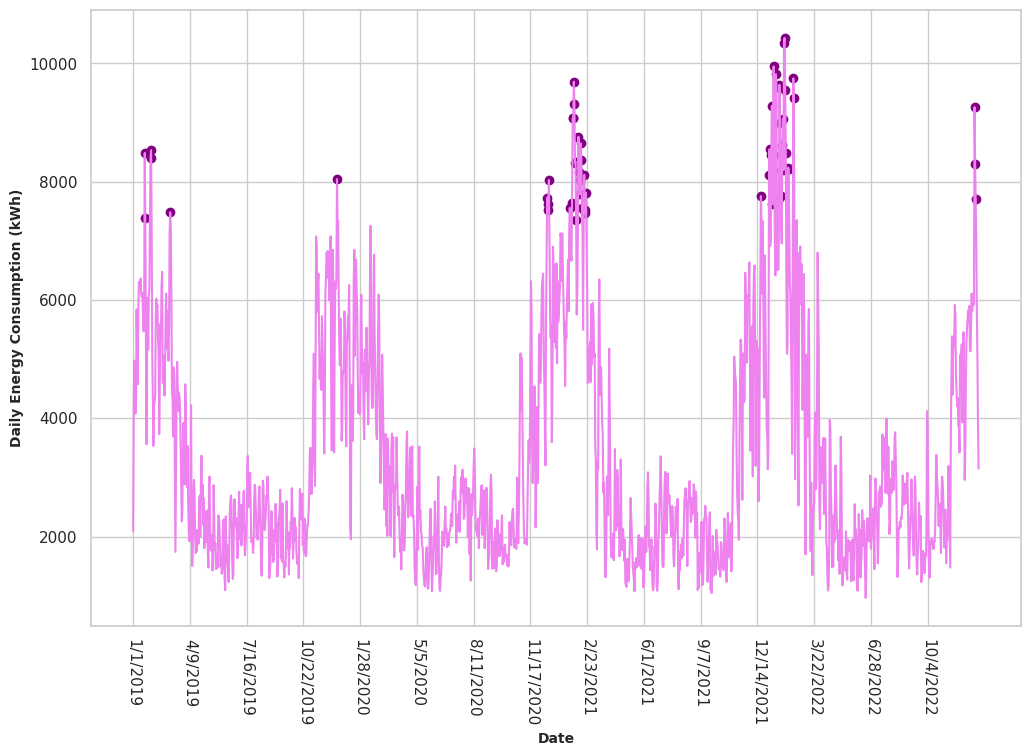

In [ ]:
# Plot the data with anomalies marked in yellow
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(data_converted_nn_d_yr_PPWA['timestamp'], data_converted_nn_d_yr_PPWA['EnergyUse'], color='violet')
plt.scatter(data_converted_nn_d_yr_PPWA['timestamp'][anomalous_nn_d_yr_PPWA], data_converted_nn_d_yr_PPWA['EnergyUse'][anomalous_nn_d_yr_PPWA], marker='o', color='purple')
plt.xlabel('Date', fontweight ='bold', fontsize = 10)
plt.ylabel('Daily Energy Consumption (kWh)', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 1460, 98))
plt.tick_params(axis ='x', rotation = -90)
plt.show()

In [ ]:
# Isolate the anomalous values
anomalous_nn_d_yr_PPWA_true = data_converted_nn_d_yr_PPWA[anomalous_nn_d_yr_PPWA]
# anomalous_nn_d_yr_PPWA_index = anomalous_nn_d_yr_PPWA_true.index # This line is no longer needed

# Directly filter b1_daily_df using the boolean series anomalous_nn_d_yr_PPWA
# Ensure the index of anomalous_nn_d_yr_PPWA aligns with b1_daily_df if needed,
# but since both were derived from the same original data and filtered/indexed similarly,
# direct boolean indexing should work if the indices are aligned.
# Given the previous reset_index calls, the indices should now be 0-based and aligned.
anomalous_nn_d_yr_PPWA_weather = b1_daily_df[anomalous_nn_d_yr_PPWA]

anomalous_nn_d_yr_PPWA_weather = anomalous_nn_d_yr_PPWA_weather[['datetime', 'EnergyUse', 'Temp', 'RelHum', 'Humidity', 'UVIndex']]
print(anomalous_nn_d_yr_PPWA_weather)

        datetime EnergyUse  Temp RelHum Humidity UVIndex
20     1/21/2019   8485.96  12.6   -6.6     41.9       4
21     1/22/2019    7392.0  21.1    3.2     46.7       5
30     1/31/2019   8397.22   8.8   -9.6     42.3       5
31      2/1/2019   8532.16  12.9    4.1     68.6       2
64      3/6/2019    7483.0  20.5    4.5     49.7       7
352   12/19/2019   8044.68  21.0    6.4     53.0       3
715   12/16/2020   7730.94  26.8   17.8     70.0       1
716   12/17/2020   7520.94  28.8   21.9     76.1       3
717   12/18/2020   7615.44  27.3   18.0     68.1       3
718   12/19/2020    8028.3  23.5   13.6     66.7       3
754    1/24/2021   7558.32  27.2    7.6     43.6       4
758    1/28/2021   7632.66  27.5   10.4     49.1       5
759    1/29/2021   9072.42  21.7    2.2     42.6       5
760    1/30/2021    9080.4  24.1    6.0     47.2       5
761    1/31/2021   9690.66  22.9   15.3     73.2       1
762     2/1/2021   9315.18  27.7   25.0     89.3       1
763     2/2/2021   8321.04  31.

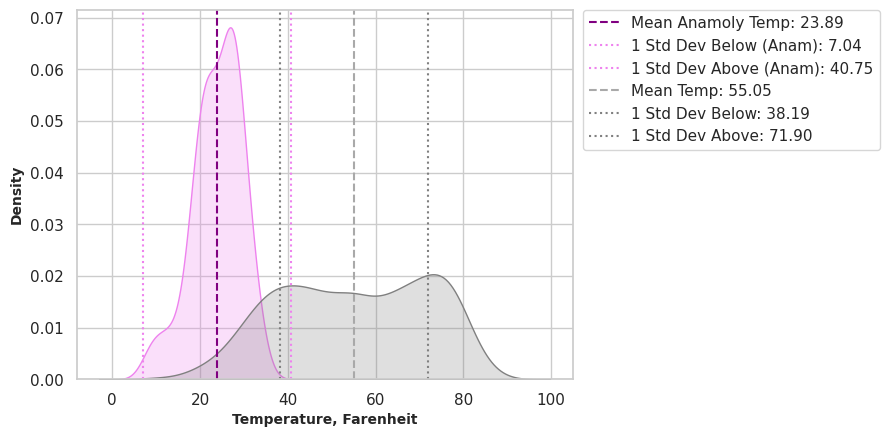

In [ ]:
# Visualize distrubution of anamolous temperatures
anamalous_temp_nn_d_yr_mean = np.mean(anomalous_nn_d_yr_PPWA_weather['Temp'])
anamalous_temp_nn_d_yr_std_dev = np.std(anomalous_nn_d_yr_PPWA_weather['Temp'])

temp_nn_d_yr_mean = np.mean(b1_daily_df['Temp'])
temp_nn_d_yr_std_dev = np.std(b1_daily_df['Temp'])

sns.set(style='whitegrid')
sns.kdeplot(anomalous_nn_d_yr_PPWA_weather['Temp'], fill=True, color="violet")
plt.axvline(anamalous_temp_nn_d_yr_mean, color='purple', linestyle='--', label=f'Mean Anamoly Temp: {anamalous_temp_nn_d_yr_mean:.2f}')
plt.axvline(anamalous_temp_nn_d_yr_mean - temp_nn_d_yr_std_dev, color='violet', linestyle=':', label=f'1 Std Dev Below (Anam): {anamalous_temp_nn_d_yr_mean - temp_nn_d_yr_std_dev:.2f}')
plt.axvline(anamalous_temp_nn_d_yr_mean + temp_nn_d_yr_std_dev, color='violet', linestyle=':', label=f'1 Std Dev Above (Anam): {anamalous_temp_nn_d_yr_mean + temp_nn_d_yr_std_dev:.2f}')

sns.kdeplot(b1_daily_df['Temp'], fill=True, color="grey")
plt.axvline(temp_nn_d_yr_mean, color='darkgrey', linestyle='--', label=f'Mean Temp: {temp_nn_d_yr_mean:.2f}')
plt.axvline(temp_nn_d_yr_mean - temp_nn_d_yr_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Below: {temp_nn_d_yr_mean - temp_nn_d_yr_std_dev:.2f}')
plt.axvline(temp_nn_d_yr_mean + temp_nn_d_yr_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Above: {temp_nn_d_yr_mean + temp_nn_d_yr_std_dev:.2f}')

plt.xlabel('Temperature, Farenheit', fontweight ='bold', fontsize = 10)
plt.ylabel('Density', fontweight ='bold', fontsize = 10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# Building 1, NN (Peak Producing Weather Analysis, Hourly)

# ^ Data Organization

In [ ]:
# Hourly Data, Analyzing Hourly Data Season to Season, Year to Year
# Seperate Data by Year (Hourly)
b1_hourly_2019 = b1_hourly_df[(b1_hourly_df['Year'] == 2019)]
b1_hourly_2020 = b1_hourly_df[(b1_hourly_df['Year'] == 2020)]
b1_hourly_2021 = b1_hourly_df[(b1_hourly_df['Year'] == 2021)]
b1_hourly_2022 = b1_hourly_df[(b1_hourly_df['Year'] == 2022)]

# 2019:
b1_hourly_win_19 = b1_hourly_2019[(b1_hourly_2019['Month'] == 1) | (b1_hourly_2019['Month'] == 2) | (b1_hourly_2019['Month'] == 12)]
b1_hourly_spr_19 = b1_hourly_2019[(b1_hourly_2019['Month'] == 3) | (b1_hourly_2019['Month'] == 4) | (b1_hourly_2019['Month'] == 5)]
b1_hourly_sum_19 = b1_hourly_2019[(b1_hourly_2019['Month'] == 6) | (b1_hourly_2019['Month'] == 7) | (b1_hourly_2019['Month'] == 8)]
b1_hourly_fal_19 = b1_hourly_2019[(b1_hourly_2019['Month'] == 9) | (b1_hourly_2019['Month'] == 10) | (b1_hourly_2019['Month'] == 11)]

# 2020:
b1_hourly_win_20 = b1_hourly_2020[(b1_hourly_2020['Month'] == 1) | (b1_hourly_2020['Month'] == 2) | (b1_hourly_2020['Month'] == 12)]
b1_hourly_spr_20 = b1_hourly_2020[(b1_hourly_2020['Month'] == 3) | (b1_hourly_2020['Month'] == 4) | (b1_hourly_2020['Month'] == 5)]
b1_hourly_sum_20 = b1_hourly_2020[(b1_hourly_2020['Month'] == 6) | (b1_hourly_2020['Month'] == 7) | (b1_hourly_2020['Month'] == 8)]
b1_hourly_fal_20 = b1_hourly_2020[(b1_hourly_2020['Month'] == 9) | (b1_hourly_2020['Month'] == 10) | (b1_hourly_2020['Month'] == 11)]

# 2021:
b1_hourly_win_21 = b1_hourly_2021[(b1_hourly_2021['Month'] == 1) | (b1_hourly_2021['Month'] == 2) | (b1_hourly_2021['Month'] == 12)]
b1_hourly_spr_21 = b1_hourly_2021[(b1_hourly_2021['Month'] == 3) | (b1_hourly_2021['Month'] == 4) | (b1_hourly_2021['Month'] == 5)]
b1_hourly_sum_21 = b1_hourly_2021[(b1_hourly_2021['Month'] == 6) | (b1_hourly_2021['Month'] == 7) | (b1_hourly_2021['Month'] == 8)]
b1_hourly_fal_21 = b1_hourly_2021[(b1_hourly_2021['Month'] == 9) | (b1_hourly_2021['Month'] == 10) | (b1_hourly_2021['Month'] == 11)]

# 2022:
b1_hourly_win_22 = b1_hourly_2022[(b1_hourly_2022['Month'] == 1) | (b1_hourly_2022['Month'] == 2) | (b1_hourly_2022['Month'] == 12)]
b1_hourly_spr_22 = b1_hourly_2022[(b1_hourly_2022['Month'] == 3) | (b1_hourly_2022['Month'] == 4) | (b1_hourly_2022['Month'] == 5)]
b1_hourly_sum_22 = b1_hourly_2022[(b1_hourly_2022['Month'] == 6) | (b1_hourly_2022['Month'] == 7) | (b1_hourly_2022['Month'] == 8)]
b1_hourly_fal_22 = b1_hourly_2022[(b1_hourly_2022['Month'] == 9) | (b1_hourly_2022['Month'] == 10) | (b1_hourly_2022['Month'] == 11)]

In [ ]:
# Create timeline column
# DO THIS FOR THE ENTIRE DATASET, EACH YEAR, EACH SEASON
# 2019:
dc_nn_h_win_19_PPWA = b1_hourly_win_19.copy() # Create a copy to avoid modifying the original DataFrame
dc_nn_h_win_19_PPWA['timestamp'] = dc_nn_h_win_19_PPWA['Hour'].astype(str) + ',' + ' ' + dc_nn_h_win_19_PPWA['Day'].astype(str) + ',' + ' ' + dc_nn_h_win_19_PPWA['Month'].astype(str)  + ',' + ' ' + dc_nn_h_win_19_PPWA['Year'].astype(str)
dc_nn_h_win_19_PPWA = dc_nn_h_win_19_PPWA[['timestamp', 'EnergyUse']]

# Drop blank values
dc_nn_h_win_19_PPWA = dc_nn_h_win_19_PPWA.dropna()

dc_nn_h_spr_19_PPWA = b1_hourly_spr_19.copy() # Create a copy to avoid modifying the original DataFrame
dc_nn_h_spr_19_PPWA['timestamp'] = dc_nn_h_spr_19_PPWA['Hour'].astype(str) + ',' + ' ' + dc_nn_h_spr_19_PPWA['Day'].astype(str) + ',' + ' ' + dc_nn_h_spr_19_PPWA['Month'].astype(str)  + ',' + ' ' + dc_nn_h_spr_19_PPWA['Year'].astype(str)
dc_nn_h_spr_19_PPWA = dc_nn_h_spr_19_PPWA[['timestamp', 'EnergyUse']]

# Drop blank values
dc_nn_h_spr_19_PPWA = dc_nn_h_spr_19_PPWA.dropna()

dc_nn_h_sum_19_PPWA = b1_hourly_sum_19.copy() # Create a copy to avoid modifying the original DataFrame
dc_nn_h_sum_19_PPWA['timestamp'] = dc_nn_h_sum_19_PPWA['Hour'].astype(str) + ',' + ' ' + dc_nn_h_sum_19_PPWA['Day'].astype(str) + ',' + ' ' + dc_nn_h_sum_19_PPWA['Month'].astype(str)  + ',' + ' ' + dc_nn_h_sum_19_PPWA['Year'].astype(str)
dc_nn_h_sum_19_PPWA = dc_nn_h_sum_19_PPWA[['timestamp', 'EnergyUse']]

# Drop blank values
dc_nn_h_sum_19_PPWA = dc_nn_h_sum_19_PPWA.dropna()

dc_nn_h_fal_19_PPWA = b1_hourly_fal_19.copy() # Create a copy to avoid modifying the original DataFrame
dc_nn_h_fal_19_PPWA['timestamp'] = dc_nn_h_fal_19_PPWA['Hour'].astype(str) + ',' + ' ' + dc_nn_h_fal_19_PPWA['Day'].astype(str) + ',' + ' ' + dc_nn_h_fal_19_PPWA['Month'].astype(str)  + ',' + ' ' + dc_nn_h_fal_19_PPWA['Year'].astype(str)
dc_nn_h_fal_19_PPWA = dc_nn_h_fal_19_PPWA[['timestamp', 'EnergyUse']]

# Drop blank values
dc_nn_h_fal_19_PPWA = dc_nn_h_fal_19_PPWA.dropna()

In [ ]:
# Create timeline column
# DO THIS FOR THE ENTIRE DATASET, EACH YEAR, EACH SEASON
# 2020:
dc_nn_h_win_20_PPWA = b1_hourly_win_20.copy() # Create a copy to avoid modifying the original DataFrame
dc_nn_h_win_20_PPWA['timestamp'] = dc_nn_h_win_20_PPWA['Hour'].astype(str) + ',' + ' ' + dc_nn_h_win_20_PPWA['Day'].astype(str) + ',' + ' ' + dc_nn_h_win_20_PPWA['Month'].astype(str)  + ',' + ' ' + dc_nn_h_win_20_PPWA['Year'].astype(str)
dc_nn_h_win_20_PPWA = dc_nn_h_win_20_PPWA[['timestamp', 'EnergyUse']]

# Drop blank values
dc_nn_h_win_20_PPWA = dc_nn_h_win_20_PPWA.dropna()

dc_nn_h_spr_20_PPWA = b1_hourly_spr_20.copy() # Create a copy to avoid modifying the original DataFrame
dc_nn_h_spr_20_PPWA['timestamp'] = dc_nn_h_spr_20_PPWA['Hour'].astype(str) + ',' + ' ' + dc_nn_h_spr_20_PPWA['Day'].astype(str) + ',' + ' ' + dc_nn_h_spr_20_PPWA['Month'].astype(str)  + ',' + ' ' + dc_nn_h_spr_20_PPWA['Year'].astype(str)
dc_nn_h_spr_20_PPWA = dc_nn_h_spr_20_PPWA[['timestamp', 'EnergyUse']]

# Drop blank values
dc_nn_h_spr_20_PPWA = dc_nn_h_spr_20_PPWA.dropna()

dc_nn_h_sum_20_PPWA = b1_hourly_sum_20.copy() # Create a copy to avoid modifying the original DataFrame
dc_nn_h_sum_20_PPWA['timestamp'] = dc_nn_h_sum_20_PPWA['Hour'].astype(str) + ',' + ' ' + dc_nn_h_sum_20_PPWA['Day'].astype(str) + ',' + ' ' + dc_nn_h_sum_20_PPWA['Month'].astype(str)  + ',' + ' ' + dc_nn_h_sum_20_PPWA['Year'].astype(str)
dc_nn_h_sum_20_PPWA = dc_nn_h_sum_20_PPWA[['timestamp', 'EnergyUse']]

# Drop blank values
dc_nn_h_sum_20_PPWA = dc_nn_h_sum_20_PPWA.dropna()

dc_nn_h_fal_20_PPWA = b1_hourly_fal_20.copy() # Create a copy to avoid modifying the original DataFrame
dc_nn_h_fal_20_PPWA['timestamp'] = dc_nn_h_fal_20_PPWA['Hour'].astype(str) + ',' + ' ' + dc_nn_h_fal_20_PPWA['Day'].astype(str) + ',' + ' ' + dc_nn_h_fal_20_PPWA['Month'].astype(str)  + ',' + ' ' + dc_nn_h_fal_20_PPWA['Year'].astype(str)
dc_nn_h_fal_20_PPWA = dc_nn_h_fal_20_PPWA[['timestamp', 'EnergyUse']]

# Drop blank values
dc_nn_h_fal_20_PPWA = dc_nn_h_fal_20_PPWA.dropna()

In [ ]:
# Create timeline column
# DO THIS FOR THE ENTIRE DATASET, EACH YEAR, EACH SEASON
# 2021:
dc_nn_h_win_21_PPWA = b1_hourly_win_21.copy() # Create a copy to avoid modifying the original DataFrame
dc_nn_h_win_21_PPWA['timestamp'] = dc_nn_h_win_21_PPWA['Hour'].astype(str) + ',' + ' ' + dc_nn_h_win_21_PPWA['Day'].astype(str) + ',' + ' ' + dc_nn_h_win_21_PPWA['Month'].astype(str)  + ',' + ' ' + dc_nn_h_win_21_PPWA['Year'].astype(str)
dc_nn_h_win_21_PPWA = dc_nn_h_win_21_PPWA[['timestamp', 'EnergyUse']]

# Drop blank values
dc_nn_h_win_21_PPWA = dc_nn_h_win_21_PPWA.dropna()

dc_nn_h_spr_21_PPWA = b1_hourly_spr_21.copy() # Create a copy to avoid modifying the original DataFrame
dc_nn_h_spr_21_PPWA['timestamp'] = dc_nn_h_spr_21_PPWA['Hour'].astype(str) + ',' + ' ' + dc_nn_h_spr_21_PPWA['Day'].astype(str) + ',' + ' ' + dc_nn_h_spr_21_PPWA['Month'].astype(str)  + ',' + ' ' + dc_nn_h_spr_21_PPWA['Year'].astype(str)
dc_nn_h_spr_21_PPWA = dc_nn_h_spr_21_PPWA[['timestamp', 'EnergyUse']]

# Drop blank values
dc_nn_h_spr_21_PPWA = dc_nn_h_spr_21_PPWA.dropna()

dc_nn_h_sum_21_PPWA = b1_hourly_sum_21.copy() # Create a copy to avoid modifying the original DataFrame
dc_nn_h_sum_21_PPWA['timestamp'] = dc_nn_h_sum_21_PPWA['Hour'].astype(str) + ',' + ' ' + dc_nn_h_sum_21_PPWA['Day'].astype(str) + ',' + ' ' + dc_nn_h_sum_21_PPWA['Month'].astype(str)  + ',' + ' ' + dc_nn_h_sum_21_PPWA['Year'].astype(str)
dc_nn_h_sum_21_PPWA = dc_nn_h_sum_21_PPWA[['timestamp', 'EnergyUse']]

# Drop blank values
dc_nn_h_sum_21_PPWA = dc_nn_h_sum_21_PPWA.dropna()

dc_nn_h_fal_21_PPWA = b1_hourly_fal_21.copy() # Create a copy to avoid modifying the original DataFrame
dc_nn_h_fal_21_PPWA['timestamp'] = dc_nn_h_fal_21_PPWA['Hour'].astype(str) + ',' + ' ' + dc_nn_h_fal_21_PPWA['Day'].astype(str) + ',' + ' ' + dc_nn_h_fal_21_PPWA['Month'].astype(str)  + ',' + ' ' + dc_nn_h_fal_21_PPWA['Year'].astype(str)
dc_nn_h_fal_21_PPWA = dc_nn_h_fal_21_PPWA[['timestamp', 'EnergyUse']]

# Drop blank values
dc_nn_h_fal_21_PPWA = dc_nn_h_fal_21_PPWA.dropna()

In [ ]:
# Create timeline column
# DO THIS FOR THE ENTIRE DATASET, EACH YEAR, EACH SEASON
# 2022:
dc_nn_h_win_22_PPWA = b1_hourly_win_22.copy() # Create a copy to avoid modifying the original DataFrame
dc_nn_h_win_22_PPWA['timestamp'] = dc_nn_h_win_22_PPWA['Hour'].astype(str) + ',' + ' ' + dc_nn_h_win_22_PPWA['Day'].astype(str) + ',' + ' ' + dc_nn_h_win_22_PPWA['Month'].astype(str)  + ',' + ' ' + dc_nn_h_win_22_PPWA['Year'].astype(str)
dc_nn_h_win_22_PPWA = dc_nn_h_win_22_PPWA[['timestamp', 'EnergyUse']]

# Drop blank values
dc_nn_h_win_22_PPWA = dc_nn_h_win_22_PPWA.dropna()

dc_nn_h_spr_22_PPWA = b1_hourly_spr_22.copy() # Create a copy to avoid modifying the original DataFrame
dc_nn_h_spr_22_PPWA['timestamp'] = dc_nn_h_spr_22_PPWA['Hour'].astype(str) + ',' + ' ' + dc_nn_h_spr_22_PPWA['Day'].astype(str) + ',' + ' ' + dc_nn_h_spr_22_PPWA['Month'].astype(str)  + ',' + ' ' + dc_nn_h_spr_22_PPWA['Year'].astype(str)
dc_nn_h_spr_22_PPWA = dc_nn_h_spr_22_PPWA[['timestamp', 'EnergyUse']]

# Drop blank values
dc_nn_h_spr_22_PPWA = dc_nn_h_spr_22_PPWA.dropna()

dc_nn_h_sum_22_PPWA = b1_hourly_sum_22.copy() # Create a copy to avoid modifying the original DataFrame
dc_nn_h_sum_22_PPWA['timestamp'] = dc_nn_h_sum_22_PPWA['Hour'].astype(str) + ',' + ' ' + dc_nn_h_sum_22_PPWA['Day'].astype(str) + ',' + ' ' + dc_nn_h_sum_22_PPWA['Month'].astype(str)  + ',' + ' ' + dc_nn_h_sum_22_PPWA['Year'].astype(str)
dc_nn_h_sum_22_PPWA = dc_nn_h_sum_22_PPWA[['timestamp', 'EnergyUse']]

# Drop blank values
dc_nn_h_sum_22_PPWA = dc_nn_h_sum_22_PPWA.dropna()

dc_nn_h_fal_22_PPWA = b1_hourly_fal_22.copy() # Create a copy to avoid modifying the original DataFrame
dc_nn_h_fal_22_PPWA['timestamp'] = dc_nn_h_fal_22_PPWA['Hour'].astype(str) + ',' + ' ' + dc_nn_h_fal_22_PPWA['Day'].astype(str) + ',' + ' ' + dc_nn_h_fal_22_PPWA['Month'].astype(str)  + ',' + ' ' + dc_nn_h_fal_22_PPWA['Year'].astype(str)
dc_nn_h_fal_22_PPWA = dc_nn_h_fal_22_PPWA[['timestamp', 'EnergyUse']]

# Drop blank values
dc_nn_h_fal_22_PPWA = dc_nn_h_fal_22_PPWA.dropna()

# ^ Fitting (2019 All Seasons)

In [ ]:
# 2019 Winter:
# Exclude datetime column
dt_nn_h_win_19_PPWA = tf.convert_to_tensor(dc_nn_h_win_19_PPWA.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# Define the autoencoder model
input_dim_nn_h_win_19_PPWA = dc_nn_h_win_19_PPWA.shape[1] - 1
encoding_dim_nn_h_win_19_PPWA = 10

input_layer_nn_h_win_19_PPWA = Input(shape=(input_dim_nn_h_win_19_PPWA,))
encoder_nn_h_win_19_PPWA = Dense(encoding_dim_nn_h_win_19_PPWA, activation='relu')(input_layer_nn_h_win_19_PPWA)
decoder_nn_h_win_19_PPWA = Dense(input_dim_nn_h_win_19_PPWA, activation='relu')(encoder_nn_h_win_19_PPWA)
autoencoder_nn_h_win_19_PPWA = Model(inputs=input_layer_nn_h_win_19_PPWA, outputs=decoder_nn_h_win_19_PPWA)

# Compile and fit the model
autoencoder_nn_h_win_19_PPWA.compile(optimizer='adam', loss='mae')
autoencoder_nn_h_win_19_PPWA.fit(dt_nn_h_win_19_PPWA, dt_nn_h_win_19_PPWA, epochs=30,
				batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions_nn_h_win_19_PPWA = autoencoder_nn_h_win_19_PPWA.predict(dt_nn_h_win_19_PPWA)
mae_nn_h_win_19_PPWA = tf.reduce_mean(tf.square(dt_nn_h_win_19_PPWA - reconstructions_nn_h_win_19_PPWA),
					axis=1)
anomaly_scores_nn_h_win_19_PPWA = pd.Series(mae_nn_h_win_19_PPWA.numpy(), name='anomaly_scores')
anomaly_scores_nn_h_win_19_PPWA.index = dc_nn_h_win_19_PPWA.index

Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 229.8565
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 231.5445
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 232.4252
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 232.4515
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 233.7180
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 232.9621
Epoch 7/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 230.7353
Epoch 8/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 230.9974
Epoch 9/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 231.6856
Epoch 10/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 231.0158
Epoch 11/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 230.3244
Epoch 12/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 233.1279
Epoch 13/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 232.0371
Epoch 14/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 233.8521
Epoch 15/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

In [ ]:
threshold_nn_h_win_19_PPWA = anomaly_scores_nn_h_win_19_PPWA.quantile(0.95)
anomalous_nn_h_win_19_PPWA = anomaly_scores_nn_h_win_19_PPWA > threshold_nn_h_win_19_PPWA
binary_labels_nn_h_win_19_PPWA = anomalous_nn_h_win_19_PPWA.astype(int)
precision_nn_h_win_19_PPWA, recall_nn_h_win_19_PPWA, f1_score_nn_h_win_19_PPWA, _ = precision_recall_fscore_support(binary_labels_nn_h_win_19_PPWA, anomalous_nn_h_win_19_PPWA, average='binary')

In [ ]:
test_nn_h_win_19_PPWA = dc_nn_h_win_19_PPWA['EnergyUse'].values
predictions_nn_h_win_19_PPWA = anomaly_scores_nn_h_win_19_PPWA.values

print("Precision: ", precision_nn_h_win_19_PPWA)
print("Recall: ", recall_nn_h_win_19_PPWA)
print("F1 Score: ", f1_score_nn_h_win_19_PPWA)

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


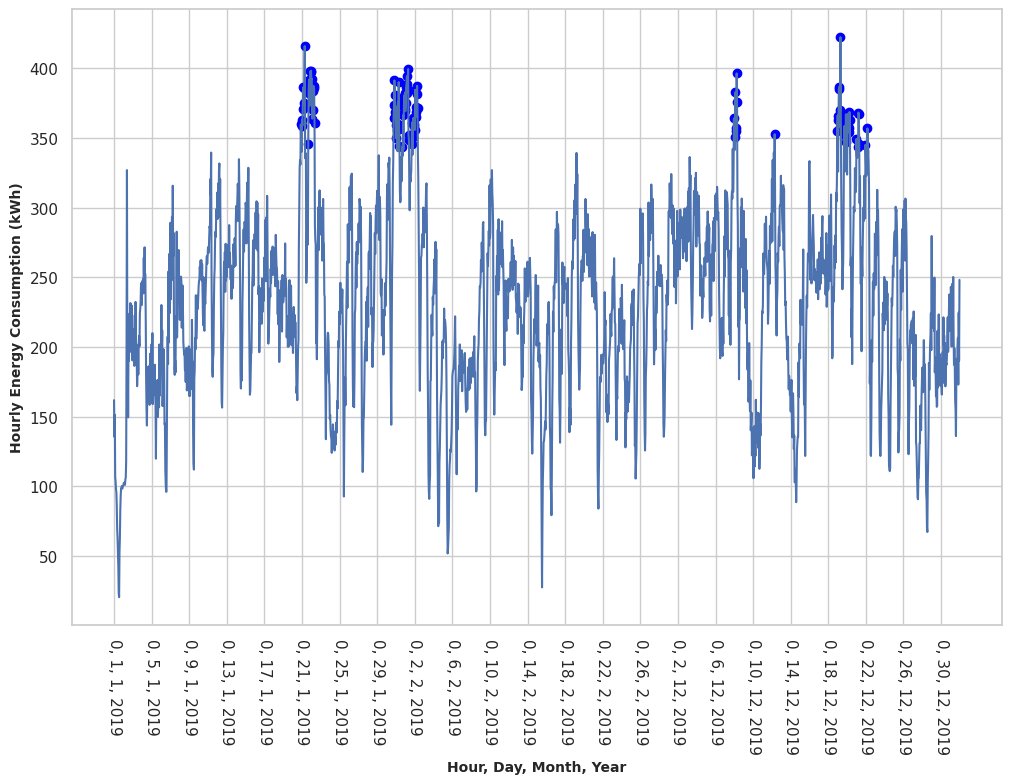

In [ ]:
# Plot the data with anomalies marked in red
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(dc_nn_h_win_19_PPWA['timestamp'], dc_nn_h_win_19_PPWA['EnergyUse'], color='b')
plt.scatter(dc_nn_h_win_19_PPWA['timestamp'][anomalous_nn_h_win_19_PPWA], dc_nn_h_win_19_PPWA['EnergyUse'][anomalous_nn_h_win_19_PPWA], marker='o', color='blue')
plt.xlabel('Hour, Day, Month, Year', fontweight ='bold', fontsize = 10)
plt.ylabel('Hourly Energy Consumption (kWh)', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 2160, 96))
plt.tick_params(axis ='x', rotation = -90)
plt.show()

In [ ]:
# Isolate the anomalous values
anomalous_nn_h_win_19_PPWA_true = dc_nn_h_win_19_PPWA[anomalous_nn_h_win_19_PPWA]

anomalous_nn_h_win_19_PPWA_weather = b1_hourly_win_19[anomalous_nn_h_win_19_PPWA]

anomalous_nn_h_win_19_PPWA_weather = anomalous_nn_h_win_19_PPWA_weather[['Hour', 'Day', 'Month', 'Year', 'EnergyUse', 'Temp', 'RelHum', 'Humidity', 'UVIndex']]
print(anomalous_nn_h_win_19_PPWA_weather)

     Hour Day Month  Year EnergyUse  Temp RelHum Humidity UVIndex
477    21  20     1  2019     359.8  17.9    4.9    56.18       0
480     0  21     1  2019    362.88  15.1    0.0    50.44       0
481     1  21     1  2019    358.96  13.9   -1.0     50.8       0
482     2  21     1  2019     371.0  12.7   -2.9    48.94       0
483     3  21     1  2019     386.4  11.8   -3.1    50.56       0
...   ...  ..   ...   ...       ...   ...    ...      ...     ...
8501    5  21    12  2019    368.34  20.9   12.8    70.55       0
8502    6  21    12  2019    367.08  20.0   12.8    73.24       0
8503    7  21    12  2019    345.66  20.1   12.8    73.12       0
8519   23  21    12  2019    345.24  24.1   19.1     81.1       0
8524    4  22    12  2019     357.0  20.0   17.0    87.69       0

[108 rows x 9 columns]


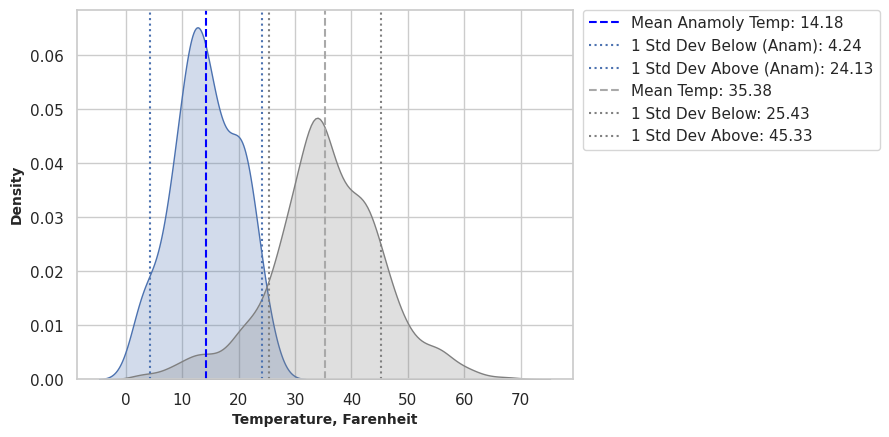

In [ ]:
# Visualize distrubution of anamolous temperatures
anamalous_temp_nn_h_win_19_mean = np.mean(anomalous_nn_h_win_19_PPWA_weather['Temp'])
anamalous_temp_nn_h_win_19_std_dev = np.std(anomalous_nn_h_win_19_PPWA_weather['Temp'])

temp_nn_h_win_19_mean = np.mean(b1_hourly_win_19['Temp'])
temp_nn_h_win_19_std_dev = np.std(b1_hourly_win_19['Temp'])

sns.set(style='whitegrid')
sns.kdeplot(anomalous_nn_h_win_19_PPWA_weather['Temp'], fill=True, color="b")
plt.axvline(anamalous_temp_nn_h_win_19_mean, color='blue', linestyle='--', label=f'Mean Anamoly Temp: {anamalous_temp_nn_h_win_19_mean:.2f}')
plt.axvline(anamalous_temp_nn_h_win_19_mean - temp_nn_h_win_19_std_dev, color='b', linestyle=':', label=f'1 Std Dev Below (Anam): {anamalous_temp_nn_h_win_19_mean - temp_nn_h_win_19_std_dev:.2f}')
plt.axvline(anamalous_temp_nn_h_win_19_mean + temp_nn_h_win_19_std_dev, color='b', linestyle=':', label=f'1 Std Dev Above (Anam): {anamalous_temp_nn_h_win_19_mean + temp_nn_h_win_19_std_dev:.2f}')

sns.kdeplot(b1_hourly_win_19['Temp'], fill=True, color="grey")
plt.axvline(temp_nn_h_win_19_mean, color='darkgrey', linestyle='--', label=f'Mean Temp: {temp_nn_h_win_19_mean:.2f}')
plt.axvline(temp_nn_h_win_19_mean - temp_nn_h_win_19_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Below: {temp_nn_h_win_19_mean - temp_nn_h_win_19_std_dev:.2f}')
plt.axvline(temp_nn_h_win_19_mean + temp_nn_h_win_19_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Above: {temp_nn_h_win_19_mean + temp_nn_h_win_19_std_dev:.2f}')

plt.xlabel('Temperature, Farenheit', fontweight ='bold', fontsize = 10)
plt.ylabel('Density', fontweight ='bold', fontsize = 10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

In [ ]:
# 2019 Spring:
# Exclude datetime column
dt_nn_h_spr_19_PPWA = tf.convert_to_tensor(dc_nn_h_spr_19_PPWA.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# Define the autoencoder model
input_dim_nn_h_spr_19_PPWA = dc_nn_h_spr_19_PPWA.shape[1] - 1
encoding_dim_nn_h_spr_19_PPWA = 10

input_layer_nn_h_spr_19_PPWA = Input(shape=(input_dim_nn_h_spr_19_PPWA,))
encoder_nn_h_spr_19_PPWA = Dense(encoding_dim_nn_h_spr_19_PPWA, activation='relu')(input_layer_nn_h_spr_19_PPWA)
decoder_nn_h_spr_19_PPWA = Dense(input_dim_nn_h_spr_19_PPWA, activation='relu')(encoder_nn_h_spr_19_PPWA)
autoencoder_nn_h_spr_19_PPWA = Model(inputs=input_layer_nn_h_spr_19_PPWA, outputs=decoder_nn_h_spr_19_PPWA)

# Compile and fit the model
autoencoder_nn_h_spr_19_PPWA.compile(optimizer='adam', loss='mae')
autoencoder_nn_h_spr_19_PPWA.fit(dt_nn_h_spr_19_PPWA, dt_nn_h_spr_19_PPWA, epochs=30,
				batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions_nn_h_spr_19_PPWA = autoencoder_nn_h_spr_19_PPWA.predict(dt_nn_h_spr_19_PPWA)
mae_nn_h_spr_19_PPWA = tf.reduce_mean(tf.square(dt_nn_h_spr_19_PPWA - reconstructions_nn_h_spr_19_PPWA),
					axis=1)
anomaly_scores_nn_h_spr_19_PPWA = pd.Series(mae_nn_h_spr_19_PPWA.numpy(), name='anomaly_scores')
anomaly_scores_nn_h_spr_19_PPWA.index = dc_nn_h_spr_19_PPWA.index



Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 124.6261
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 104.4525
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82.8518
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58.8789
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.4267
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9022
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3493
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3079
Epoch 9/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2775
Epoch 10/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2377
Epoch 11/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1941
Epoch 12/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1590
Epoch 13/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1189
Epoch 14/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0845
Epoch 15/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0392
Epoch 16/30


Precision:  1.0
Recall:  1.0
F1 Score:  1.0


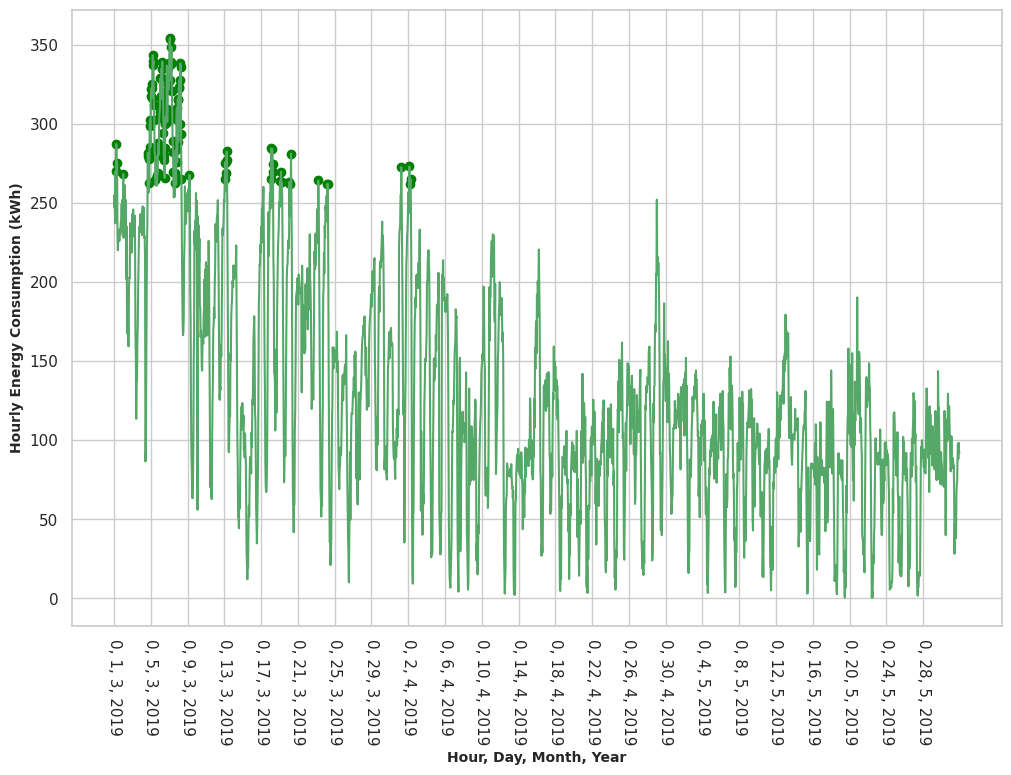

     Hour Day Month  Year EnergyUse  Temp RelHum Humidity UVIndex
1420    4   1     3  2019    269.92  32.7   14.3    46.22       0
1422    6   1     3  2019    287.28  27.9   23.1    81.79       0
1424    8   1     3  2019    275.52  28.0   23.1    81.43       0
1440    0   2     3  2019    268.24  34.8   30.0    82.52       0
1504   16   4     3  2019    281.68  36.0   19.2     50.2       2
...   ...  ..   ...   ...       ...   ...    ...      ...     ...
1974    6  24     3  2019    262.08  34.8   14.0    41.96       0
2166    6   1     4  2019    272.58  29.9   12.7    48.27       0
2187    3   2     4  2019     273.0  29.7   17.2    59.19       0
2189    5   2     4  2019    262.08  28.7   18.0    63.87       0
2190    6   2     4  2019    265.02  28.7   19.1     66.9       0

[111 rows x 9 columns]


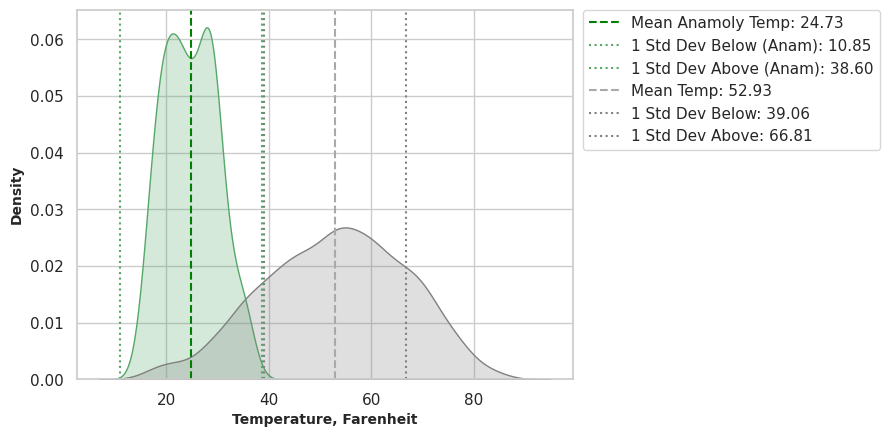

In [ ]:
threshold_nn_h_spr_19_PPWA = anomaly_scores_nn_h_spr_19_PPWA.quantile(0.95)
anomalous_nn_h_spr_19_PPWA = anomaly_scores_nn_h_spr_19_PPWA > threshold_nn_h_spr_19_PPWA
binary_labels_nn_h_spr_19_PPWA = anomalous_nn_h_spr_19_PPWA.astype(int)
precision_nn_h_spr_19_PPWA, recall_nn_h_spr_19_PPWA, f1_score_nn_h_spr_19_PPWA, _ = precision_recall_fscore_support(binary_labels_nn_h_spr_19_PPWA, anomalous_nn_h_spr_19_PPWA, average='binary')

test_nn_h_spr_19_PPWA = dc_nn_h_spr_19_PPWA['EnergyUse'].values
predictions_nn_h_spr_19_PPWA = anomaly_scores_nn_h_spr_19_PPWA.values

print("Precision: ", precision_nn_h_spr_19_PPWA)
print("Recall: ", recall_nn_h_spr_19_PPWA)
print("F1 Score: ", f1_score_nn_h_spr_19_PPWA)

# Plot the data with anomalies marked in red
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(dc_nn_h_spr_19_PPWA['timestamp'], dc_nn_h_spr_19_PPWA['EnergyUse'], color='g')
plt.scatter(dc_nn_h_spr_19_PPWA['timestamp'][anomalous_nn_h_spr_19_PPWA], dc_nn_h_spr_19_PPWA['EnergyUse'][anomalous_nn_h_spr_19_PPWA], marker='o', color='green')
plt.xlabel('Hour, Day, Month, Year', fontweight ='bold', fontsize = 10)
plt.ylabel('Hourly Energy Consumption (kWh)', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 2160, 96))
plt.tick_params(axis ='x', rotation = -90)
plt.show()

# Isolate the anomalous values
anomalous_nn_h_spr_19_PPWA_true = dc_nn_h_spr_19_PPWA[anomalous_nn_h_spr_19_PPWA]

anomalous_nn_h_spr_19_PPWA_weather = b1_hourly_spr_19[anomalous_nn_h_spr_19_PPWA]

anomalous_nn_h_spr_19_PPWA_weather = anomalous_nn_h_spr_19_PPWA_weather[['Hour', 'Day', 'Month', 'Year', 'EnergyUse', 'Temp', 'RelHum', 'Humidity', 'UVIndex']]
print(anomalous_nn_h_spr_19_PPWA_weather)

# Visualize distrubution of anamolous temperatures
anamalous_temp_nn_h_spr_19_mean = np.mean(anomalous_nn_h_spr_19_PPWA_weather['Temp'])
anamalous_temp_nn_h_spr_19_std_dev = np.std(anomalous_nn_h_spr_19_PPWA_weather['Temp'])

temp_nn_h_spr_19_mean = np.mean(b1_hourly_spr_19['Temp'])
temp_nn_h_spr_19_std_dev = np.std(b1_hourly_spr_19['Temp'])

sns.set(style='whitegrid')
sns.kdeplot(anomalous_nn_h_spr_19_PPWA_weather['Temp'], fill=True, color="g")
plt.axvline(anamalous_temp_nn_h_spr_19_mean, color='green', linestyle='--', label=f'Mean Anamoly Temp: {anamalous_temp_nn_h_spr_19_mean:.2f}')
plt.axvline(anamalous_temp_nn_h_spr_19_mean - temp_nn_h_spr_19_std_dev, color='g', linestyle=':', label=f'1 Std Dev Below (Anam): {anamalous_temp_nn_h_spr_19_mean - temp_nn_h_spr_19_std_dev:.2f}')
plt.axvline(anamalous_temp_nn_h_spr_19_mean + temp_nn_h_spr_19_std_dev, color='g', linestyle=':', label=f'1 Std Dev Above (Anam): {anamalous_temp_nn_h_spr_19_mean + temp_nn_h_spr_19_std_dev:.2f}')

sns.kdeplot(b1_hourly_spr_19['Temp'], fill=True, color="grey")
plt.axvline(temp_nn_h_spr_19_mean, color='darkgrey', linestyle='--', label=f'Mean Temp: {temp_nn_h_spr_19_mean:.2f}')
plt.axvline(temp_nn_h_spr_19_mean - temp_nn_h_spr_19_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Below: {temp_nn_h_spr_19_mean - temp_nn_h_spr_19_std_dev:.2f}')
plt.axvline(temp_nn_h_spr_19_mean + temp_nn_h_spr_19_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Above: {temp_nn_h_spr_19_mean + temp_nn_h_spr_19_std_dev:.2f}')

plt.xlabel('Temperature, Farenheit', fontweight ='bold', fontsize = 10)
plt.ylabel('Density', fontweight ='bold', fontsize = 10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

In [ ]:
# 2019 Summer:
# Exclude datetime column
dt_nn_h_sum_19_PPWA = tf.convert_to_tensor(dc_nn_h_sum_19_PPWA.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# Define the autoencoder model
input_dim_nn_h_sum_19_PPWA = dc_nn_h_sum_19_PPWA.shape[1] - 1
encoding_dim_nn_h_sum_19_PPWA = 10

input_layer_nn_h_sum_19_PPWA = Input(shape=(input_dim_nn_h_sum_19_PPWA,))
encoder_nn_h_sum_19_PPWA = Dense(encoding_dim_nn_h_sum_19_PPWA, activation='relu')(input_layer_nn_h_sum_19_PPWA)
decoder_nn_h_sum_19_PPWA = Dense(input_dim_nn_h_sum_19_PPWA, activation='relu')(encoder_nn_h_sum_19_PPWA)
autoencoder_nn_h_sum_19_PPWA = Model(inputs=input_layer_nn_h_sum_19_PPWA, outputs=decoder_nn_h_sum_19_PPWA)

# Compile and fit the model
autoencoder_nn_h_sum_19_PPWA.compile(optimizer='adam', loss='mae')
autoencoder_nn_h_sum_19_PPWA.fit(dt_nn_h_sum_19_PPWA, dt_nn_h_sum_19_PPWA, epochs=30,
				batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions_nn_h_sum_19_PPWA = autoencoder_nn_h_sum_19_PPWA.predict(dt_nn_h_sum_19_PPWA)
mae_nn_h_sum_19_PPWA = tf.reduce_mean(tf.square(dt_nn_h_sum_19_PPWA - reconstructions_nn_h_sum_19_PPWA),
					axis=1)
anomaly_scores_nn_h_sum_19_PPWA = pd.Series(mae_nn_h_sum_19_PPWA.numpy(), name='anomaly_scores')
anomaly_scores_nn_h_sum_19_PPWA.index = dc_nn_h_sum_19_PPWA.index

Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 50.5378
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.7462
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2940
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1061
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0970
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0634
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0400
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0463
Epoch 9/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0558
Epoch 10/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1170
Epoch 11/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0718
Epoch 12/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0434
Epoch 13/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0927
Epoch 14/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0503
Epoch 15/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0464
Epoch 16/30
69/69

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


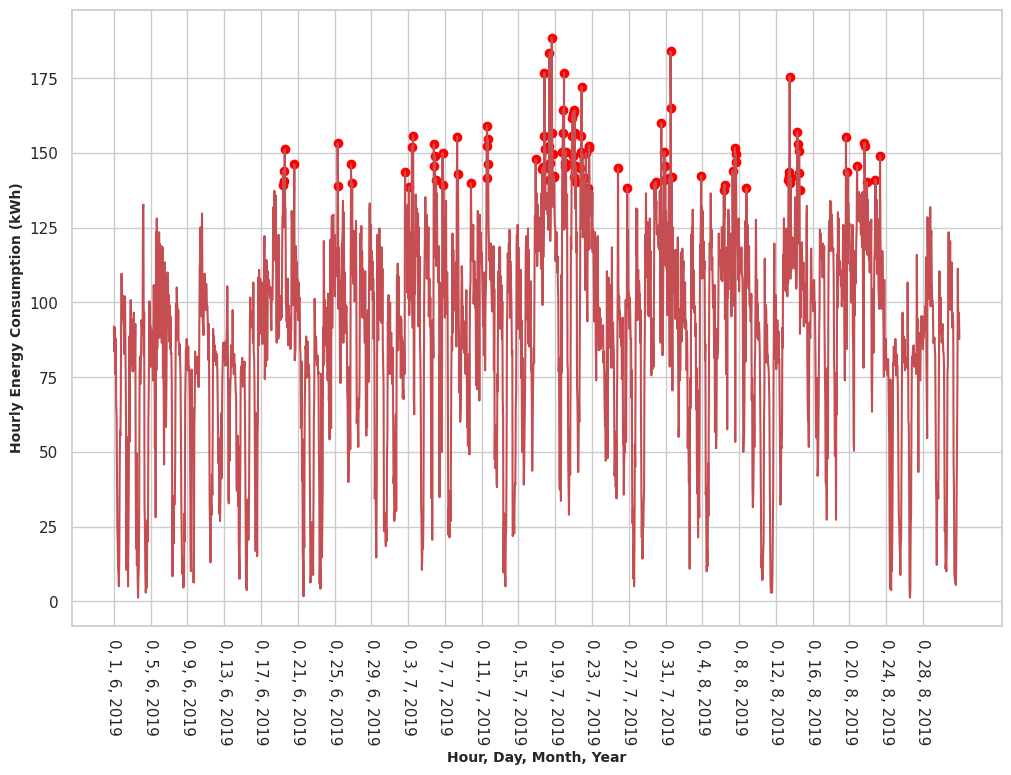

     Hour Day Month  Year EnergyUse  Temp RelHum Humidity UVIndex
4066   10  19     6  2019    139.44  72.0   70.0    93.38       2
4067   11  19     6  2019    144.06  72.2   69.2    90.35       2
4069   13  19     6  2019     140.7  72.3   70.1    92.77       1
4070   14  19     6  2019     151.2  73.1   71.0    93.16       1
4095   15  20     6  2019    146.16  77.2   74.0    89.97       0
...   ...  ..   ...   ...       ...   ...    ...      ...     ...
5583   15  21     8  2019     153.3  87.4   71.0    58.35       2
5584   16  21     8  2019    152.46  88.1   70.1    55.51       1
5590   22  21     8  2019    140.28  74.1   73.0    96.58       0
5612   20  22     8  2019    141.12  82.5   68.3    62.26       0
5624    8  23     8  2019     149.1  65.2   61.1    86.47       0

[111 rows x 9 columns]


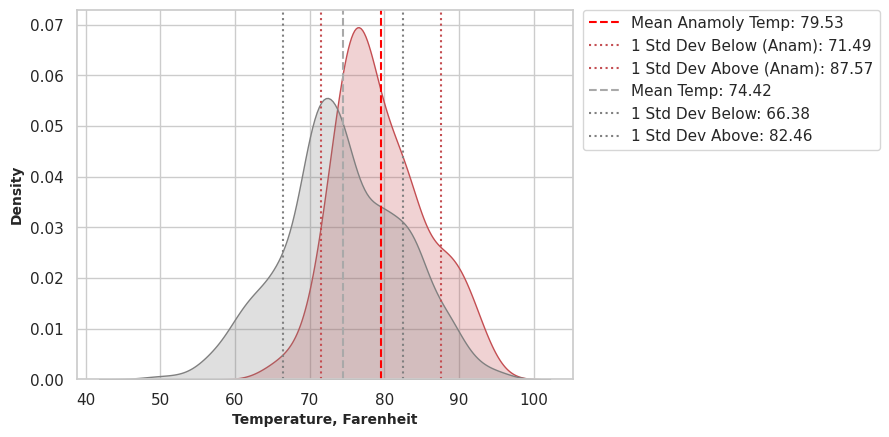

In [ ]:
threshold_nn_h_sum_19_PPWA = anomaly_scores_nn_h_sum_19_PPWA.quantile(0.95)
anomalous_nn_h_sum_19_PPWA = anomaly_scores_nn_h_sum_19_PPWA > threshold_nn_h_sum_19_PPWA
binary_labels_nn_h_sum_19_PPWA = anomalous_nn_h_sum_19_PPWA.astype(int)
precision_nn_h_sum_19_PPWA, recall_nn_h_sum_19_PPWA, f1_score_nn_h_sum_19_PPWA, _ = precision_recall_fscore_support(binary_labels_nn_h_sum_19_PPWA, anomalous_nn_h_sum_19_PPWA, average='binary')

test_nn_h_sum_19_PPWA = dc_nn_h_sum_19_PPWA['EnergyUse'].values
predictions_nn_h_sum_19_PPWA = anomaly_scores_nn_h_sum_19_PPWA.values

print("Precision: ", precision_nn_h_sum_19_PPWA)
print("Recall: ", recall_nn_h_sum_19_PPWA)
print("F1 Score: ", f1_score_nn_h_sum_19_PPWA)

# Plot the data with anomalies marked in red
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(dc_nn_h_sum_19_PPWA['timestamp'], dc_nn_h_sum_19_PPWA['EnergyUse'], color='r')
plt.scatter(dc_nn_h_sum_19_PPWA['timestamp'][anomalous_nn_h_sum_19_PPWA], dc_nn_h_sum_19_PPWA['EnergyUse'][anomalous_nn_h_sum_19_PPWA], marker='o', color='red')
plt.xlabel('Hour, Day, Month, Year', fontweight ='bold', fontsize = 10)
plt.ylabel('Hourly Energy Consumption (kWh)', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 2160, 96))
plt.tick_params(axis ='x', rotation = -90)
plt.show()

# Isolate the anomalous values
anomalous_nn_h_sum_19_PPWA_true = dc_nn_h_sum_19_PPWA[anomalous_nn_h_sum_19_PPWA]

anomalous_nn_h_sum_19_PPWA_weather = b1_hourly_sum_19[anomalous_nn_h_sum_19_PPWA]

anomalous_nn_h_sum_19_PPWA_weather = anomalous_nn_h_sum_19_PPWA_weather[['Hour', 'Day', 'Month', 'Year', 'EnergyUse', 'Temp', 'RelHum', 'Humidity', 'UVIndex']]
print(anomalous_nn_h_sum_19_PPWA_weather)

# Visualize distrubution of anamolous temperatures
anamalous_temp_nn_h_sum_19_mean = np.mean(anomalous_nn_h_sum_19_PPWA_weather['Temp'])
anamalous_temp_nn_h_sum_19_std_dev = np.std(anomalous_nn_h_sum_19_PPWA_weather['Temp'])

temp_nn_h_sum_19_mean = np.mean(b1_hourly_sum_19['Temp'])
temp_nn_h_sum_19_std_dev = np.std(b1_hourly_sum_19['Temp'])

sns.set(style='whitegrid')
sns.kdeplot(anomalous_nn_h_sum_19_PPWA_weather['Temp'], fill=True, color="r")
plt.axvline(anamalous_temp_nn_h_sum_19_mean, color='red', linestyle='--', label=f'Mean Anamoly Temp: {anamalous_temp_nn_h_sum_19_mean:.2f}')
plt.axvline(anamalous_temp_nn_h_sum_19_mean - temp_nn_h_sum_19_std_dev, color='r', linestyle=':', label=f'1 Std Dev Below (Anam): {anamalous_temp_nn_h_sum_19_mean - temp_nn_h_sum_19_std_dev:.2f}')
plt.axvline(anamalous_temp_nn_h_sum_19_mean + temp_nn_h_sum_19_std_dev, color='r', linestyle=':', label=f'1 Std Dev Above (Anam): {anamalous_temp_nn_h_sum_19_mean + temp_nn_h_sum_19_std_dev:.2f}')

sns.kdeplot(b1_hourly_sum_19['Temp'], fill=True, color="grey")
plt.axvline(temp_nn_h_sum_19_mean, color='darkgrey', linestyle='--', label=f'Mean Temp: {temp_nn_h_sum_19_mean:.2f}')
plt.axvline(temp_nn_h_sum_19_mean - temp_nn_h_sum_19_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Below: {temp_nn_h_sum_19_mean - temp_nn_h_sum_19_std_dev:.2f}')
plt.axvline(temp_nn_h_sum_19_mean + temp_nn_h_sum_19_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Above: {temp_nn_h_sum_19_mean + temp_nn_h_sum_19_std_dev:.2f}')

plt.xlabel('Temperature, Farenheit', fontweight ='bold', fontsize = 10)
plt.ylabel('Density', fontweight ='bold', fontsize = 10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

In [ ]:
# 2019 Fall:
# Exclude datetime column
dt_nn_h_fal_19_PPWA = tf.convert_to_tensor(dc_nn_h_fal_19_PPWA.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# Define the autoencoder model
input_dim_nn_h_fal_19_PPWA = dc_nn_h_fal_19_PPWA.shape[1] - 1
encoding_dim_nn_h_fal_19_PPWA = 10

input_layer_nn_h_fal_19_PPWA = Input(shape=(input_dim_nn_h_fal_19_PPWA,))
encoder_nn_h_fal_19_PPWA = Dense(encoding_dim_nn_h_fal_19_PPWA, activation='relu')(input_layer_nn_h_fal_19_PPWA)
decoder_nn_h_fal_19_PPWA = Dense(input_dim_nn_h_fal_19_PPWA, activation='relu')(encoder_nn_h_fal_19_PPWA)
autoencoder_nn_h_fal_19_PPWA = Model(inputs=input_layer_nn_h_fal_19_PPWA, outputs=decoder_nn_h_fal_19_PPWA)

# Compile and fit the model
autoencoder_nn_h_fal_19_PPWA.compile(optimizer='adam', loss='mae')
autoencoder_nn_h_fal_19_PPWA.fit(dt_nn_h_fal_19_PPWA, dt_nn_h_fal_19_PPWA, epochs=30,
				batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions_nn_h_fal_19_PPWA = autoencoder_nn_h_fal_19_PPWA.predict(dt_nn_h_fal_19_PPWA)
mae_nn_h_fal_19_PPWA = tf.reduce_mean(tf.square(dt_nn_h_fal_19_PPWA - reconstructions_nn_h_fal_19_PPWA),
					axis=1)
anomaly_scores_nn_h_fal_19_PPWA = pd.Series(mae_nn_h_fal_19_PPWA.numpy(), name='anomaly_scores')
anomaly_scores_nn_h_fal_19_PPWA.index = dc_nn_h_fal_19_PPWA.index

Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 119.0170
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119.3943
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 120.7236
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119.3795
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121.2285
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119.8827
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 123.2618
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 122.2374
Epoch 9/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 122.5127
Epoch 10/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119.1520
Epoch 11/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119.5295
Epoch 12/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121.2914
Epoch 13/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 120.8581
Epoch 14/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 122.3863
Epoch 15/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


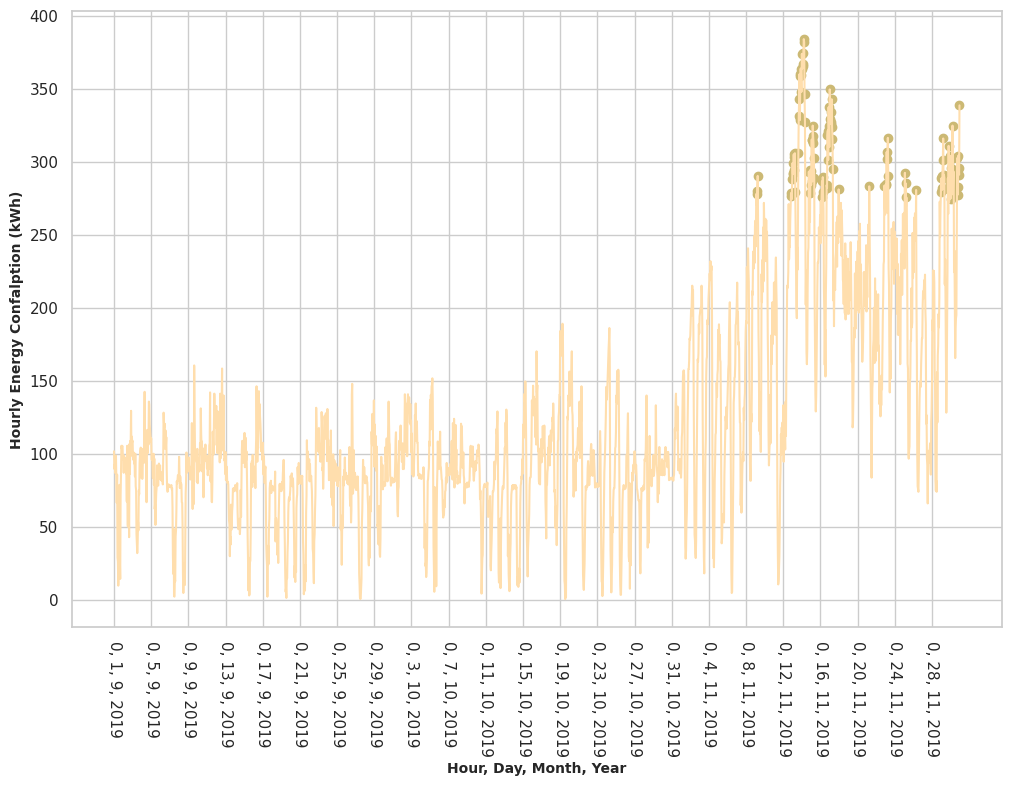

     Hour Day Month  Year EnergyUse  Temp RelHum Humidity UVIndex
7491    3   9    11  2019    278.04  24.9   15.2    66.21       0
7493    5   9    11  2019    279.72  22.9   15.2    72.02       0
7494    6   9    11  2019    290.22  22.8   15.2    72.14       0
7580   20  12    11  2019    278.46  28.2    8.5    43.06       0
7581   21  12    11  2019    276.36  26.1    8.0    45.67       0
...   ...  ..   ...   ...       ...   ...    ...      ...     ...
8011   19  30    11  2019    282.66  35.9   16.3    44.31       0
8012   20  30    11  2019    304.08  35.0   17.3    48.06       0
8013   21  30    11  2019    295.68  32.2   18.0    55.34       0
8014   22  30    11  2019    291.06  31.9   19.1    58.65       0
8015   23  30    11  2019    338.52  30.7   18.0    58.95       0

[109 rows x 9 columns]


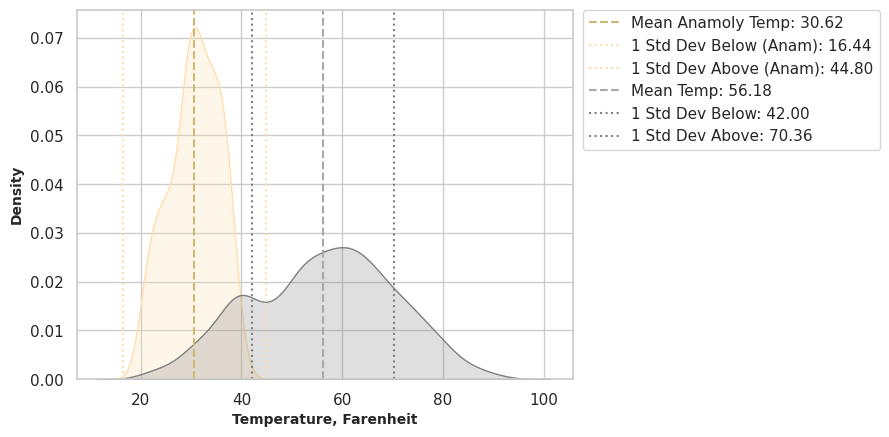

In [ ]:
threshold_nn_h_fal_19_PPWA = anomaly_scores_nn_h_fal_19_PPWA.quantile(0.95)
anomalous_nn_h_fal_19_PPWA = anomaly_scores_nn_h_fal_19_PPWA > threshold_nn_h_fal_19_PPWA
binary_labels_nn_h_fal_19_PPWA = anomalous_nn_h_fal_19_PPWA.astype(int)
precision_nn_h_fal_19_PPWA, recall_nn_h_fal_19_PPWA, f1_score_nn_h_fal_19_PPWA, _ = precision_recall_fscore_support(binary_labels_nn_h_fal_19_PPWA, anomalous_nn_h_fal_19_PPWA, average='binary')

test_nn_h_fal_19_PPWA = dc_nn_h_fal_19_PPWA['EnergyUse'].values
predictions_nn_h_fal_19_PPWA = anomaly_scores_nn_h_fal_19_PPWA.values

print("Precision: ", precision_nn_h_fal_19_PPWA)
print("Recall: ", recall_nn_h_fal_19_PPWA)
print("F1 Score: ", f1_score_nn_h_fal_19_PPWA)

# Plot the data with anomalies marked in red
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(dc_nn_h_fal_19_PPWA['timestamp'], dc_nn_h_fal_19_PPWA['EnergyUse'], color='navajowhite')
plt.scatter(dc_nn_h_fal_19_PPWA['timestamp'][anomalous_nn_h_fal_19_PPWA], dc_nn_h_fal_19_PPWA['EnergyUse'][anomalous_nn_h_fal_19_PPWA], marker='o', color='y')
plt.xlabel('Hour, Day, Month, Year', fontweight ='bold', fontsize = 10)
plt.ylabel('Hourly Energy Confalption (kWh)', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 2160, 96))
plt.tick_params(axis ='x', rotation = -90)
plt.show()

# Isolate the anomalous values
anomalous_nn_h_fal_19_PPWA_true = dc_nn_h_fal_19_PPWA[anomalous_nn_h_fal_19_PPWA]

anomalous_nn_h_fal_19_PPWA_weather = b1_hourly_fal_19[anomalous_nn_h_fal_19_PPWA]

anomalous_nn_h_fal_19_PPWA_weather = anomalous_nn_h_fal_19_PPWA_weather[['Hour', 'Day', 'Month', 'Year', 'EnergyUse', 'Temp', 'RelHum', 'Humidity', 'UVIndex']]
print(anomalous_nn_h_fal_19_PPWA_weather)

# Visualize distrubution of anamolous temperatures
anamalous_temp_nn_h_fal_19_mean = np.mean(anomalous_nn_h_fal_19_PPWA_weather['Temp'])
anamalous_temp_nn_h_fal_19_std_dev = np.std(anomalous_nn_h_fal_19_PPWA_weather['Temp'])

temp_nn_h_fal_19_mean = np.mean(b1_hourly_fal_19['Temp'])
temp_nn_h_fal_19_std_dev = np.std(b1_hourly_fal_19['Temp'])

sns.set(style='whitegrid')
sns.kdeplot(anomalous_nn_h_fal_19_PPWA_weather['Temp'], fill=True, color="navajowhite")
plt.axvline(anamalous_temp_nn_h_fal_19_mean, color='y', linestyle='--', label=f'Mean Anamoly Temp: {anamalous_temp_nn_h_fal_19_mean:.2f}')
plt.axvline(anamalous_temp_nn_h_fal_19_mean - temp_nn_h_fal_19_std_dev, color='navajowhite', linestyle=':', label=f'1 Std Dev Below (Anam): {anamalous_temp_nn_h_fal_19_mean - temp_nn_h_fal_19_std_dev:.2f}')
plt.axvline(anamalous_temp_nn_h_fal_19_mean + temp_nn_h_fal_19_std_dev, color='navajowhite', linestyle=':', label=f'1 Std Dev Above (Anam): {anamalous_temp_nn_h_fal_19_mean + temp_nn_h_fal_19_std_dev:.2f}')

sns.kdeplot(b1_hourly_fal_19['Temp'], fill=True, color="grey")
plt.axvline(temp_nn_h_fal_19_mean, color='darkgrey', linestyle='--', label=f'Mean Temp: {temp_nn_h_fal_19_mean:.2f}')
plt.axvline(temp_nn_h_fal_19_mean - temp_nn_h_fal_19_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Below: {temp_nn_h_fal_19_mean - temp_nn_h_fal_19_std_dev:.2f}')
plt.axvline(temp_nn_h_fal_19_mean + temp_nn_h_fal_19_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Above: {temp_nn_h_fal_19_mean + temp_nn_h_fal_19_std_dev:.2f}')

plt.xlabel('Temperature, Farenheit', fontweight ='bold', fontsize = 10)
plt.ylabel('Density', fontweight ='bold', fontsize = 10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# ^ Fitting (2020 All Seasons)

In [ ]:
# 2020 Winter:
# Exclude datetime column
dt_nn_h_win_20_PPWA = tf.convert_to_tensor(dc_nn_h_win_20_PPWA.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# Define the autoencoder model
input_dim_nn_h_win_20_PPWA = dc_nn_h_win_20_PPWA.shape[1] - 1
encoding_dim_nn_h_win_20_PPWA = 10

input_layer_nn_h_win_20_PPWA = Input(shape=(input_dim_nn_h_win_20_PPWA,))
encoder_nn_h_win_20_PPWA = Dense(encoding_dim_nn_h_win_20_PPWA, activation='relu')(input_layer_nn_h_win_20_PPWA)
decoder_nn_h_win_20_PPWA = Dense(input_dim_nn_h_win_20_PPWA, activation='relu')(encoder_nn_h_win_20_PPWA)
autoencoder_nn_h_win_20_PPWA = Model(inputs=input_layer_nn_h_win_20_PPWA, outputs=decoder_nn_h_win_20_PPWA)

# Compile and fit the model
autoencoder_nn_h_win_20_PPWA.compile(optimizer='adam', loss='mae')
autoencoder_nn_h_win_20_PPWA.fit(dt_nn_h_win_20_PPWA, dt_nn_h_win_20_PPWA, epochs=30,
				batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions_nn_h_win_20_PPWA = autoencoder_nn_h_win_20_PPWA.predict(dt_nn_h_win_20_PPWA)
mae_nn_h_win_20_PPWA = tf.reduce_mean(tf.square(dt_nn_h_win_20_PPWA - reconstructions_nn_h_win_20_PPWA),
					axis=1)
anomaly_scores_nn_h_win_20_PPWA = pd.Series(mae_nn_h_win_20_PPWA.numpy(), name='anomaly_scores')
anomaly_scores_nn_h_win_20_PPWA.index = dc_nn_h_win_20_PPWA.index

# 2020 Spring:
# Exclude datetime column
dt_nn_h_spr_20_PPWA = tf.convert_to_tensor(dc_nn_h_spr_20_PPWA.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# Define the autoencoder model
input_dim_nn_h_spr_20_PPWA = dc_nn_h_spr_20_PPWA.shape[1] - 1
encoding_dim_nn_h_spr_20_PPWA = 10

input_layer_nn_h_spr_20_PPWA = Input(shape=(input_dim_nn_h_spr_20_PPWA,))
encoder_nn_h_spr_20_PPWA = Dense(encoding_dim_nn_h_spr_20_PPWA, activation='relu')(input_layer_nn_h_spr_20_PPWA)
decoder_nn_h_spr_20_PPWA = Dense(input_dim_nn_h_spr_20_PPWA, activation='relu')(encoder_nn_h_spr_20_PPWA)
autoencoder_nn_h_spr_20_PPWA = Model(inputs=input_layer_nn_h_spr_20_PPWA, outputs=decoder_nn_h_spr_20_PPWA)

# Compile and fit the model
autoencoder_nn_h_spr_20_PPWA.compile(optimizer='adam', loss='mae')
autoencoder_nn_h_spr_20_PPWA.fit(dt_nn_h_spr_20_PPWA, dt_nn_h_spr_20_PPWA, epochs=30,
				batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions_nn_h_spr_20_PPWA = autoencoder_nn_h_spr_20_PPWA.predict(dt_nn_h_spr_20_PPWA)
mae_nn_h_spr_20_PPWA = tf.reduce_mean(tf.square(dt_nn_h_spr_20_PPWA - reconstructions_nn_h_spr_20_PPWA),
					axis=1)
anomaly_scores_nn_h_spr_20_PPWA = pd.Series(mae_nn_h_spr_20_PPWA.numpy(), name='anomaly_scores')
anomaly_scores_nn_h_spr_20_PPWA.index = dc_nn_h_spr_20_PPWA.index

# 2020 Summer:
# Exclude datetime column
dt_nn_h_sum_20_PPWA = tf.convert_to_tensor(dc_nn_h_sum_20_PPWA.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# Define the autoencoder model
input_dim_nn_h_sum_20_PPWA = dc_nn_h_sum_20_PPWA.shape[1] - 1
encoding_dim_nn_h_sum_20_PPWA = 10

input_layer_nn_h_sum_20_PPWA = Input(shape=(input_dim_nn_h_sum_20_PPWA,))
encoder_nn_h_sum_20_PPWA = Dense(encoding_dim_nn_h_sum_20_PPWA, activation='relu')(input_layer_nn_h_sum_20_PPWA)
decoder_nn_h_sum_20_PPWA = Dense(input_dim_nn_h_sum_20_PPWA, activation='relu')(encoder_nn_h_sum_20_PPWA)
autoencoder_nn_h_sum_20_PPWA = Model(inputs=input_layer_nn_h_sum_20_PPWA, outputs=decoder_nn_h_sum_20_PPWA)

# Compile and fit the model
autoencoder_nn_h_sum_20_PPWA.compile(optimizer='adam', loss='mae')
autoencoder_nn_h_sum_20_PPWA.fit(dt_nn_h_sum_20_PPWA, dt_nn_h_sum_20_PPWA, epochs=30,
				batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions_nn_h_sum_20_PPWA = autoencoder_nn_h_sum_20_PPWA.predict(dt_nn_h_sum_20_PPWA)
mae_nn_h_sum_20_PPWA = tf.reduce_mean(tf.square(dt_nn_h_sum_20_PPWA - reconstructions_nn_h_sum_20_PPWA),
					axis=1)
anomaly_scores_nn_h_sum_20_PPWA = pd.Series(mae_nn_h_sum_20_PPWA.numpy(), name='anomaly_scores')
anomaly_scores_nn_h_sum_20_PPWA.index = dc_nn_h_sum_20_PPWA.index

# 2020 Fall:
# Exclude datetime column
dt_nn_h_fal_20_PPWA = tf.convert_to_tensor(dc_nn_h_fal_20_PPWA.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# Define the autoencoder model
input_dim_nn_h_fal_20_PPWA = dc_nn_h_fal_20_PPWA.shape[1] - 1
encoding_dim_nn_h_fal_20_PPWA = 10

input_layer_nn_h_fal_20_PPWA = Input(shape=(input_dim_nn_h_fal_20_PPWA,))
encoder_nn_h_fal_20_PPWA = Dense(encoding_dim_nn_h_fal_20_PPWA, activation='relu')(input_layer_nn_h_fal_20_PPWA)
decoder_nn_h_fal_20_PPWA = Dense(input_dim_nn_h_fal_20_PPWA, activation='relu')(encoder_nn_h_fal_20_PPWA)
autoencoder_nn_h_fal_20_PPWA = Model(inputs=input_layer_nn_h_fal_20_PPWA, outputs=decoder_nn_h_fal_20_PPWA)

# Compile and fit the model
autoencoder_nn_h_fal_20_PPWA.compile(optimizer='adam', loss='mae')
autoencoder_nn_h_fal_20_PPWA.fit(dt_nn_h_fal_20_PPWA, dt_nn_h_fal_20_PPWA, epochs=30,
				batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions_nn_h_fal_20_PPWA = autoencoder_nn_h_fal_20_PPWA.predict(dt_nn_h_fal_20_PPWA)
mae_nn_h_fal_20_PPWA = tf.reduce_mean(tf.square(dt_nn_h_fal_20_PPWA - reconstructions_nn_h_fal_20_PPWA),
					axis=1)
anomaly_scores_nn_h_fal_20_PPWA = pd.Series(mae_nn_h_fal_20_PPWA.numpy(), name='anomaly_scores')
anomaly_scores_nn_h_fal_20_PPWA.index = dc_nn_h_fal_20_PPWA.index

Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 106.4597
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.1251
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3093
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0979
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0914
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1001
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0975
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0788
Epoch 9/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0630
Epoch 10/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1351
Epoch 11/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0761
Epoch 12/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0497
Epoch 13/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1021
Epoch 14/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1708
Epoch 15/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1179
Epoch 16/30
69/6

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


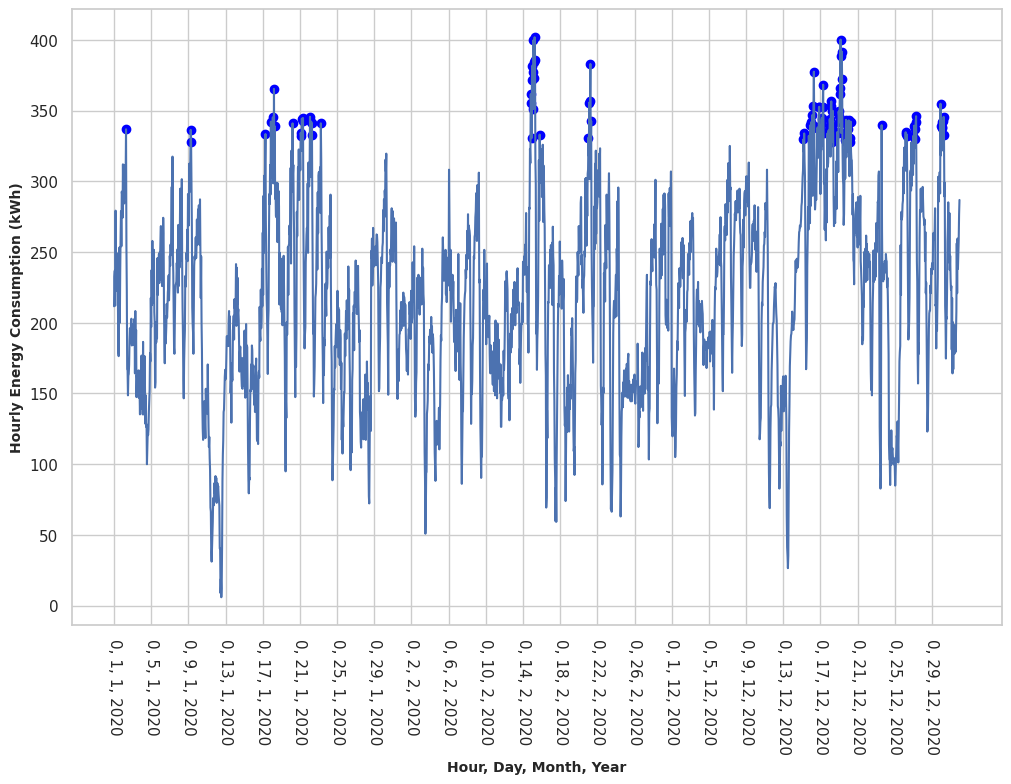

      Hour Day Month  Year EnergyUse  Temp RelHum Humidity UVIndex
8791     7   2     1  2020    336.84  23.2   20.0     87.3       0
8958     6   9     1  2020    336.42  21.9    6.2    50.26       0
8959     7   9     1  2020    328.02  21.0    7.0    54.25       0
9151     7  17     1  2020    333.48  24.2    8.1    49.63       0
9165    21  17     1  2020     342.3  21.9    2.9    43.25       0
...    ...  ..   ...   ...       ...   ...    ...      ...     ...
17498    2  30    12  2020    337.68  24.3   15.2    67.87       0
17499    3  30    12  2020    338.52  25.1   15.1    65.37       0
17500    4  30    12  2020    342.72  23.1   14.3     68.6       0
17502    6  30    12  2020    345.66  25.2   18.0    73.74       0
17503    7  30    12  2020    333.06  26.1   19.0     74.1       0

[109 rows x 9 columns]


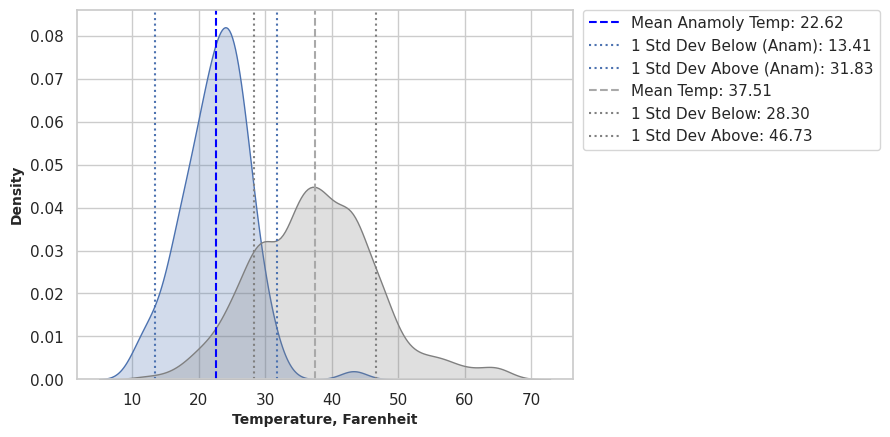

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


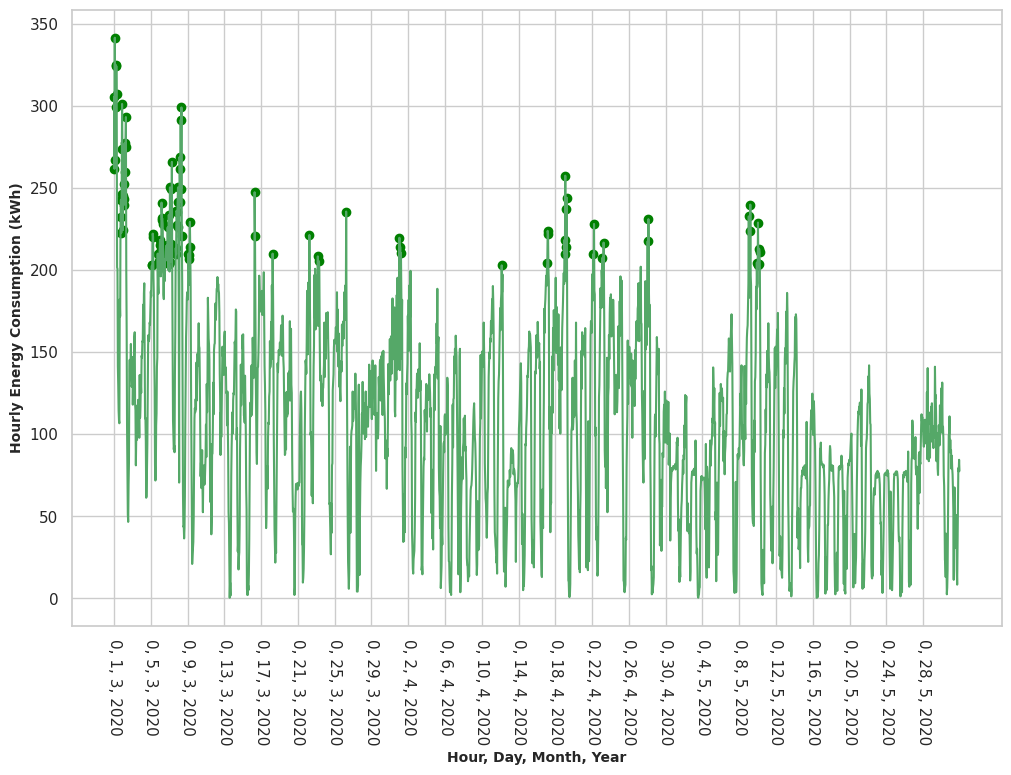

      Hour Day Month  Year EnergyUse  Temp RelHum Humidity UVIndex
10200    0   1     3  2020    305.34  28.2   10.2    46.29       0
10201    1   1     3  2020    261.66  28.2   11.2    48.32       0
10202    2   1     3  2020    341.46  26.2   11.1    52.33       0
10203    3   1     3  2020    267.12  26.1   11.9    54.33       0
10204    4   1     3  2020    325.08  24.3   11.9    58.65       0
...    ...  ..   ...   ...       ...   ...    ...      ...     ...
11881    1  10     5  2020     228.9  36.0   20.9    53.68       0
11882    2  10     5  2020    202.86  35.0   21.8    58.15       0
11883    3  10     5  2020     203.7  33.3   21.8    62.51       0
11884    4  10     5  2020    212.94  31.1   21.8    68.13       0
11885    5  10     5  2020    210.84  35.1   23.0    60.85       0

[111 rows x 9 columns]


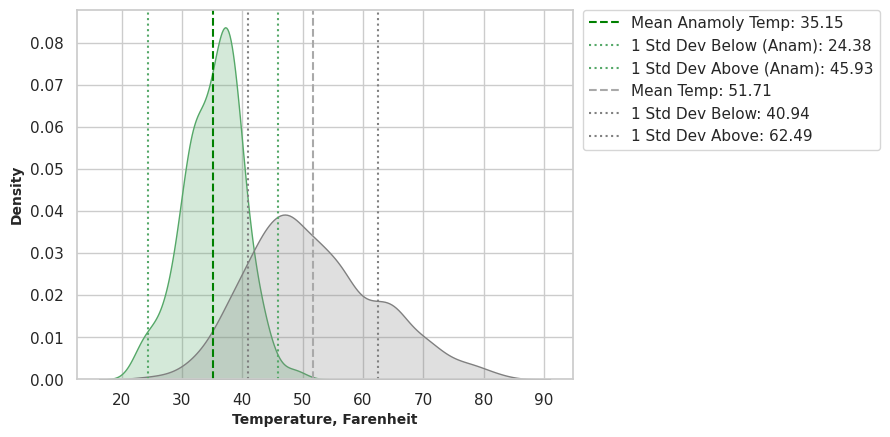

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


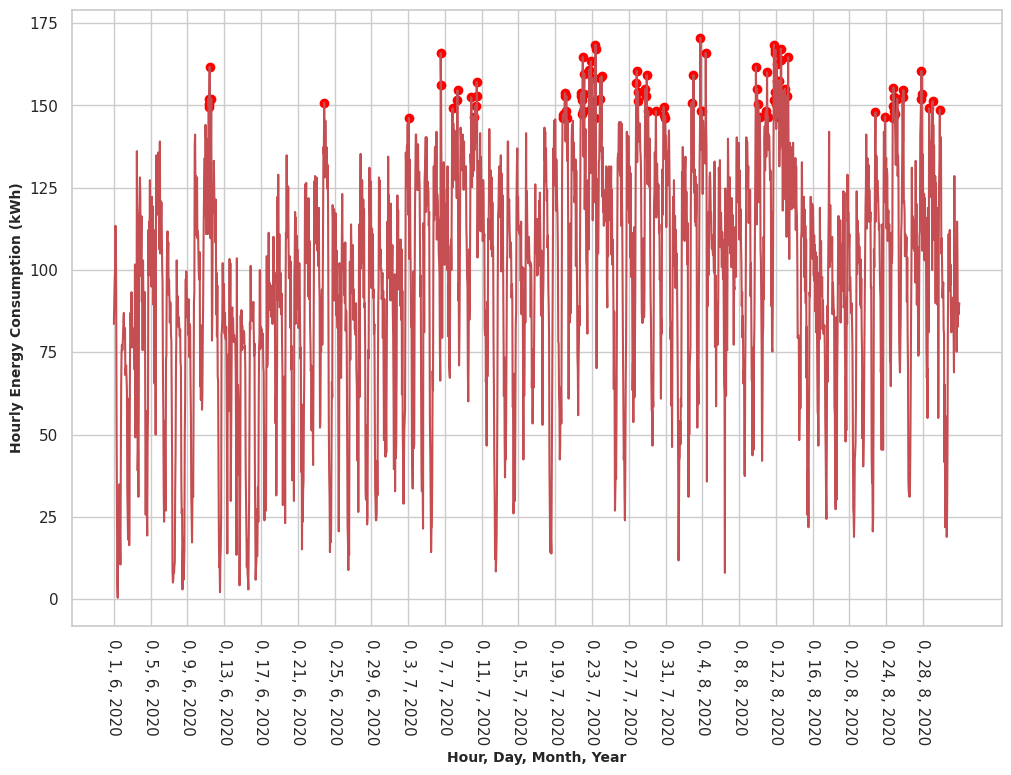

      Hour Day Month  Year EnergyUse  Temp RelHum Humidity UVIndex
12655    7  11     6  2020    152.04  75.0   70.1    84.73       1
12656    8  11     6  2020    149.52  75.1   70.1    84.54       1
12657    9  11     6  2020    150.36  76.0   71.1    84.66       1
12658   10  11     6  2020     161.7  78.3   72.9    83.54       2
12662   14  11     6  2020    152.04  73.2   71.1    93.18       1
...    ...  ..   ...   ...       ...   ...    ...      ...     ...
14516   20  27     8  2020    160.44  84.9   70.0     61.1       0
14517   21  27     8  2020     153.3  74.5   67.0     77.5       0
14536   16  28     8  2020     149.1  72.2   71.1    96.09       0
14545    1  29     8  2020     151.2  70.1   69.2    96.74       0
14564   20  29     8  2020    148.68  74.0   69.3    85.34       0

[109 rows x 9 columns]


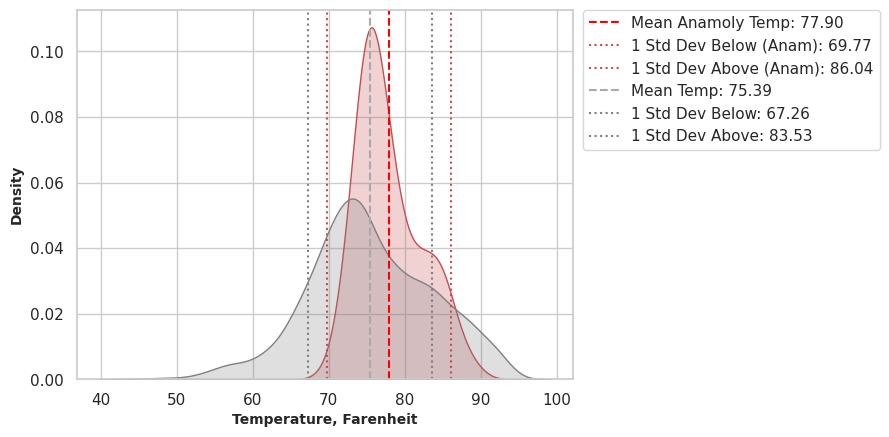

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


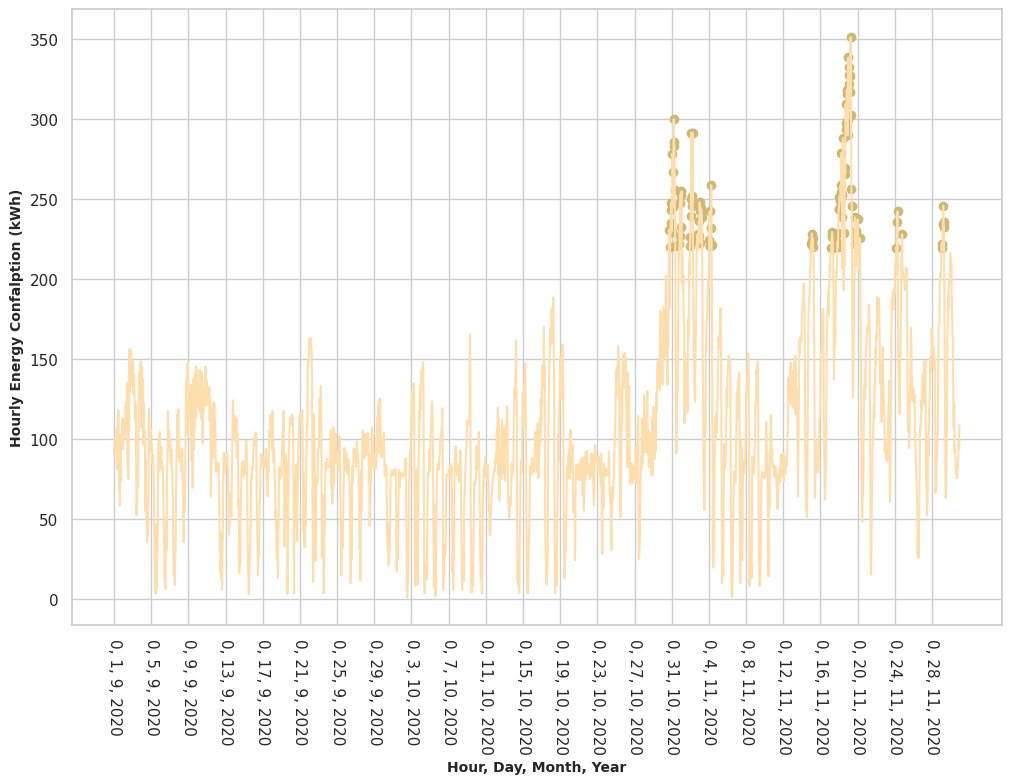

      Hour Day Month  Year EnergyUse  Temp RelHum Humidity UVIndex
16049   17  30    10  2020    230.58  46.0   37.4    71.68       0
16052   20  30    10  2020    220.08  41.1   32.1    70.34       0
16053   21  30    10  2020    234.78  39.0   32.0    75.71       0
16054   22  30    10  2020    243.18  38.1   32.0    78.33       0
16055   23  30    10  2020     247.8  36.1   29.2    75.77       0
...    ...  ..   ...   ...       ...   ...    ...      ...     ...
16754    2  29    11  2020    219.24  33.2   28.1    81.46       0
16756    4  29    11  2020    234.36  33.2   28.0    81.05       0
16757    5  29    11  2020     245.7  30.9   26.1     82.2       0
16758    6  29    11  2020    235.62  29.3   26.1    87.48       0
16759    7  29    11  2020    232.68  31.2   28.8    90.78       0

[110 rows x 9 columns]


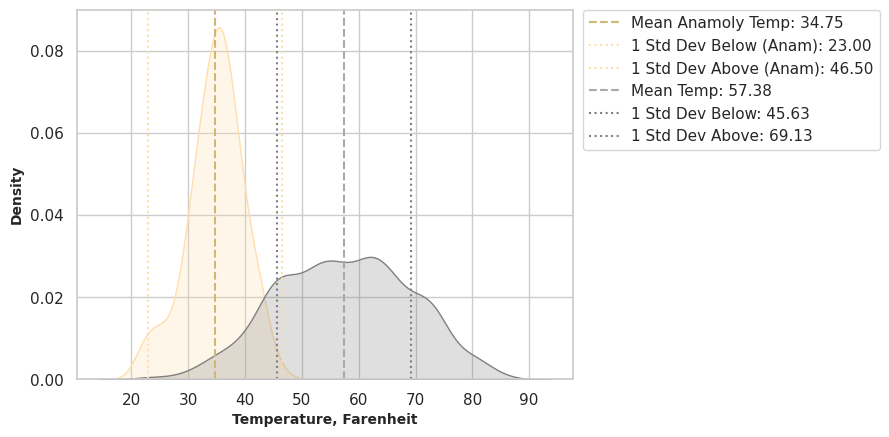

In [ ]:
# 2020 Winter:
threshold_nn_h_win_20_PPWA = anomaly_scores_nn_h_win_20_PPWA.quantile(0.95)
anomalous_nn_h_win_20_PPWA = anomaly_scores_nn_h_win_20_PPWA > threshold_nn_h_win_20_PPWA
binary_labels_nn_h_win_20_PPWA = anomalous_nn_h_win_20_PPWA.astype(int)
precision_nn_h_win_20_PPWA, recall_nn_h_win_20_PPWA, f1_score_nn_h_win_20_PPWA, _ = precision_recall_fscore_support(binary_labels_nn_h_win_20_PPWA, anomalous_nn_h_win_20_PPWA, average='binary')

test_nn_h_win_20_PPWA = dc_nn_h_win_20_PPWA['EnergyUse'].values
predictions_nn_h_win_20_PPWA = anomaly_scores_nn_h_win_20_PPWA.values

print("Precision: ", precision_nn_h_win_20_PPWA)
print("Recall: ", recall_nn_h_win_20_PPWA)
print("F1 Score: ", f1_score_nn_h_win_20_PPWA)

# Plot the data with anomalies marked in red
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(dc_nn_h_win_20_PPWA['timestamp'], dc_nn_h_win_20_PPWA['EnergyUse'], color='b')
plt.scatter(dc_nn_h_win_20_PPWA['timestamp'][anomalous_nn_h_win_20_PPWA], dc_nn_h_win_20_PPWA['EnergyUse'][anomalous_nn_h_win_20_PPWA], marker='o', color='blue')
plt.xlabel('Hour, Day, Month, Year', fontweight ='bold', fontsize = 10)
plt.ylabel('Hourly Energy Consumption (kWh)', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 2160, 96))
plt.tick_params(axis ='x', rotation = -90)
plt.show()

# Isolate the anomalous values
anomalous_nn_h_win_20_PPWA_true = dc_nn_h_win_20_PPWA[anomalous_nn_h_win_20_PPWA]

anomalous_nn_h_win_20_PPWA_weather = b1_hourly_win_20[anomalous_nn_h_win_20_PPWA]

anomalous_nn_h_win_20_PPWA_weather = anomalous_nn_h_win_20_PPWA_weather[['Hour', 'Day', 'Month', 'Year', 'EnergyUse', 'Temp', 'RelHum', 'Humidity', 'UVIndex']]
print(anomalous_nn_h_win_20_PPWA_weather)

# Visualize distrubution of anamolous temperatures
anamalous_temp_nn_h_win_20_mean = np.mean(anomalous_nn_h_win_20_PPWA_weather['Temp'])
anamalous_temp_nn_h_win_20_std_dev = np.std(anomalous_nn_h_win_20_PPWA_weather['Temp'])

temp_nn_h_win_20_mean = np.mean(b1_hourly_win_20['Temp'])
temp_nn_h_win_20_std_dev = np.std(b1_hourly_win_20['Temp'])

sns.set(style='whitegrid')
sns.kdeplot(anomalous_nn_h_win_20_PPWA_weather['Temp'], fill=True, color="b")
plt.axvline(anamalous_temp_nn_h_win_20_mean, color='blue', linestyle='--', label=f'Mean Anamoly Temp: {anamalous_temp_nn_h_win_20_mean:.2f}')
plt.axvline(anamalous_temp_nn_h_win_20_mean - temp_nn_h_win_20_std_dev, color='b', linestyle=':', label=f'1 Std Dev Below (Anam): {anamalous_temp_nn_h_win_20_mean - temp_nn_h_win_20_std_dev:.2f}')
plt.axvline(anamalous_temp_nn_h_win_20_mean + temp_nn_h_win_20_std_dev, color='b', linestyle=':', label=f'1 Std Dev Above (Anam): {anamalous_temp_nn_h_win_20_mean + temp_nn_h_win_20_std_dev:.2f}')

sns.kdeplot(b1_hourly_win_20['Temp'], fill=True, color="grey")
plt.axvline(temp_nn_h_win_20_mean, color='darkgrey', linestyle='--', label=f'Mean Temp: {temp_nn_h_win_20_mean:.2f}')
plt.axvline(temp_nn_h_win_20_mean - temp_nn_h_win_20_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Below: {temp_nn_h_win_20_mean - temp_nn_h_win_20_std_dev:.2f}')
plt.axvline(temp_nn_h_win_20_mean + temp_nn_h_win_20_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Above: {temp_nn_h_win_20_mean + temp_nn_h_win_20_std_dev:.2f}')

plt.xlabel('Temperature, Farenheit', fontweight ='bold', fontsize = 10)
plt.ylabel('Density', fontweight ='bold', fontsize = 10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# 2020 Spring:
threshold_nn_h_spr_20_PPWA = anomaly_scores_nn_h_spr_20_PPWA.quantile(0.95)
anomalous_nn_h_spr_20_PPWA = anomaly_scores_nn_h_spr_20_PPWA > threshold_nn_h_spr_20_PPWA
binary_labels_nn_h_spr_20_PPWA = anomalous_nn_h_spr_20_PPWA.astype(int)
precision_nn_h_spr_20_PPWA, recall_nn_h_spr_20_PPWA, f1_score_nn_h_spr_20_PPWA, _ = precision_recall_fscore_support(binary_labels_nn_h_spr_20_PPWA, anomalous_nn_h_spr_20_PPWA, average='binary')

test_nn_h_spr_20_PPWA = dc_nn_h_spr_20_PPWA['EnergyUse'].values
predictions_nn_h_spr_20_PPWA = anomaly_scores_nn_h_spr_20_PPWA.values

print("Precision: ", precision_nn_h_spr_20_PPWA)
print("Recall: ", recall_nn_h_spr_20_PPWA)
print("F1 Score: ", f1_score_nn_h_spr_20_PPWA)

# Plot the data with anomalies marked in red
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(dc_nn_h_spr_20_PPWA['timestamp'], dc_nn_h_spr_20_PPWA['EnergyUse'], color='g')
plt.scatter(dc_nn_h_spr_20_PPWA['timestamp'][anomalous_nn_h_spr_20_PPWA], dc_nn_h_spr_20_PPWA['EnergyUse'][anomalous_nn_h_spr_20_PPWA], marker='o', color='green')
plt.xlabel('Hour, Day, Month, Year', fontweight ='bold', fontsize = 10)
plt.ylabel('Hourly Energy Consumption (kWh)', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 2160, 96))
plt.tick_params(axis ='x', rotation = -90)
plt.show()

# Isolate the anomalous values
anomalous_nn_h_spr_20_PPWA_true = dc_nn_h_spr_20_PPWA[anomalous_nn_h_spr_20_PPWA]

anomalous_nn_h_spr_20_PPWA_weather = b1_hourly_spr_20[anomalous_nn_h_spr_20_PPWA]

anomalous_nn_h_spr_20_PPWA_weather = anomalous_nn_h_spr_20_PPWA_weather[['Hour', 'Day', 'Month', 'Year', 'EnergyUse', 'Temp', 'RelHum', 'Humidity', 'UVIndex']]
print(anomalous_nn_h_spr_20_PPWA_weather)

# Visualize distrubution of anamolous temperatures
anamalous_temp_nn_h_spr_20_mean = np.mean(anomalous_nn_h_spr_20_PPWA_weather['Temp'])
anamalous_temp_nn_h_spr_20_std_dev = np.std(anomalous_nn_h_spr_20_PPWA_weather['Temp'])

temp_nn_h_spr_20_mean = np.mean(b1_hourly_spr_20['Temp'])
temp_nn_h_spr_20_std_dev = np.std(b1_hourly_spr_20['Temp'])

sns.set(style='whitegrid')
sns.kdeplot(anomalous_nn_h_spr_20_PPWA_weather['Temp'], fill=True, color="g")
plt.axvline(anamalous_temp_nn_h_spr_20_mean, color='green', linestyle='--', label=f'Mean Anamoly Temp: {anamalous_temp_nn_h_spr_20_mean:.2f}')
plt.axvline(anamalous_temp_nn_h_spr_20_mean - temp_nn_h_spr_20_std_dev, color='g', linestyle=':', label=f'1 Std Dev Below (Anam): {anamalous_temp_nn_h_spr_20_mean - temp_nn_h_spr_20_std_dev:.2f}')
plt.axvline(anamalous_temp_nn_h_spr_20_mean + temp_nn_h_spr_20_std_dev, color='g', linestyle=':', label=f'1 Std Dev Above (Anam): {anamalous_temp_nn_h_spr_20_mean + temp_nn_h_spr_20_std_dev:.2f}')

sns.kdeplot(b1_hourly_spr_20['Temp'], fill=True, color="grey")
plt.axvline(temp_nn_h_spr_20_mean, color='darkgrey', linestyle='--', label=f'Mean Temp: {temp_nn_h_spr_20_mean:.2f}')
plt.axvline(temp_nn_h_spr_20_mean - temp_nn_h_spr_20_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Below: {temp_nn_h_spr_20_mean - temp_nn_h_spr_20_std_dev:.2f}')
plt.axvline(temp_nn_h_spr_20_mean + temp_nn_h_spr_20_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Above: {temp_nn_h_spr_20_mean + temp_nn_h_spr_20_std_dev:.2f}')

plt.xlabel('Temperature, Farenheit', fontweight ='bold', fontsize = 10)
plt.ylabel('Density', fontweight ='bold', fontsize = 10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# 2020 Summer:
threshold_nn_h_sum_20_PPWA = anomaly_scores_nn_h_sum_20_PPWA.quantile(0.95)
anomalous_nn_h_sum_20_PPWA = anomaly_scores_nn_h_sum_20_PPWA > threshold_nn_h_sum_20_PPWA
binary_labels_nn_h_sum_20_PPWA = anomalous_nn_h_sum_20_PPWA.astype(int)
precision_nn_h_sum_20_PPWA, recall_nn_h_sum_20_PPWA, f1_score_nn_h_sum_20_PPWA, _ = precision_recall_fscore_support(binary_labels_nn_h_sum_20_PPWA, anomalous_nn_h_sum_20_PPWA, average='binary')

test_nn_h_sum_20_PPWA = dc_nn_h_sum_20_PPWA['EnergyUse'].values
predictions_nn_h_sum_20_PPWA = anomaly_scores_nn_h_sum_20_PPWA.values

print("Precision: ", precision_nn_h_sum_20_PPWA)
print("Recall: ", recall_nn_h_sum_20_PPWA)
print("F1 Score: ", f1_score_nn_h_sum_20_PPWA)

# Plot the data with anomalies marked in red
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(dc_nn_h_sum_20_PPWA['timestamp'], dc_nn_h_sum_20_PPWA['EnergyUse'], color='r')
plt.scatter(dc_nn_h_sum_20_PPWA['timestamp'][anomalous_nn_h_sum_20_PPWA], dc_nn_h_sum_20_PPWA['EnergyUse'][anomalous_nn_h_sum_20_PPWA], marker='o', color='red')
plt.xlabel('Hour, Day, Month, Year', fontweight ='bold', fontsize = 10)
plt.ylabel('Hourly Energy Consumption (kWh)', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 2160, 96))
plt.tick_params(axis ='x', rotation = -90)
plt.show()

# Isolate the anomalous values
anomalous_nn_h_sum_20_PPWA_true = dc_nn_h_sum_20_PPWA[anomalous_nn_h_sum_20_PPWA]

anomalous_nn_h_sum_20_PPWA_weather = b1_hourly_sum_20[anomalous_nn_h_sum_20_PPWA]

anomalous_nn_h_sum_20_PPWA_weather = anomalous_nn_h_sum_20_PPWA_weather[['Hour', 'Day', 'Month', 'Year', 'EnergyUse', 'Temp', 'RelHum', 'Humidity', 'UVIndex']]
print(anomalous_nn_h_sum_20_PPWA_weather)

# Visualize distrubution of anamolous temperatures
anamalous_temp_nn_h_sum_20_mean = np.mean(anomalous_nn_h_sum_20_PPWA_weather['Temp'])
anamalous_temp_nn_h_sum_20_std_dev = np.std(anomalous_nn_h_sum_20_PPWA_weather['Temp'])

temp_nn_h_sum_20_mean = np.mean(b1_hourly_sum_20['Temp'])
temp_nn_h_sum_20_std_dev = np.std(b1_hourly_sum_20['Temp'])

sns.set(style='whitegrid')
sns.kdeplot(anomalous_nn_h_sum_20_PPWA_weather['Temp'], fill=True, color="r")
plt.axvline(anamalous_temp_nn_h_sum_20_mean, color='red', linestyle='--', label=f'Mean Anamoly Temp: {anamalous_temp_nn_h_sum_20_mean:.2f}')
plt.axvline(anamalous_temp_nn_h_sum_20_mean - temp_nn_h_sum_20_std_dev, color='r', linestyle=':', label=f'1 Std Dev Below (Anam): {anamalous_temp_nn_h_sum_20_mean - temp_nn_h_sum_20_std_dev:.2f}')
plt.axvline(anamalous_temp_nn_h_sum_20_mean + temp_nn_h_sum_20_std_dev, color='r', linestyle=':', label=f'1 Std Dev Above (Anam): {anamalous_temp_nn_h_sum_20_mean + temp_nn_h_sum_20_std_dev:.2f}')

sns.kdeplot(b1_hourly_sum_20['Temp'], fill=True, color="grey")
plt.axvline(temp_nn_h_sum_20_mean, color='darkgrey', linestyle='--', label=f'Mean Temp: {temp_nn_h_sum_20_mean:.2f}')
plt.axvline(temp_nn_h_sum_20_mean - temp_nn_h_sum_20_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Below: {temp_nn_h_sum_20_mean - temp_nn_h_sum_20_std_dev:.2f}')
plt.axvline(temp_nn_h_sum_20_mean + temp_nn_h_sum_20_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Above: {temp_nn_h_sum_20_mean + temp_nn_h_sum_20_std_dev:.2f}')

plt.xlabel('Temperature, Farenheit', fontweight ='bold', fontsize = 10)
plt.ylabel('Density', fontweight ='bold', fontsize = 10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# 2020 Fall
threshold_nn_h_fal_20_PPWA = anomaly_scores_nn_h_fal_20_PPWA.quantile(0.95)
anomalous_nn_h_fal_20_PPWA = anomaly_scores_nn_h_fal_20_PPWA > threshold_nn_h_fal_20_PPWA
binary_labels_nn_h_fal_20_PPWA = anomalous_nn_h_fal_20_PPWA.astype(int)
precision_nn_h_fal_20_PPWA, recall_nn_h_fal_20_PPWA, f1_score_nn_h_fal_20_PPWA, _ = precision_recall_fscore_support(binary_labels_nn_h_fal_20_PPWA, anomalous_nn_h_fal_20_PPWA, average='binary')

test_nn_h_fal_20_PPWA = dc_nn_h_fal_20_PPWA['EnergyUse'].values
predictions_nn_h_fal_20_PPWA = anomaly_scores_nn_h_fal_20_PPWA.values

print("Precision: ", precision_nn_h_fal_20_PPWA)
print("Recall: ", recall_nn_h_fal_20_PPWA)
print("F1 Score: ", f1_score_nn_h_fal_20_PPWA)

# Plot the data with anomalies marked in red
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(dc_nn_h_fal_20_PPWA['timestamp'], dc_nn_h_fal_20_PPWA['EnergyUse'], color='navajowhite')
plt.scatter(dc_nn_h_fal_20_PPWA['timestamp'][anomalous_nn_h_fal_20_PPWA], dc_nn_h_fal_20_PPWA['EnergyUse'][anomalous_nn_h_fal_20_PPWA], marker='o', color='y')
plt.xlabel('Hour, Day, Month, Year', fontweight ='bold', fontsize = 10)
plt.ylabel('Hourly Energy Confalption (kWh)', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 2160, 96))
plt.tick_params(axis ='x', rotation = -90)
plt.show()

# Isolate the anomalous values
anomalous_nn_h_fal_20_PPWA_true = dc_nn_h_fal_20_PPWA[anomalous_nn_h_fal_20_PPWA]

anomalous_nn_h_fal_20_PPWA_weather = b1_hourly_fal_20[anomalous_nn_h_fal_20_PPWA]

anomalous_nn_h_fal_20_PPWA_weather = anomalous_nn_h_fal_20_PPWA_weather[['Hour', 'Day', 'Month', 'Year', 'EnergyUse', 'Temp', 'RelHum', 'Humidity', 'UVIndex']]
print(anomalous_nn_h_fal_20_PPWA_weather)

# Visualize distrubution of anamolous temperatures
anamalous_temp_nn_h_fal_20_mean = np.mean(anomalous_nn_h_fal_20_PPWA_weather['Temp'])
anamalous_temp_nn_h_fal_20_std_dev = np.std(anomalous_nn_h_fal_20_PPWA_weather['Temp'])

temp_nn_h_fal_20_mean = np.mean(b1_hourly_fal_20['Temp'])
temp_nn_h_fal_20_std_dev = np.std(b1_hourly_fal_20['Temp'])

sns.set(style='whitegrid')
sns.kdeplot(anomalous_nn_h_fal_20_PPWA_weather['Temp'], fill=True, color="navajowhite")
plt.axvline(anamalous_temp_nn_h_fal_20_mean, color='y', linestyle='--', label=f'Mean Anamoly Temp: {anamalous_temp_nn_h_fal_20_mean:.2f}')
plt.axvline(anamalous_temp_nn_h_fal_20_mean - temp_nn_h_fal_20_std_dev, color='navajowhite', linestyle=':', label=f'1 Std Dev Below (Anam): {anamalous_temp_nn_h_fal_20_mean - temp_nn_h_fal_20_std_dev:.2f}')
plt.axvline(anamalous_temp_nn_h_fal_20_mean + temp_nn_h_fal_20_std_dev, color='navajowhite', linestyle=':', label=f'1 Std Dev Above (Anam): {anamalous_temp_nn_h_fal_20_mean + temp_nn_h_fal_20_std_dev:.2f}')

sns.kdeplot(b1_hourly_fal_20['Temp'], fill=True, color="grey")
plt.axvline(temp_nn_h_fal_20_mean, color='darkgrey', linestyle='--', label=f'Mean Temp: {temp_nn_h_fal_20_mean:.2f}')
plt.axvline(temp_nn_h_fal_20_mean - temp_nn_h_fal_20_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Below: {temp_nn_h_fal_20_mean - temp_nn_h_fal_20_std_dev:.2f}')
plt.axvline(temp_nn_h_fal_20_mean + temp_nn_h_fal_20_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Above: {temp_nn_h_fal_20_mean + temp_nn_h_fal_20_std_dev:.2f}')

plt.xlabel('Temperature, Farenheit', fontweight ='bold', fontsize = 10)
plt.ylabel('Density', fontweight ='bold', fontsize = 10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# ^ Fitting (2021 All Seasons)

In [ ]:
# 2021 Winter:
# Exclude datetime column
dt_nn_h_win_21_PPWA = tf.convert_to_tensor(dc_nn_h_win_21_PPWA.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# Define the autoencoder model
input_dim_nn_h_win_21_PPWA = dc_nn_h_win_21_PPWA.shape[1] - 1
encoding_dim_nn_h_win_21_PPWA = 10

input_layer_nn_h_win_21_PPWA = Input(shape=(input_dim_nn_h_win_21_PPWA,))
encoder_nn_h_win_21_PPWA = Dense(encoding_dim_nn_h_win_21_PPWA, activation='relu')(input_layer_nn_h_win_21_PPWA)
decoder_nn_h_win_21_PPWA = Dense(input_dim_nn_h_win_21_PPWA, activation='relu')(encoder_nn_h_win_21_PPWA)
autoencoder_nn_h_win_21_PPWA = Model(inputs=input_layer_nn_h_win_21_PPWA, outputs=decoder_nn_h_win_21_PPWA)

# Compile and fit the model
autoencoder_nn_h_win_21_PPWA.compile(optimizer='adam', loss='mae')
autoencoder_nn_h_win_21_PPWA.fit(dt_nn_h_win_21_PPWA, dt_nn_h_win_21_PPWA, epochs=30,
				batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions_nn_h_win_21_PPWA = autoencoder_nn_h_win_21_PPWA.predict(dt_nn_h_win_21_PPWA)
mae_nn_h_win_21_PPWA = tf.reduce_mean(tf.square(dt_nn_h_win_21_PPWA - reconstructions_nn_h_win_21_PPWA),
					axis=1)
anomaly_scores_nn_h_win_21_PPWA = pd.Series(mae_nn_h_win_21_PPWA.numpy(), name='anomaly_scores')
anomaly_scores_nn_h_win_21_PPWA.index = dc_nn_h_win_21_PPWA.index

# 2021 Spring:
# Exclude datetime column
dt_nn_h_spr_21_PPWA = tf.convert_to_tensor(dc_nn_h_spr_21_PPWA.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# Define the autoencoder model
input_dim_nn_h_spr_21_PPWA = dc_nn_h_spr_21_PPWA.shape[1] - 1
encoding_dim_nn_h_spr_21_PPWA = 10

input_layer_nn_h_spr_21_PPWA = Input(shape=(input_dim_nn_h_spr_21_PPWA,))
encoder_nn_h_spr_21_PPWA = Dense(encoding_dim_nn_h_spr_21_PPWA, activation='relu')(input_layer_nn_h_spr_21_PPWA)
decoder_nn_h_spr_21_PPWA = Dense(input_dim_nn_h_spr_21_PPWA, activation='relu')(encoder_nn_h_spr_21_PPWA)
autoencoder_nn_h_spr_21_PPWA = Model(inputs=input_layer_nn_h_spr_21_PPWA, outputs=decoder_nn_h_spr_21_PPWA)

# Compile and fit the model
autoencoder_nn_h_spr_21_PPWA.compile(optimizer='adam', loss='mae')
autoencoder_nn_h_spr_21_PPWA.fit(dt_nn_h_spr_21_PPWA, dt_nn_h_spr_21_PPWA, epochs=30,
				batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions_nn_h_spr_21_PPWA = autoencoder_nn_h_spr_21_PPWA.predict(dt_nn_h_spr_21_PPWA)
mae_nn_h_spr_21_PPWA = tf.reduce_mean(tf.square(dt_nn_h_spr_21_PPWA - reconstructions_nn_h_spr_21_PPWA),
					axis=1)
anomaly_scores_nn_h_spr_21_PPWA = pd.Series(mae_nn_h_spr_21_PPWA.numpy(), name='anomaly_scores')
anomaly_scores_nn_h_spr_21_PPWA.index = dc_nn_h_spr_21_PPWA.index

# 2021 Summer:
# Exclude datetime column
dt_nn_h_sum_21_PPWA = tf.convert_to_tensor(dc_nn_h_sum_21_PPWA.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# Define the autoencoder model
input_dim_nn_h_sum_21_PPWA = dc_nn_h_sum_21_PPWA.shape[1] - 1
encoding_dim_nn_h_sum_21_PPWA = 10

input_layer_nn_h_sum_21_PPWA = Input(shape=(input_dim_nn_h_sum_21_PPWA,))
encoder_nn_h_sum_21_PPWA = Dense(encoding_dim_nn_h_sum_21_PPWA, activation='relu')(input_layer_nn_h_sum_21_PPWA)
decoder_nn_h_sum_21_PPWA = Dense(input_dim_nn_h_sum_21_PPWA, activation='relu')(encoder_nn_h_sum_21_PPWA)
autoencoder_nn_h_sum_21_PPWA = Model(inputs=input_layer_nn_h_sum_21_PPWA, outputs=decoder_nn_h_sum_21_PPWA)

# Compile and fit the model
autoencoder_nn_h_sum_21_PPWA.compile(optimizer='adam', loss='mae')
autoencoder_nn_h_sum_21_PPWA.fit(dt_nn_h_sum_21_PPWA, dt_nn_h_sum_21_PPWA, epochs=30,
				batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions_nn_h_sum_21_PPWA = autoencoder_nn_h_sum_21_PPWA.predict(dt_nn_h_sum_21_PPWA)
mae_nn_h_sum_21_PPWA = tf.reduce_mean(tf.square(dt_nn_h_sum_21_PPWA - reconstructions_nn_h_sum_21_PPWA),
					axis=1)
anomaly_scores_nn_h_sum_21_PPWA = pd.Series(mae_nn_h_sum_21_PPWA.numpy(), name='anomaly_scores')
anomaly_scores_nn_h_sum_21_PPWA.index = dc_nn_h_sum_21_PPWA.index

# 2021 Fall:
# Exclude datetime column
dt_nn_h_fal_21_PPWA = tf.convert_to_tensor(dc_nn_h_fal_21_PPWA.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# Define the autoencoder model
input_dim_nn_h_fal_21_PPWA = dc_nn_h_fal_21_PPWA.shape[1] - 1
encoding_dim_nn_h_fal_21_PPWA = 10

input_layer_nn_h_fal_21_PPWA = Input(shape=(input_dim_nn_h_fal_21_PPWA,))
encoder_nn_h_fal_21_PPWA = Dense(encoding_dim_nn_h_fal_21_PPWA, activation='relu')(input_layer_nn_h_fal_21_PPWA)
decoder_nn_h_fal_21_PPWA = Dense(input_dim_nn_h_fal_21_PPWA, activation='relu')(encoder_nn_h_fal_21_PPWA)
autoencoder_nn_h_fal_21_PPWA = Model(inputs=input_layer_nn_h_fal_21_PPWA, outputs=decoder_nn_h_fal_21_PPWA)

# Compile and fit the model
autoencoder_nn_h_fal_21_PPWA.compile(optimizer='adam', loss='mae')
autoencoder_nn_h_fal_21_PPWA.fit(dt_nn_h_fal_21_PPWA, dt_nn_h_fal_21_PPWA, epochs=30,
				batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions_nn_h_fal_21_PPWA = autoencoder_nn_h_fal_21_PPWA.predict(dt_nn_h_fal_21_PPWA)
mae_nn_h_fal_21_PPWA = tf.reduce_mean(tf.square(dt_nn_h_fal_21_PPWA - reconstructions_nn_h_fal_21_PPWA),
					axis=1)
anomaly_scores_nn_h_fal_21_PPWA = pd.Series(mae_nn_h_fal_21_PPWA.numpy(), name='anomaly_scores')
anomaly_scores_nn_h_fal_21_PPWA.index = dc_nn_h_fal_21_PPWA.index

Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9300
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1083
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1660
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0918
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1163
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0864
Epoch 7/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0568
Epoch 8/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1301
Epoch 9/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0851
Epoch 10/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0710
Epoch 11/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1318
Epoch 12/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1737
Epoch 13/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0838
Epoch 14/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0911
Epoch 15/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0899
Epoch 16/30
68/68 ━

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


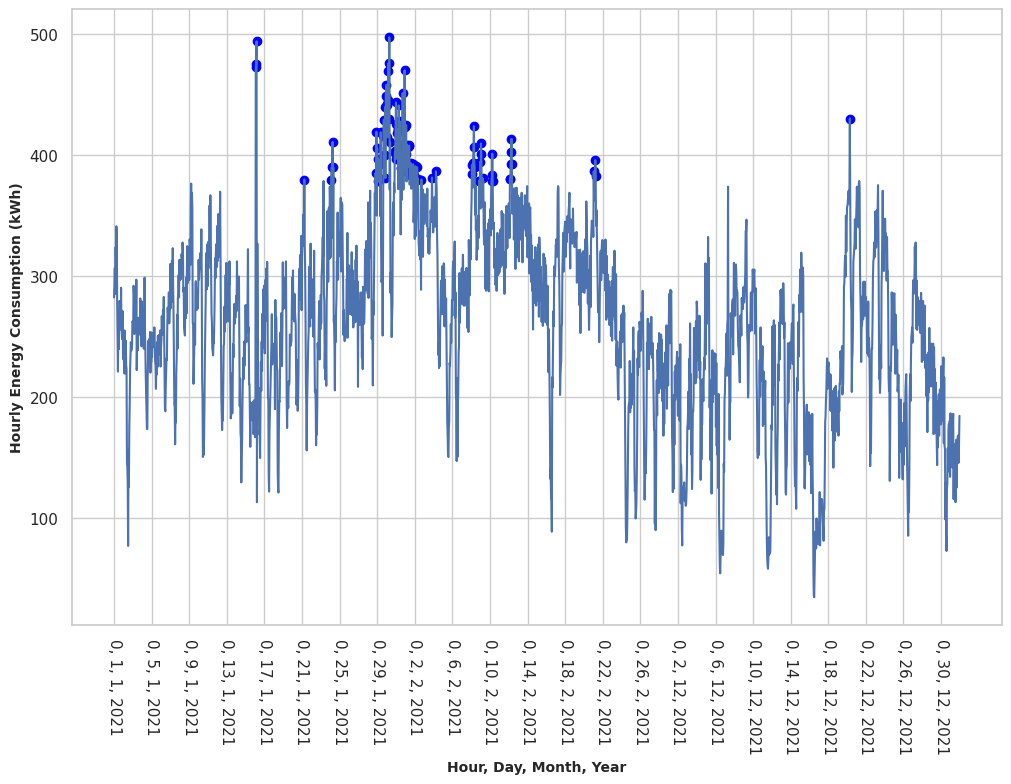

      Hour Day Month  Year EnergyUse  Temp RelHum Humidity UVIndex
17906    2  16     1  2021     472.5  44.2   44.1    99.67       0
17907    3  16     1  2021    475.02  44.2   43.3    96.28       0
17908    4  16     1  2021    493.92  43.3   43.2    99.51       0
18030    6  21     1  2021    379.68  20.1   13.9    76.43       0
18099    3  24     1  2021    379.68  23.1    8.0    51.85       0
...    ...  ..   ...   ...       ...   ...    ...      ...     ...
18560    8  12     2  2021     392.7  19.2    5.0    53.32       0
18769    1  21     2  2021     386.4  24.1   11.0    56.79       0
18773    5  21     2  2021    395.64  20.0   10.1     64.9       0
18774    6  21     2  2021     382.2  19.9   10.9    67.59       0
26023    7  20    12  2021    430.08  21.8   15.1    75.15       0

[106 rows x 9 columns]


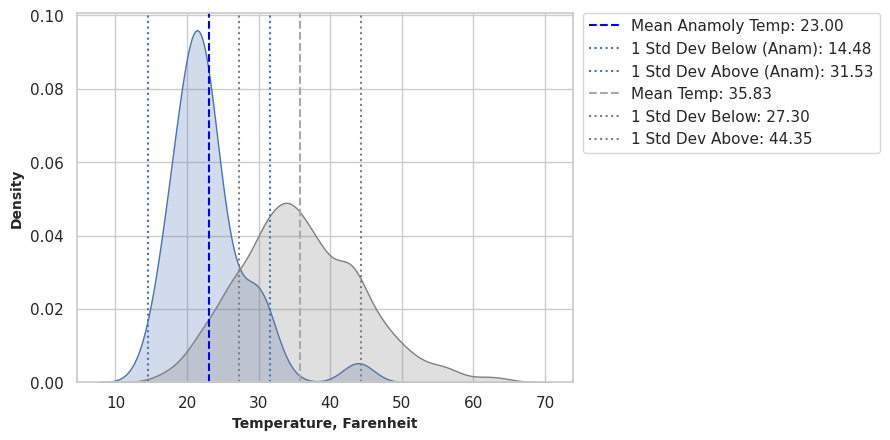

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


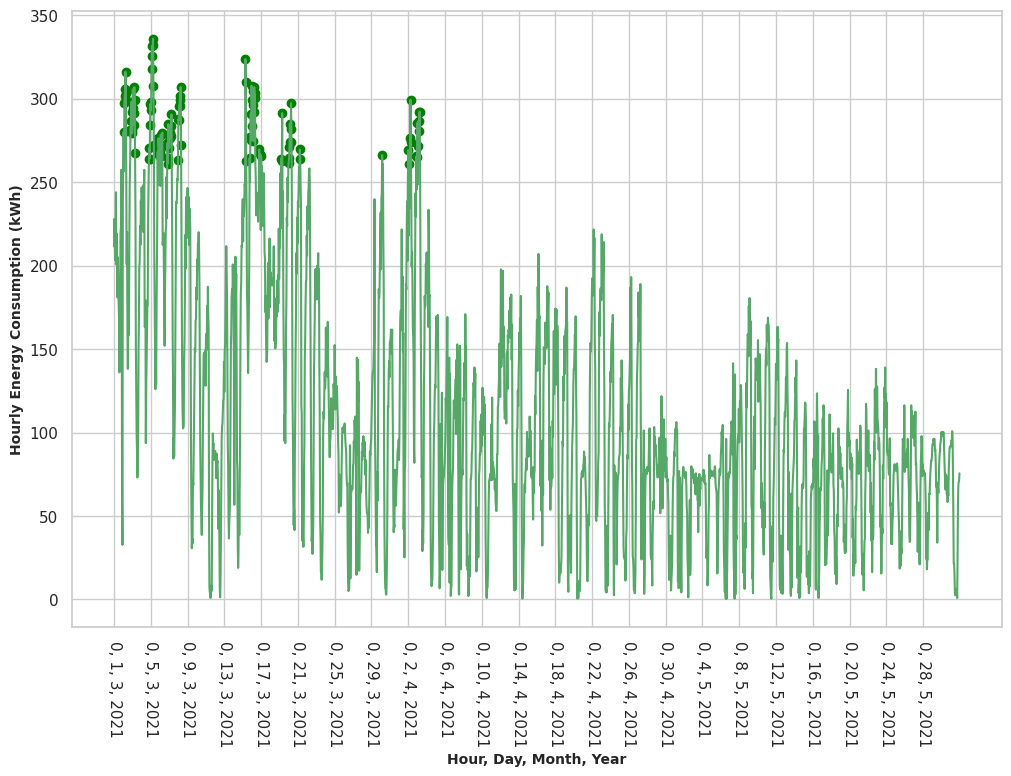

      Hour Day Month  Year EnergyUse  Temp RelHum Humidity UVIndex
18985    1   2     3  2021    280.14  30.9    7.9    37.48       0
18987    3   2     3  2021    297.36  27.1    4.9    38.12       0
18988    4   2     3  2021    301.98  25.2    2.9     37.7       0
18989    5   2     3  2021    305.76  24.3    1.2    36.18       0
18990    6   2     3  2021    316.26  23.1    1.0    37.72       0
...    ...  ..   ...   ...       ...   ...    ...      ...     ...
19754    2   3     4  2021    271.74  28.9    8.2    41.13       0
19755    3   3     4  2021    286.86  27.9   11.9    50.39       0
19756    4   3     4  2021    280.98  28.1   11.0    48.32       0
19757    5   3     4  2021    292.32  28.0   11.0    48.29       0
19758    6   3     4  2021    292.32  27.1   10.9     50.0       0

[111 rows x 9 columns]


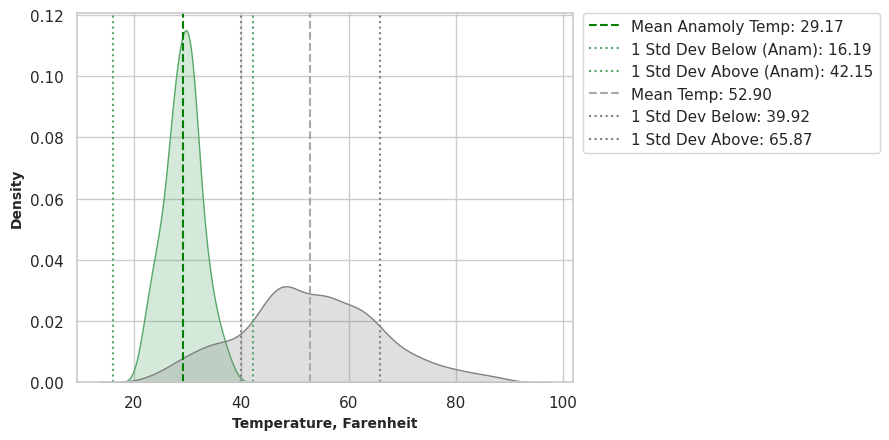

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


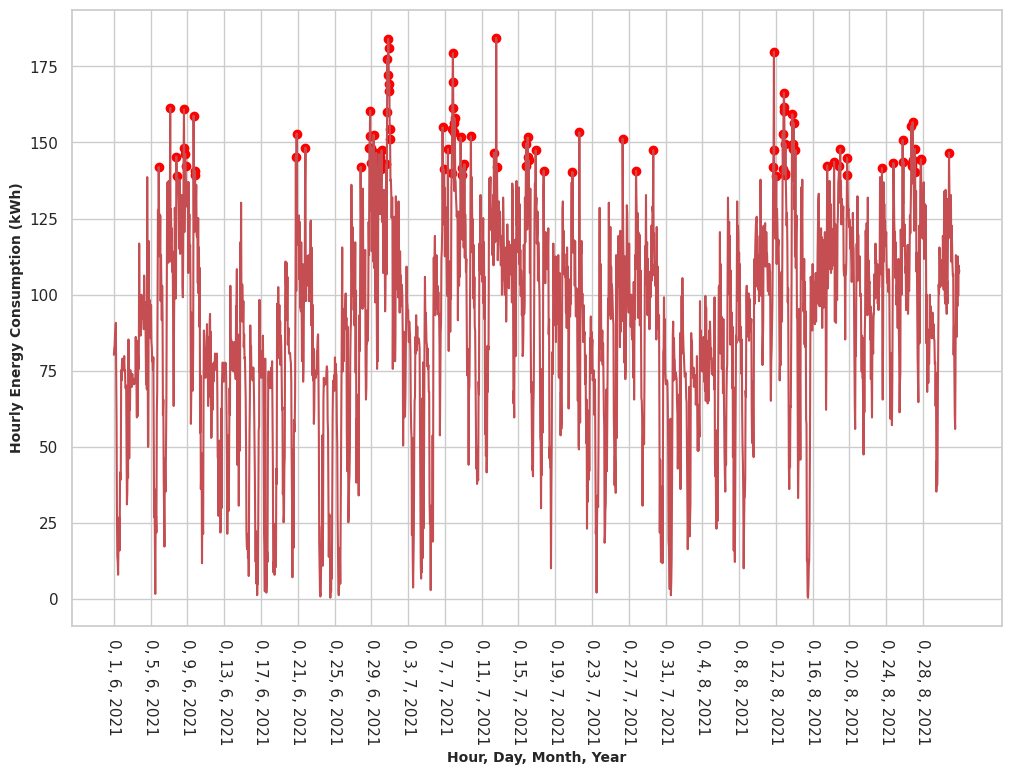

      Hour Day Month  Year EnergyUse  Temp RelHum Humidity UVIndex
21285   21   5     6  2021    141.96  80.9   62.1    53.04       0
21315    3   7     6  2021    161.28  71.1   66.9    86.55       0
21331   19   7     6  2021    145.32  84.8   69.1    59.55       0
21333   21   7     6  2021    139.02  80.8   70.8    71.66       0
21350   14   8     6  2021    148.26  80.2   69.4    69.64       0
...    ...  ..   ...   ...       ...   ...    ...      ...     ...
23258    2  27     8  2021    140.28  74.9   73.9    96.78       0
23259    3  27     8  2021    147.84  74.1   73.9    99.33       0
23274   18  27     8  2021    144.06  78.2   74.7    88.84       8
23275   19  27     8  2021    144.48  77.0   73.8    89.96       0
23348   20  30     8  2021    146.58  78.9   73.0    82.16       0

[109 rows x 9 columns]


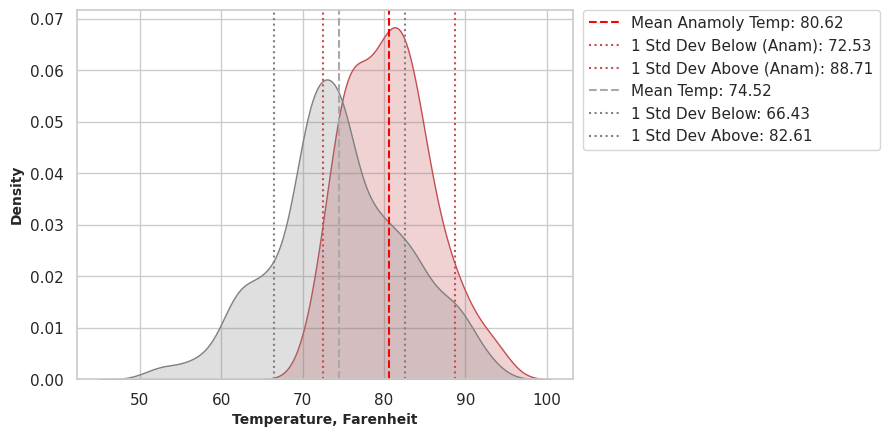

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


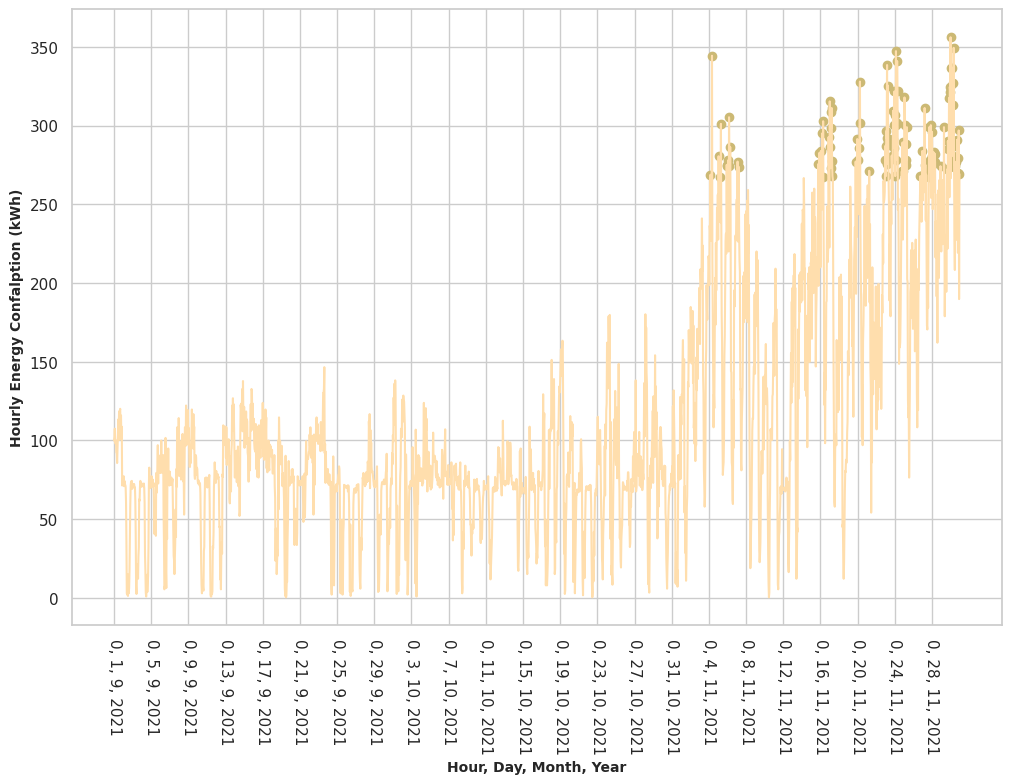

      Hour Day Month  Year EnergyUse  Temp RelHum Humidity UVIndex
24916    4   4    11  2021     268.8  32.1   29.7    91.02       0
24920    8   4    11  2021     344.4  32.3   29.9    90.72       0
24937    1   5    11  2021    280.56  33.3   29.7    86.66       0
24941    5   5    11  2021    267.54  32.0   28.0    84.77       0
24943    7   5    11  2021    301.14  33.1   28.0    81.24       0
...    ...  ..   ...   ...       ...   ...    ...      ...     ...
25553   17  30    11  2021    291.06  39.0   28.1    64.67       0
25554   18  30    11  2021     279.3  39.7   28.1     62.7       0
25556   20  30    11  2021    270.06  39.0   28.9    67.06       0
25557   21  30    11  2021    296.94  39.8   29.0    64.98       0
25559   23  30    11  2021    269.22  38.1   29.1    69.72       0

[110 rows x 9 columns]


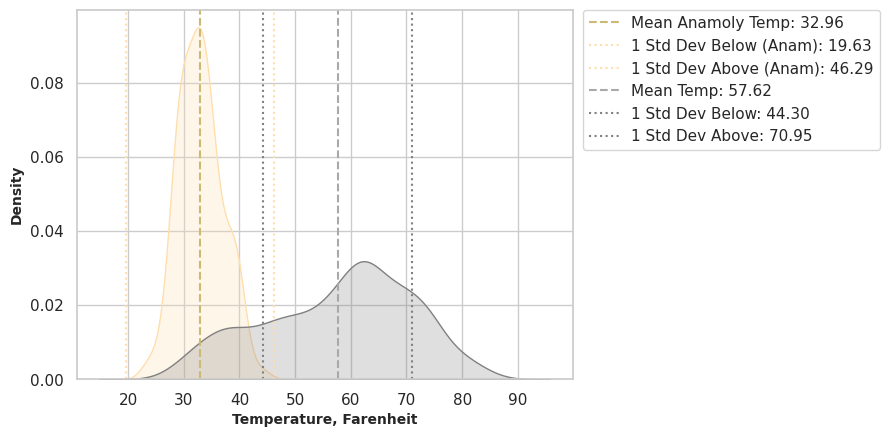

In [ ]:
# 2021 Winter:
threshold_nn_h_win_21_PPWA = anomaly_scores_nn_h_win_21_PPWA.quantile(0.95)
anomalous_nn_h_win_21_PPWA = anomaly_scores_nn_h_win_21_PPWA > threshold_nn_h_win_21_PPWA
binary_labels_nn_h_win_21_PPWA = anomalous_nn_h_win_21_PPWA.astype(int)
precision_nn_h_win_21_PPWA, recall_nn_h_win_21_PPWA, f1_score_nn_h_win_21_PPWA, _ = precision_recall_fscore_support(binary_labels_nn_h_win_21_PPWA, anomalous_nn_h_win_21_PPWA, average='binary')

test_nn_h_win_21_PPWA = dc_nn_h_win_21_PPWA['EnergyUse'].values
predictions_nn_h_win_21_PPWA = anomaly_scores_nn_h_win_21_PPWA.values

print("Precision: ", precision_nn_h_win_21_PPWA)
print("Recall: ", recall_nn_h_win_21_PPWA)
print("F1 Score: ", f1_score_nn_h_win_21_PPWA)

# Plot the data with anomalies marked in red
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(dc_nn_h_win_21_PPWA['timestamp'], dc_nn_h_win_21_PPWA['EnergyUse'], color='b')
plt.scatter(dc_nn_h_win_21_PPWA['timestamp'][anomalous_nn_h_win_21_PPWA], dc_nn_h_win_21_PPWA['EnergyUse'][anomalous_nn_h_win_21_PPWA], marker='o', color='blue')
plt.xlabel('Hour, Day, Month, Year', fontweight ='bold', fontsize = 10)
plt.ylabel('Hourly Energy Consumption (kWh)', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 2160, 96))
plt.tick_params(axis ='x', rotation = -90)
plt.show()

# Isolate the anomalous values
anomalous_nn_h_win_21_PPWA_true = dc_nn_h_win_21_PPWA[anomalous_nn_h_win_21_PPWA]

anomalous_nn_h_win_21_PPWA_weather = b1_hourly_win_21[anomalous_nn_h_win_21_PPWA]

anomalous_nn_h_win_21_PPWA_weather = anomalous_nn_h_win_21_PPWA_weather[['Hour', 'Day', 'Month', 'Year', 'EnergyUse', 'Temp', 'RelHum', 'Humidity', 'UVIndex']]
print(anomalous_nn_h_win_21_PPWA_weather)

# Visualize distrubution of anamolous temperatures
anamalous_temp_nn_h_win_21_mean = np.mean(anomalous_nn_h_win_21_PPWA_weather['Temp'])
anamalous_temp_nn_h_win_21_std_dev = np.std(anomalous_nn_h_win_21_PPWA_weather['Temp'])

temp_nn_h_win_21_mean = np.mean(b1_hourly_win_21['Temp'])
temp_nn_h_win_21_std_dev = np.std(b1_hourly_win_21['Temp'])

sns.set(style='whitegrid')
sns.kdeplot(anomalous_nn_h_win_21_PPWA_weather['Temp'], fill=True, color="b")
plt.axvline(anamalous_temp_nn_h_win_21_mean, color='blue', linestyle='--', label=f'Mean Anamoly Temp: {anamalous_temp_nn_h_win_21_mean:.2f}')
plt.axvline(anamalous_temp_nn_h_win_21_mean - temp_nn_h_win_21_std_dev, color='b', linestyle=':', label=f'1 Std Dev Below (Anam): {anamalous_temp_nn_h_win_21_mean - temp_nn_h_win_21_std_dev:.2f}')
plt.axvline(anamalous_temp_nn_h_win_21_mean + temp_nn_h_win_21_std_dev, color='b', linestyle=':', label=f'1 Std Dev Above (Anam): {anamalous_temp_nn_h_win_21_mean + temp_nn_h_win_21_std_dev:.2f}')

sns.kdeplot(b1_hourly_win_21['Temp'], fill=True, color="grey")
plt.axvline(temp_nn_h_win_21_mean, color='darkgrey', linestyle='--', label=f'Mean Temp: {temp_nn_h_win_21_mean:.2f}')
plt.axvline(temp_nn_h_win_21_mean - temp_nn_h_win_21_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Below: {temp_nn_h_win_21_mean - temp_nn_h_win_21_std_dev:.2f}')
plt.axvline(temp_nn_h_win_21_mean + temp_nn_h_win_21_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Above: {temp_nn_h_win_21_mean + temp_nn_h_win_21_std_dev:.2f}')

plt.xlabel('Temperature, Farenheit', fontweight ='bold', fontsize = 10)
plt.ylabel('Density', fontweight ='bold', fontsize = 10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# 2021 Spring:
threshold_nn_h_spr_21_PPWA = anomaly_scores_nn_h_spr_21_PPWA.quantile(0.95)
anomalous_nn_h_spr_21_PPWA = anomaly_scores_nn_h_spr_21_PPWA > threshold_nn_h_spr_21_PPWA
binary_labels_nn_h_spr_21_PPWA = anomalous_nn_h_spr_21_PPWA.astype(int)
precision_nn_h_spr_21_PPWA, recall_nn_h_spr_21_PPWA, f1_score_nn_h_spr_21_PPWA, _ = precision_recall_fscore_support(binary_labels_nn_h_spr_21_PPWA, anomalous_nn_h_spr_21_PPWA, average='binary')

test_nn_h_spr_21_PPWA = dc_nn_h_spr_21_PPWA['EnergyUse'].values
predictions_nn_h_spr_21_PPWA = anomaly_scores_nn_h_spr_21_PPWA.values

print("Precision: ", precision_nn_h_spr_21_PPWA)
print("Recall: ", recall_nn_h_spr_21_PPWA)
print("F1 Score: ", f1_score_nn_h_spr_21_PPWA)

# Plot the data with anomalies marked in red
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(dc_nn_h_spr_21_PPWA['timestamp'], dc_nn_h_spr_21_PPWA['EnergyUse'], color='g')
plt.scatter(dc_nn_h_spr_21_PPWA['timestamp'][anomalous_nn_h_spr_21_PPWA], dc_nn_h_spr_21_PPWA['EnergyUse'][anomalous_nn_h_spr_21_PPWA], marker='o', color='green')
plt.xlabel('Hour, Day, Month, Year', fontweight ='bold', fontsize = 10)
plt.ylabel('Hourly Energy Consumption (kWh)', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 2160, 96))
plt.tick_params(axis ='x', rotation = -90)
plt.show()

# Isolate the anomalous values
anomalous_nn_h_spr_21_PPWA_true = dc_nn_h_spr_21_PPWA[anomalous_nn_h_spr_21_PPWA]

anomalous_nn_h_spr_21_PPWA_weather = b1_hourly_spr_21[anomalous_nn_h_spr_21_PPWA]

anomalous_nn_h_spr_21_PPWA_weather = anomalous_nn_h_spr_21_PPWA_weather[['Hour', 'Day', 'Month', 'Year', 'EnergyUse', 'Temp', 'RelHum', 'Humidity', 'UVIndex']]
print(anomalous_nn_h_spr_21_PPWA_weather)

# Visualize distrubution of anamolous temperatures
anamalous_temp_nn_h_spr_21_mean = np.mean(anomalous_nn_h_spr_21_PPWA_weather['Temp'])
anamalous_temp_nn_h_spr_21_std_dev = np.std(anomalous_nn_h_spr_21_PPWA_weather['Temp'])

temp_nn_h_spr_21_mean = np.mean(b1_hourly_spr_21['Temp'])
temp_nn_h_spr_21_std_dev = np.std(b1_hourly_spr_21['Temp'])

sns.set(style='whitegrid')
sns.kdeplot(anomalous_nn_h_spr_21_PPWA_weather['Temp'], fill=True, color="g")
plt.axvline(anamalous_temp_nn_h_spr_21_mean, color='green', linestyle='--', label=f'Mean Anamoly Temp: {anamalous_temp_nn_h_spr_21_mean:.2f}')
plt.axvline(anamalous_temp_nn_h_spr_21_mean - temp_nn_h_spr_21_std_dev, color='g', linestyle=':', label=f'1 Std Dev Below (Anam): {anamalous_temp_nn_h_spr_21_mean - temp_nn_h_spr_21_std_dev:.2f}')
plt.axvline(anamalous_temp_nn_h_spr_21_mean + temp_nn_h_spr_21_std_dev, color='g', linestyle=':', label=f'1 Std Dev Above (Anam): {anamalous_temp_nn_h_spr_21_mean + temp_nn_h_spr_21_std_dev:.2f}')

sns.kdeplot(b1_hourly_spr_21['Temp'], fill=True, color="grey")
plt.axvline(temp_nn_h_spr_21_mean, color='darkgrey', linestyle='--', label=f'Mean Temp: {temp_nn_h_spr_21_mean:.2f}')
plt.axvline(temp_nn_h_spr_21_mean - temp_nn_h_spr_21_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Below: {temp_nn_h_spr_21_mean - temp_nn_h_spr_21_std_dev:.2f}')
plt.axvline(temp_nn_h_spr_21_mean + temp_nn_h_spr_21_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Above: {temp_nn_h_spr_21_mean + temp_nn_h_spr_21_std_dev:.2f}')

plt.xlabel('Temperature, Farenheit', fontweight ='bold', fontsize = 10)
plt.ylabel('Density', fontweight ='bold', fontsize = 10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# 2021 Summer:
threshold_nn_h_sum_21_PPWA = anomaly_scores_nn_h_sum_21_PPWA.quantile(0.95)
anomalous_nn_h_sum_21_PPWA = anomaly_scores_nn_h_sum_21_PPWA > threshold_nn_h_sum_21_PPWA
binary_labels_nn_h_sum_21_PPWA = anomalous_nn_h_sum_21_PPWA.astype(int)
precision_nn_h_sum_21_PPWA, recall_nn_h_sum_21_PPWA, f1_score_nn_h_sum_21_PPWA, _ = precision_recall_fscore_support(binary_labels_nn_h_sum_21_PPWA, anomalous_nn_h_sum_21_PPWA, average='binary')

test_nn_h_sum_21_PPWA = dc_nn_h_sum_21_PPWA['EnergyUse'].values
predictions_nn_h_sum_21_PPWA = anomaly_scores_nn_h_sum_21_PPWA.values

print("Precision: ", precision_nn_h_sum_21_PPWA)
print("Recall: ", recall_nn_h_sum_21_PPWA)
print("F1 Score: ", f1_score_nn_h_sum_21_PPWA)

# Plot the data with anomalies marked in red
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(dc_nn_h_sum_21_PPWA['timestamp'], dc_nn_h_sum_21_PPWA['EnergyUse'], color='r')
plt.scatter(dc_nn_h_sum_21_PPWA['timestamp'][anomalous_nn_h_sum_21_PPWA], dc_nn_h_sum_21_PPWA['EnergyUse'][anomalous_nn_h_sum_21_PPWA], marker='o', color='red')
plt.xlabel('Hour, Day, Month, Year', fontweight ='bold', fontsize = 10)
plt.ylabel('Hourly Energy Consumption (kWh)', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 2160, 96))
plt.tick_params(axis ='x', rotation = -90)
plt.show()

# Isolate the anomalous values
anomalous_nn_h_sum_21_PPWA_true = dc_nn_h_sum_21_PPWA[anomalous_nn_h_sum_21_PPWA]

anomalous_nn_h_sum_21_PPWA_weather = b1_hourly_sum_21[anomalous_nn_h_sum_21_PPWA]

anomalous_nn_h_sum_21_PPWA_weather = anomalous_nn_h_sum_21_PPWA_weather[['Hour', 'Day', 'Month', 'Year', 'EnergyUse', 'Temp', 'RelHum', 'Humidity', 'UVIndex']]
print(anomalous_nn_h_sum_21_PPWA_weather)

# Visualize distrubution of anamolous temperatures
anamalous_temp_nn_h_sum_21_mean = np.mean(anomalous_nn_h_sum_21_PPWA_weather['Temp'])
anamalous_temp_nn_h_sum_21_std_dev = np.std(anomalous_nn_h_sum_21_PPWA_weather['Temp'])

temp_nn_h_sum_21_mean = np.mean(b1_hourly_sum_21['Temp'])
temp_nn_h_sum_21_std_dev = np.std(b1_hourly_sum_21['Temp'])

sns.set(style='whitegrid')
sns.kdeplot(anomalous_nn_h_sum_21_PPWA_weather['Temp'], fill=True, color="r")
plt.axvline(anamalous_temp_nn_h_sum_21_mean, color='red', linestyle='--', label=f'Mean Anamoly Temp: {anamalous_temp_nn_h_sum_21_mean:.2f}')
plt.axvline(anamalous_temp_nn_h_sum_21_mean - temp_nn_h_sum_21_std_dev, color='r', linestyle=':', label=f'1 Std Dev Below (Anam): {anamalous_temp_nn_h_sum_21_mean - temp_nn_h_sum_21_std_dev:.2f}')
plt.axvline(anamalous_temp_nn_h_sum_21_mean + temp_nn_h_sum_21_std_dev, color='r', linestyle=':', label=f'1 Std Dev Above (Anam): {anamalous_temp_nn_h_sum_21_mean + temp_nn_h_sum_21_std_dev:.2f}')

sns.kdeplot(b1_hourly_sum_21['Temp'], fill=True, color="grey")
plt.axvline(temp_nn_h_sum_21_mean, color='darkgrey', linestyle='--', label=f'Mean Temp: {temp_nn_h_sum_21_mean:.2f}')
plt.axvline(temp_nn_h_sum_21_mean - temp_nn_h_sum_21_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Below: {temp_nn_h_sum_21_mean - temp_nn_h_sum_21_std_dev:.2f}')
plt.axvline(temp_nn_h_sum_21_mean + temp_nn_h_sum_21_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Above: {temp_nn_h_sum_21_mean + temp_nn_h_sum_21_std_dev:.2f}')

plt.xlabel('Temperature, Farenheit', fontweight ='bold', fontsize = 10)
plt.ylabel('Density', fontweight ='bold', fontsize = 10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# 2021 Fall
threshold_nn_h_fal_21_PPWA = anomaly_scores_nn_h_fal_21_PPWA.quantile(0.95)
anomalous_nn_h_fal_21_PPWA = anomaly_scores_nn_h_fal_21_PPWA > threshold_nn_h_fal_21_PPWA
binary_labels_nn_h_fal_21_PPWA = anomalous_nn_h_fal_21_PPWA.astype(int)
precision_nn_h_fal_21_PPWA, recall_nn_h_fal_21_PPWA, f1_score_nn_h_fal_21_PPWA, _ = precision_recall_fscore_support(binary_labels_nn_h_fal_21_PPWA, anomalous_nn_h_fal_21_PPWA, average='binary')

test_nn_h_fal_21_PPWA = dc_nn_h_fal_21_PPWA['EnergyUse'].values
predictions_nn_h_fal_21_PPWA = anomaly_scores_nn_h_fal_21_PPWA.values

print("Precision: ", precision_nn_h_fal_21_PPWA)
print("Recall: ", recall_nn_h_fal_21_PPWA)
print("F1 Score: ", f1_score_nn_h_fal_21_PPWA)

# Plot the data with anomalies marked in red
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(dc_nn_h_fal_21_PPWA['timestamp'], dc_nn_h_fal_21_PPWA['EnergyUse'], color='navajowhite')
plt.scatter(dc_nn_h_fal_21_PPWA['timestamp'][anomalous_nn_h_fal_21_PPWA], dc_nn_h_fal_21_PPWA['EnergyUse'][anomalous_nn_h_fal_21_PPWA], marker='o', color='y')
plt.xlabel('Hour, Day, Month, Year', fontweight ='bold', fontsize = 10)
plt.ylabel('Hourly Energy Confalption (kWh)', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 2160, 96))
plt.tick_params(axis ='x', rotation = -90)
plt.show()

# Isolate the anomalous values
anomalous_nn_h_fal_21_PPWA_true = dc_nn_h_fal_21_PPWA[anomalous_nn_h_fal_21_PPWA]

anomalous_nn_h_fal_21_PPWA_weather = b1_hourly_fal_21[anomalous_nn_h_fal_21_PPWA]

anomalous_nn_h_fal_21_PPWA_weather = anomalous_nn_h_fal_21_PPWA_weather[['Hour', 'Day', 'Month', 'Year', 'EnergyUse', 'Temp', 'RelHum', 'Humidity', 'UVIndex']]
print(anomalous_nn_h_fal_21_PPWA_weather)

# Visualize distrubution of anamolous temperatures
anamalous_temp_nn_h_fal_21_mean = np.mean(anomalous_nn_h_fal_21_PPWA_weather['Temp'])
anamalous_temp_nn_h_fal_21_std_dev = np.std(anomalous_nn_h_fal_21_PPWA_weather['Temp'])

temp_nn_h_fal_21_mean = np.mean(b1_hourly_fal_21['Temp'])
temp_nn_h_fal_21_std_dev = np.std(b1_hourly_fal_21['Temp'])

sns.set(style='whitegrid')
sns.kdeplot(anomalous_nn_h_fal_21_PPWA_weather['Temp'], fill=True, color="navajowhite")
plt.axvline(anamalous_temp_nn_h_fal_21_mean, color='y', linestyle='--', label=f'Mean Anamoly Temp: {anamalous_temp_nn_h_fal_21_mean:.2f}')
plt.axvline(anamalous_temp_nn_h_fal_21_mean - temp_nn_h_fal_21_std_dev, color='navajowhite', linestyle=':', label=f'1 Std Dev Below (Anam): {anamalous_temp_nn_h_fal_21_mean - temp_nn_h_fal_21_std_dev:.2f}')
plt.axvline(anamalous_temp_nn_h_fal_21_mean + temp_nn_h_fal_21_std_dev, color='navajowhite', linestyle=':', label=f'1 Std Dev Above (Anam): {anamalous_temp_nn_h_fal_21_mean + temp_nn_h_fal_21_std_dev:.2f}')

sns.kdeplot(b1_hourly_fal_21['Temp'], fill=True, color="grey")
plt.axvline(temp_nn_h_fal_21_mean, color='darkgrey', linestyle='--', label=f'Mean Temp: {temp_nn_h_fal_21_mean:.2f}')
plt.axvline(temp_nn_h_fal_21_mean - temp_nn_h_fal_21_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Below: {temp_nn_h_fal_21_mean - temp_nn_h_fal_21_std_dev:.2f}')
plt.axvline(temp_nn_h_fal_21_mean + temp_nn_h_fal_21_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Above: {temp_nn_h_fal_21_mean + temp_nn_h_fal_21_std_dev:.2f}')

plt.xlabel('Temperature, Farenheit', fontweight ='bold', fontsize = 10)
plt.ylabel('Density', fontweight ='bold', fontsize = 10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# ^ Fitting (2022 All Seasons)

In [ ]:
# 2022 Winter:
# Exclude datetime column
dt_nn_h_win_22_PPWA = tf.convert_to_tensor(dc_nn_h_win_22_PPWA.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# Define the autoencoder model
input_dim_nn_h_win_22_PPWA = dc_nn_h_win_22_PPWA.shape[1] - 1
encoding_dim_nn_h_win_22_PPWA = 10

input_layer_nn_h_win_22_PPWA = Input(shape=(input_dim_nn_h_win_22_PPWA,))
encoder_nn_h_win_22_PPWA = Dense(encoding_dim_nn_h_win_22_PPWA, activation='relu')(input_layer_nn_h_win_22_PPWA)
decoder_nn_h_win_22_PPWA = Dense(input_dim_nn_h_win_22_PPWA, activation='relu')(encoder_nn_h_win_22_PPWA)
autoencoder_nn_h_win_22_PPWA = Model(inputs=input_layer_nn_h_win_22_PPWA, outputs=decoder_nn_h_win_22_PPWA)

# Compile and fit the model
autoencoder_nn_h_win_22_PPWA.compile(optimizer='adam', loss='mae')
autoencoder_nn_h_win_22_PPWA.fit(dt_nn_h_win_22_PPWA, dt_nn_h_win_22_PPWA, epochs=30,
				batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions_nn_h_win_22_PPWA = autoencoder_nn_h_win_22_PPWA.predict(dt_nn_h_win_22_PPWA)
mae_nn_h_win_22_PPWA = tf.reduce_mean(tf.square(dt_nn_h_win_22_PPWA - reconstructions_nn_h_win_22_PPWA),
					axis=1)
anomaly_scores_nn_h_win_22_PPWA = pd.Series(mae_nn_h_win_22_PPWA.numpy(), name='anomaly_scores')
anomaly_scores_nn_h_win_22_PPWA.index = dc_nn_h_win_22_PPWA.index

# 2022 Spring:
# Exclude datetime column
dt_nn_h_spr_22_PPWA = tf.convert_to_tensor(dc_nn_h_spr_22_PPWA.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# Define the autoencoder model
input_dim_nn_h_spr_22_PPWA = dc_nn_h_spr_22_PPWA.shape[1] - 1
encoding_dim_nn_h_spr_22_PPWA = 10

input_layer_nn_h_spr_22_PPWA = Input(shape=(input_dim_nn_h_spr_22_PPWA,))
encoder_nn_h_spr_22_PPWA = Dense(encoding_dim_nn_h_spr_22_PPWA, activation='relu')(input_layer_nn_h_spr_22_PPWA)
decoder_nn_h_spr_22_PPWA = Dense(input_dim_nn_h_spr_22_PPWA, activation='relu')(encoder_nn_h_spr_22_PPWA)
autoencoder_nn_h_spr_22_PPWA = Model(inputs=input_layer_nn_h_spr_22_PPWA, outputs=decoder_nn_h_spr_22_PPWA)

# Compile and fit the model
autoencoder_nn_h_spr_22_PPWA.compile(optimizer='adam', loss='mae')
autoencoder_nn_h_spr_22_PPWA.fit(dt_nn_h_spr_22_PPWA, dt_nn_h_spr_22_PPWA, epochs=30,
				batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions_nn_h_spr_22_PPWA = autoencoder_nn_h_spr_22_PPWA.predict(dt_nn_h_spr_22_PPWA)
mae_nn_h_spr_22_PPWA = tf.reduce_mean(tf.square(dt_nn_h_spr_22_PPWA - reconstructions_nn_h_spr_22_PPWA),
					axis=1)
anomaly_scores_nn_h_spr_22_PPWA = pd.Series(mae_nn_h_spr_22_PPWA.numpy(), name='anomaly_scores')
anomaly_scores_nn_h_spr_22_PPWA.index = dc_nn_h_spr_22_PPWA.index

# 2022 Summer:
# Exclude datetime column
dt_nn_h_sum_22_PPWA = tf.convert_to_tensor(dc_nn_h_sum_22_PPWA.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# Define the autoencoder model
input_dim_nn_h_sum_22_PPWA = dc_nn_h_sum_22_PPWA.shape[1] - 1
encoding_dim_nn_h_sum_22_PPWA = 10

input_layer_nn_h_sum_22_PPWA = Input(shape=(input_dim_nn_h_sum_22_PPWA,))
encoder_nn_h_sum_22_PPWA = Dense(encoding_dim_nn_h_sum_22_PPWA, activation='relu')(input_layer_nn_h_sum_22_PPWA)
decoder_nn_h_sum_22_PPWA = Dense(input_dim_nn_h_sum_22_PPWA, activation='relu')(encoder_nn_h_sum_22_PPWA)
autoencoder_nn_h_sum_22_PPWA = Model(inputs=input_layer_nn_h_sum_22_PPWA, outputs=decoder_nn_h_sum_22_PPWA)

# Compile and fit the model
autoencoder_nn_h_sum_22_PPWA.compile(optimizer='adam', loss='mae')
autoencoder_nn_h_sum_22_PPWA.fit(dt_nn_h_sum_22_PPWA, dt_nn_h_sum_22_PPWA, epochs=30,
				batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions_nn_h_sum_22_PPWA = autoencoder_nn_h_sum_22_PPWA.predict(dt_nn_h_sum_22_PPWA)
mae_nn_h_sum_22_PPWA = tf.reduce_mean(tf.square(dt_nn_h_sum_22_PPWA - reconstructions_nn_h_sum_22_PPWA),
					axis=1)
anomaly_scores_nn_h_sum_22_PPWA = pd.Series(mae_nn_h_sum_22_PPWA.numpy(), name='anomaly_scores')
anomaly_scores_nn_h_sum_22_PPWA.index = dc_nn_h_sum_22_PPWA.index

# 2022 Fall:
# Exclude datetime column
dt_nn_h_fal_22_PPWA = tf.convert_to_tensor(dc_nn_h_fal_22_PPWA.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# Define the autoencoder model
input_dim_nn_h_fal_22_PPWA = dc_nn_h_fal_22_PPWA.shape[1] - 1
encoding_dim_nn_h_fal_22_PPWA = 10

input_layer_nn_h_fal_22_PPWA = Input(shape=(input_dim_nn_h_fal_22_PPWA,))
encoder_nn_h_fal_22_PPWA = Dense(encoding_dim_nn_h_fal_22_PPWA, activation='relu')(input_layer_nn_h_fal_22_PPWA)
decoder_nn_h_fal_22_PPWA = Dense(input_dim_nn_h_fal_22_PPWA, activation='relu')(encoder_nn_h_fal_22_PPWA)
autoencoder_nn_h_fal_22_PPWA = Model(inputs=input_layer_nn_h_fal_22_PPWA, outputs=decoder_nn_h_fal_22_PPWA)

# Compile and fit the model
autoencoder_nn_h_fal_22_PPWA.compile(optimizer='adam', loss='mae')
autoencoder_nn_h_fal_22_PPWA.fit(dt_nn_h_fal_22_PPWA, dt_nn_h_fal_22_PPWA, epochs=30,
				batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions_nn_h_fal_22_PPWA = autoencoder_nn_h_fal_22_PPWA.predict(dt_nn_h_fal_22_PPWA)
mae_nn_h_fal_22_PPWA = tf.reduce_mean(tf.square(dt_nn_h_fal_22_PPWA - reconstructions_nn_h_fal_22_PPWA),
					axis=1)
anomaly_scores_nn_h_fal_22_PPWA = pd.Series(mae_nn_h_fal_22_PPWA.numpy(), name='anomaly_scores')
anomaly_scores_nn_h_fal_22_PPWA.index = dc_nn_h_fal_22_PPWA.index

Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 272.2035
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 273.3028
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 273.6255
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 273.0303
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 275.3464
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 273.9295
Epoch 7/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 273.6547
Epoch 8/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 273.1967
Epoch 9/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 275.5454
Epoch 10/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 270.0694
Epoch 11/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 274.9413
Epoch 12/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 275.8183
Epoch 13/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 272.2519
Epoch 14/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 271.6841
Epoch 15/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


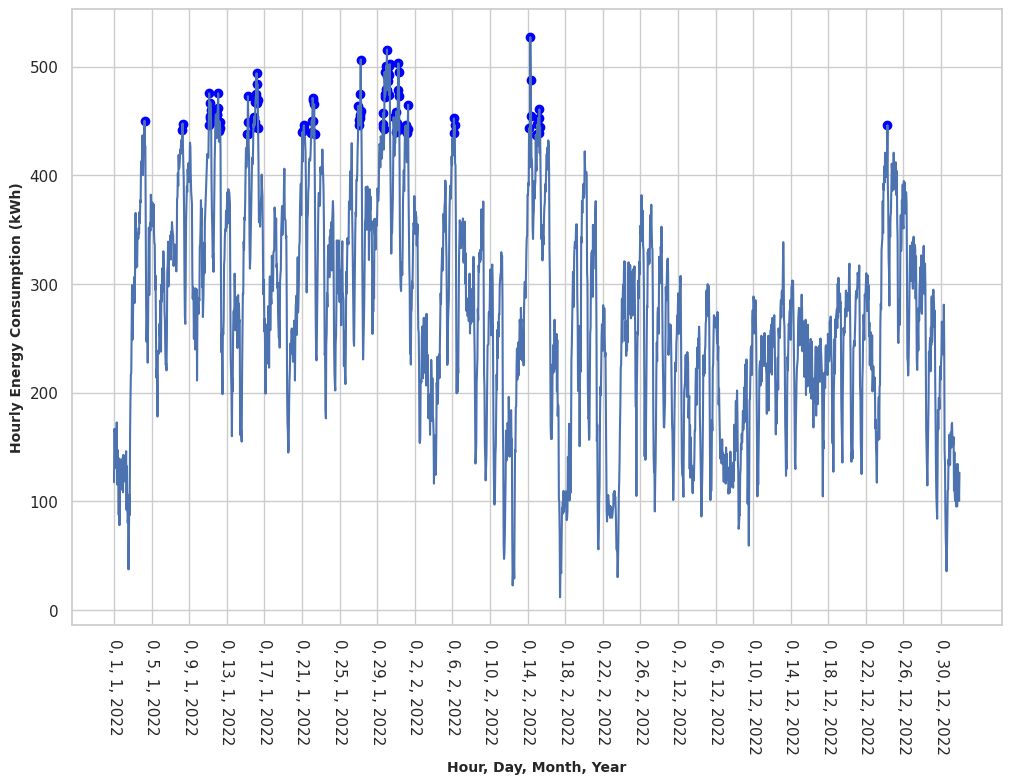

      Hour Day Month  Year EnergyUse  Temp RelHum Humidity UVIndex
26382    6   4     1  2022    450.24  19.1    9.0    64.02       0
26478    6   8     1  2022    441.84  19.1    6.1    56.33       0
26479    7   8     1  2022    447.72  18.0    6.1    59.04       0
26546    2  11     1  2022    446.04  20.2    7.9    58.31       0
26547    3  11     1  2022    475.44  19.3   -0.9    40.44       0
...    ...  ..   ...   ...       ...   ...    ...      ...     ...
27388    4  15     2  2022    453.18  12.1    3.8    68.87       0
27389    5  15     2  2022     438.9  12.0    2.9    66.39       0
27390    6  15     2  2022    460.74  10.2    2.1     69.3       0
27392    8  15     2  2022    444.36  14.2    3.8    62.55       0
34879    7  24    12  2022    446.04   5.0   -9.1    51.23       0

[107 rows x 9 columns]


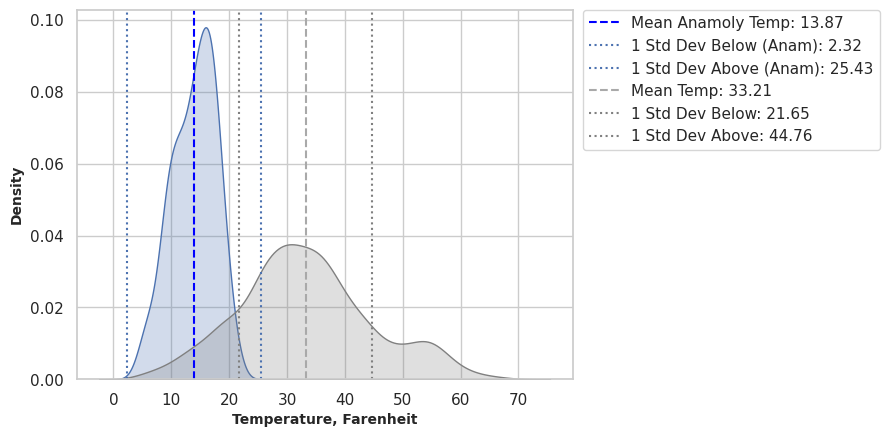

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


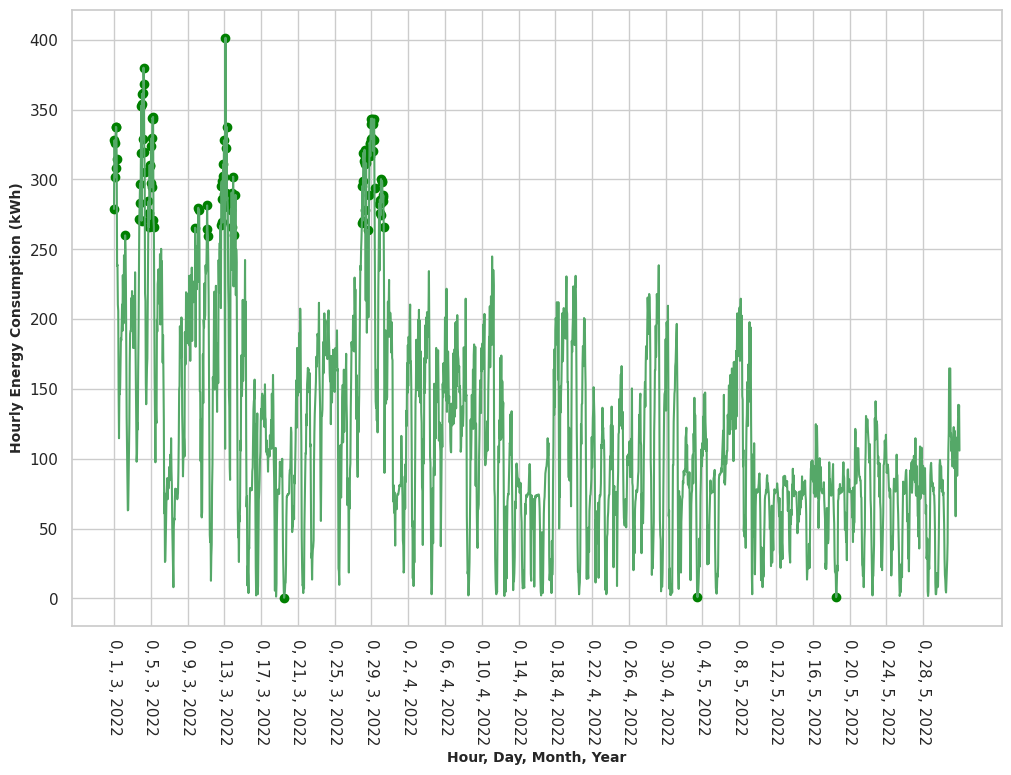

      Hour Day Month  Year EnergyUse  Temp RelHum Humidity UVIndex
27720    0   1     3  2022    278.88  29.8   16.8    58.02       0
27721    1   1     3  2022    328.02  29.0   17.6    62.17       0
27722    2   1     3  2022    326.34  29.8   17.9    60.82       0
27723    3   1     3  2022    301.56  29.1   17.9    62.67       0
27724    4   1     3  2022    308.28  28.9   18.9     65.9       0
...    ...  ..   ...   ...       ...   ...    ...      ...     ...
28422    6  30     3  2022    284.76  24.3   14.9    67.04       0
28423    7  30     3  2022    288.54  28.2   14.1     55.1       1
28424    8  30     3  2022    266.28  30.9   13.9    48.73       1
29243   11   3     5  2022      0.84  64.3   52.1    64.56       7
29605   13  18     5  2022      0.84  67.1   44.0    43.18      10

[110 rows x 9 columns]


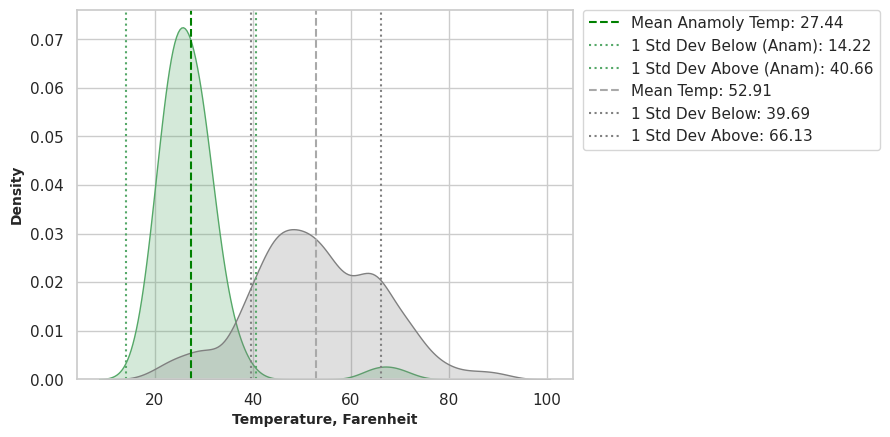

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


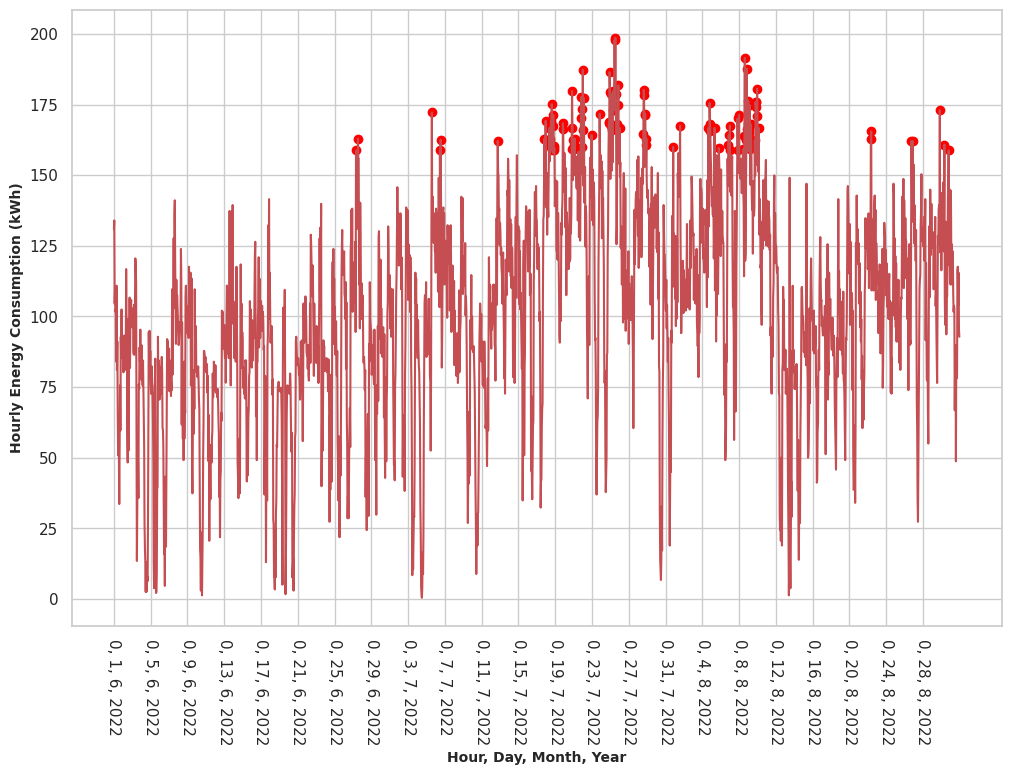

      Hour Day Month  Year EnergyUse  Temp RelHum Humidity UVIndex
30560    8  27     6  2022    158.76  73.4   69.9    88.75       1
30565   13  27     6  2022    162.96  74.9   70.1    84.87       1
30758   14   5     7  2022     172.2  81.1   65.0     58.3       1
30779   11   6     7  2022    158.76  84.3   68.1    58.42       3
30781   13   6     7  2022    162.54  84.8   66.9    55.06       2
...    ...  ..   ...   ...       ...   ...    ...      ...     ...
32010   18  26     8  2022    162.12  84.9   63.0    47.93       1
32013   21  26     8  2022    162.12  79.9   66.0    62.47       0
32084   20  29     8  2022    173.04  79.1   69.0    71.15       0
32096    8  30     8  2022    160.86  78.1   73.0    84.58       2
32107   19  30     8  2022    158.76  78.8   67.0    67.25       0

[110 rows x 9 columns]


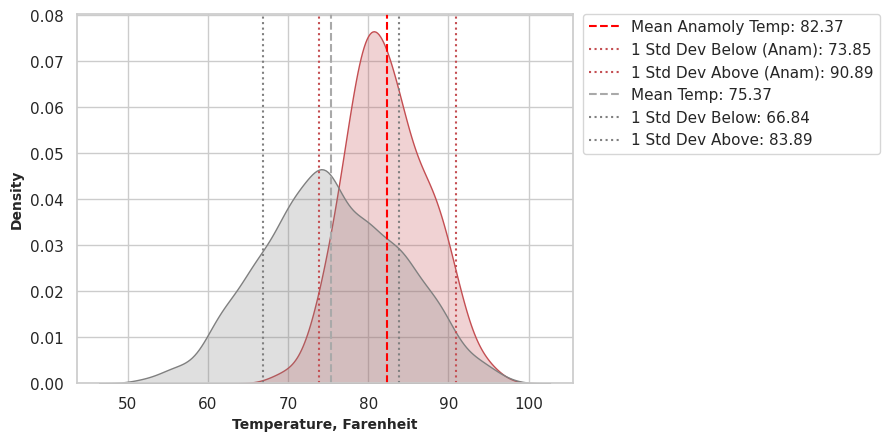

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


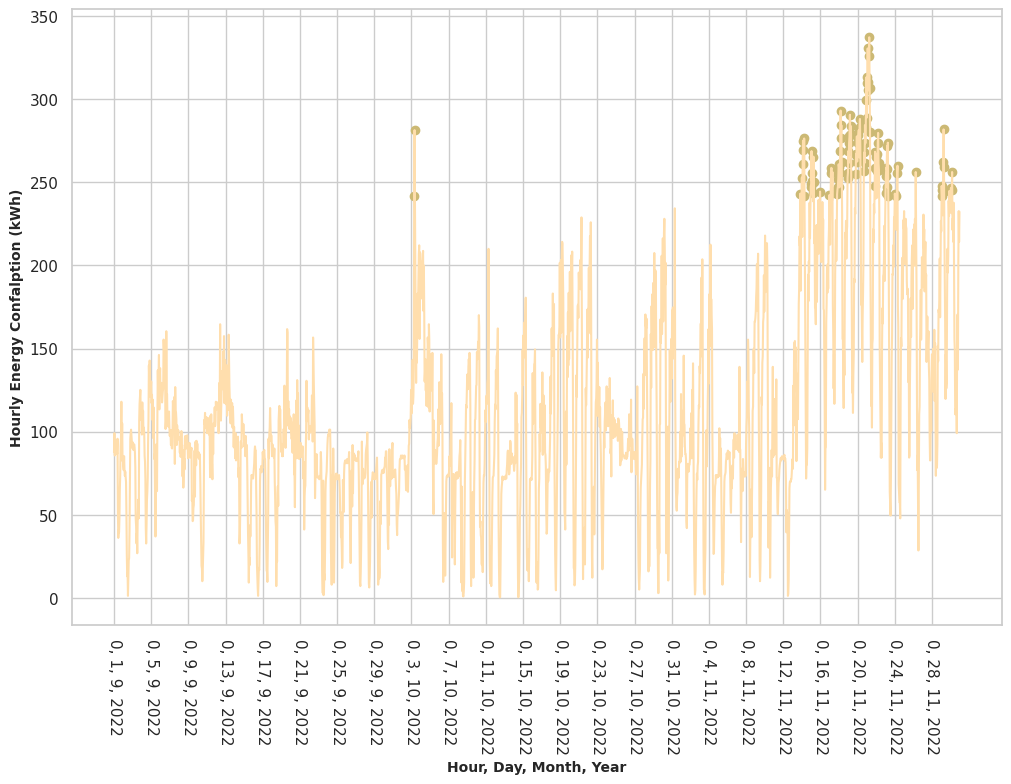

      Hour Day Month  Year EnergyUse  Temp RelHum Humidity UVIndex
32911    7   3    10  2022     241.5  45.1   42.1    89.25       0
32912    8   3    10  2022     281.4  46.2   42.1    85.64       0
33908   20  13    11  2022    243.18  41.0   26.0    54.94       0
33912    0  14    11  2022    252.84  38.1   28.1    66.98       0
33914    2  14    11  2022    261.24  37.1   28.0    69.37       0
...    ...  ..   ...   ...       ...   ...    ...      ...     ...
34279    7  29    11  2022    259.14  27.0   25.1    92.39       0
34293   21  29    11  2022    244.86  35.1   27.0    72.08       0
34297    1  30    11  2022    246.54  34.2   29.1    81.35       0
34299    3  30    11  2022    245.28  35.2   30.0    81.03       0
34300    4  30    11  2022     256.2  36.1   30.9     81.2       0

[109 rows x 9 columns]


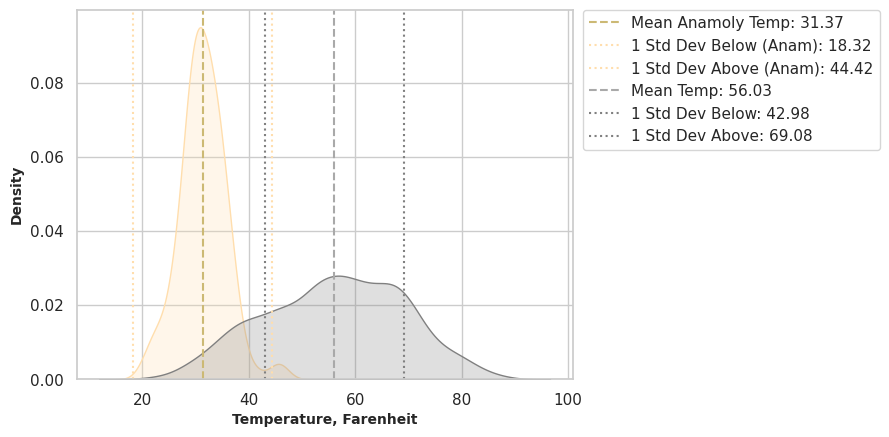

In [ ]:
# 2022 Winter:
threshold_nn_h_win_22_PPWA = anomaly_scores_nn_h_win_22_PPWA.quantile(0.95)
anomalous_nn_h_win_22_PPWA = anomaly_scores_nn_h_win_22_PPWA > threshold_nn_h_win_22_PPWA
binary_labels_nn_h_win_22_PPWA = anomalous_nn_h_win_22_PPWA.astype(int)
precision_nn_h_win_22_PPWA, recall_nn_h_win_22_PPWA, f1_score_nn_h_win_22_PPWA, _ = precision_recall_fscore_support(binary_labels_nn_h_win_22_PPWA, anomalous_nn_h_win_22_PPWA, average='binary')

test_nn_h_win_22_PPWA = dc_nn_h_win_22_PPWA['EnergyUse'].values
predictions_nn_h_win_22_PPWA = anomaly_scores_nn_h_win_22_PPWA.values

print("Precision: ", precision_nn_h_win_22_PPWA)
print("Recall: ", recall_nn_h_win_22_PPWA)
print("F1 Score: ", f1_score_nn_h_win_22_PPWA)

# Plot the data with anomalies marked in red
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(dc_nn_h_win_22_PPWA['timestamp'], dc_nn_h_win_22_PPWA['EnergyUse'], color='b')
plt.scatter(dc_nn_h_win_22_PPWA['timestamp'][anomalous_nn_h_win_22_PPWA], dc_nn_h_win_22_PPWA['EnergyUse'][anomalous_nn_h_win_22_PPWA], marker='o', color='blue')
plt.xlabel('Hour, Day, Month, Year', fontweight ='bold', fontsize = 10)
plt.ylabel('Hourly Energy Consumption (kWh)', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 2160, 96))
plt.tick_params(axis ='x', rotation = -90)
plt.show()

# Isolate the anomalous values
anomalous_nn_h_win_22_PPWA_true = dc_nn_h_win_22_PPWA[anomalous_nn_h_win_22_PPWA]

anomalous_nn_h_win_22_PPWA_weather = b1_hourly_win_22[anomalous_nn_h_win_22_PPWA]

anomalous_nn_h_win_22_PPWA_weather = anomalous_nn_h_win_22_PPWA_weather[['Hour', 'Day', 'Month', 'Year', 'EnergyUse', 'Temp', 'RelHum', 'Humidity', 'UVIndex']]
print(anomalous_nn_h_win_22_PPWA_weather)

# Visualize distrubution of anamolous temperatures
anamalous_temp_nn_h_win_22_mean = np.mean(anomalous_nn_h_win_22_PPWA_weather['Temp'])
anamalous_temp_nn_h_win_22_std_dev = np.std(anomalous_nn_h_win_22_PPWA_weather['Temp'])

temp_nn_h_win_22_mean = np.mean(b1_hourly_win_22['Temp'])
temp_nn_h_win_22_std_dev = np.std(b1_hourly_win_22['Temp'])

sns.set(style='whitegrid')
sns.kdeplot(anomalous_nn_h_win_22_PPWA_weather['Temp'], fill=True, color="b")
plt.axvline(anamalous_temp_nn_h_win_22_mean, color='blue', linestyle='--', label=f'Mean Anamoly Temp: {anamalous_temp_nn_h_win_22_mean:.2f}')
plt.axvline(anamalous_temp_nn_h_win_22_mean - temp_nn_h_win_22_std_dev, color='b', linestyle=':', label=f'1 Std Dev Below (Anam): {anamalous_temp_nn_h_win_22_mean - temp_nn_h_win_22_std_dev:.2f}')
plt.axvline(anamalous_temp_nn_h_win_22_mean + temp_nn_h_win_22_std_dev, color='b', linestyle=':', label=f'1 Std Dev Above (Anam): {anamalous_temp_nn_h_win_22_mean + temp_nn_h_win_22_std_dev:.2f}')

sns.kdeplot(b1_hourly_win_22['Temp'], fill=True, color="grey")
plt.axvline(temp_nn_h_win_22_mean, color='darkgrey', linestyle='--', label=f'Mean Temp: {temp_nn_h_win_22_mean:.2f}')
plt.axvline(temp_nn_h_win_22_mean - temp_nn_h_win_22_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Below: {temp_nn_h_win_22_mean - temp_nn_h_win_22_std_dev:.2f}')
plt.axvline(temp_nn_h_win_22_mean + temp_nn_h_win_22_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Above: {temp_nn_h_win_22_mean + temp_nn_h_win_22_std_dev:.2f}')

plt.xlabel('Temperature, Farenheit', fontweight ='bold', fontsize = 10)
plt.ylabel('Density', fontweight ='bold', fontsize = 10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# 2022 Spring:
threshold_nn_h_spr_22_PPWA = anomaly_scores_nn_h_spr_22_PPWA.quantile(0.95)
anomalous_nn_h_spr_22_PPWA = anomaly_scores_nn_h_spr_22_PPWA > threshold_nn_h_spr_22_PPWA
binary_labels_nn_h_spr_22_PPWA = anomalous_nn_h_spr_22_PPWA.astype(int)
precision_nn_h_spr_22_PPWA, recall_nn_h_spr_22_PPWA, f1_score_nn_h_spr_22_PPWA, _ = precision_recall_fscore_support(binary_labels_nn_h_spr_22_PPWA, anomalous_nn_h_spr_22_PPWA, average='binary')

test_nn_h_spr_22_PPWA = dc_nn_h_spr_22_PPWA['EnergyUse'].values
predictions_nn_h_spr_22_PPWA = anomaly_scores_nn_h_spr_22_PPWA.values

print("Precision: ", precision_nn_h_spr_22_PPWA)
print("Recall: ", recall_nn_h_spr_22_PPWA)
print("F1 Score: ", f1_score_nn_h_spr_22_PPWA)

# Plot the data with anomalies marked in red
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(dc_nn_h_spr_22_PPWA['timestamp'], dc_nn_h_spr_22_PPWA['EnergyUse'], color='g')
plt.scatter(dc_nn_h_spr_22_PPWA['timestamp'][anomalous_nn_h_spr_22_PPWA], dc_nn_h_spr_22_PPWA['EnergyUse'][anomalous_nn_h_spr_22_PPWA], marker='o', color='green')
plt.xlabel('Hour, Day, Month, Year', fontweight ='bold', fontsize = 10)
plt.ylabel('Hourly Energy Consumption (kWh)', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 2160, 96))
plt.tick_params(axis ='x', rotation = -90)
plt.show()

# Isolate the anomalous values
anomalous_nn_h_spr_22_PPWA_true = dc_nn_h_spr_22_PPWA[anomalous_nn_h_spr_22_PPWA]

anomalous_nn_h_spr_22_PPWA_weather = b1_hourly_spr_22[anomalous_nn_h_spr_22_PPWA]

anomalous_nn_h_spr_22_PPWA_weather = anomalous_nn_h_spr_22_PPWA_weather[['Hour', 'Day', 'Month', 'Year', 'EnergyUse', 'Temp', 'RelHum', 'Humidity', 'UVIndex']]
print(anomalous_nn_h_spr_22_PPWA_weather)

# Visualize distrubution of anamolous temperatures
anamalous_temp_nn_h_spr_22_mean = np.mean(anomalous_nn_h_spr_22_PPWA_weather['Temp'])
anamalous_temp_nn_h_spr_22_std_dev = np.std(anomalous_nn_h_spr_22_PPWA_weather['Temp'])

temp_nn_h_spr_22_mean = np.mean(b1_hourly_spr_22['Temp'])
temp_nn_h_spr_22_std_dev = np.std(b1_hourly_spr_22['Temp'])

sns.set(style='whitegrid')
sns.kdeplot(anomalous_nn_h_spr_22_PPWA_weather['Temp'], fill=True, color="g")
plt.axvline(anamalous_temp_nn_h_spr_22_mean, color='green', linestyle='--', label=f'Mean Anamoly Temp: {anamalous_temp_nn_h_spr_22_mean:.2f}')
plt.axvline(anamalous_temp_nn_h_spr_22_mean - temp_nn_h_spr_22_std_dev, color='g', linestyle=':', label=f'1 Std Dev Below (Anam): {anamalous_temp_nn_h_spr_22_mean - temp_nn_h_spr_22_std_dev:.2f}')
plt.axvline(anamalous_temp_nn_h_spr_22_mean + temp_nn_h_spr_22_std_dev, color='g', linestyle=':', label=f'1 Std Dev Above (Anam): {anamalous_temp_nn_h_spr_22_mean + temp_nn_h_spr_22_std_dev:.2f}')

sns.kdeplot(b1_hourly_spr_22['Temp'], fill=True, color="grey")
plt.axvline(temp_nn_h_spr_22_mean, color='darkgrey', linestyle='--', label=f'Mean Temp: {temp_nn_h_spr_22_mean:.2f}')
plt.axvline(temp_nn_h_spr_22_mean - temp_nn_h_spr_22_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Below: {temp_nn_h_spr_22_mean - temp_nn_h_spr_22_std_dev:.2f}')
plt.axvline(temp_nn_h_spr_22_mean + temp_nn_h_spr_22_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Above: {temp_nn_h_spr_22_mean + temp_nn_h_spr_22_std_dev:.2f}')

plt.xlabel('Temperature, Farenheit', fontweight ='bold', fontsize = 10)
plt.ylabel('Density', fontweight ='bold', fontsize = 10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# 2022 Summer:
threshold_nn_h_sum_22_PPWA = anomaly_scores_nn_h_sum_22_PPWA.quantile(0.95)
anomalous_nn_h_sum_22_PPWA = anomaly_scores_nn_h_sum_22_PPWA > threshold_nn_h_sum_22_PPWA
binary_labels_nn_h_sum_22_PPWA = anomalous_nn_h_sum_22_PPWA.astype(int)
precision_nn_h_sum_22_PPWA, recall_nn_h_sum_22_PPWA, f1_score_nn_h_sum_22_PPWA, _ = precision_recall_fscore_support(binary_labels_nn_h_sum_22_PPWA, anomalous_nn_h_sum_22_PPWA, average='binary')

test_nn_h_sum_22_PPWA = dc_nn_h_sum_22_PPWA['EnergyUse'].values
predictions_nn_h_sum_22_PPWA = anomaly_scores_nn_h_sum_22_PPWA.values

print("Precision: ", precision_nn_h_sum_22_PPWA)
print("Recall: ", recall_nn_h_sum_22_PPWA)
print("F1 Score: ", f1_score_nn_h_sum_22_PPWA)

# Plot the data with anomalies marked in red
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(dc_nn_h_sum_22_PPWA['timestamp'], dc_nn_h_sum_22_PPWA['EnergyUse'], color='r')
plt.scatter(dc_nn_h_sum_22_PPWA['timestamp'][anomalous_nn_h_sum_22_PPWA], dc_nn_h_sum_22_PPWA['EnergyUse'][anomalous_nn_h_sum_22_PPWA], marker='o', color='red')
plt.xlabel('Hour, Day, Month, Year', fontweight ='bold', fontsize = 10)
plt.ylabel('Hourly Energy Consumption (kWh)', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 2160, 96))
plt.tick_params(axis ='x', rotation = -90)
plt.show()

# Isolate the anomalous values
anomalous_nn_h_sum_22_PPWA_true = dc_nn_h_sum_22_PPWA[anomalous_nn_h_sum_22_PPWA]

anomalous_nn_h_sum_22_PPWA_weather = b1_hourly_sum_22[anomalous_nn_h_sum_22_PPWA]

anomalous_nn_h_sum_22_PPWA_weather = anomalous_nn_h_sum_22_PPWA_weather[['Hour', 'Day', 'Month', 'Year', 'EnergyUse', 'Temp', 'RelHum', 'Humidity', 'UVIndex']]
print(anomalous_nn_h_sum_22_PPWA_weather)

# Visualize distrubution of anamolous temperatures
anamalous_temp_nn_h_sum_22_mean = np.mean(anomalous_nn_h_sum_22_PPWA_weather['Temp'])
anamalous_temp_nn_h_sum_22_std_dev = np.std(anomalous_nn_h_sum_22_PPWA_weather['Temp'])

temp_nn_h_sum_22_mean = np.mean(b1_hourly_sum_22['Temp'])
temp_nn_h_sum_22_std_dev = np.std(b1_hourly_sum_22['Temp'])

sns.set(style='whitegrid')
sns.kdeplot(anomalous_nn_h_sum_22_PPWA_weather['Temp'], fill=True, color="r")
plt.axvline(anamalous_temp_nn_h_sum_22_mean, color='red', linestyle='--', label=f'Mean Anamoly Temp: {anamalous_temp_nn_h_sum_22_mean:.2f}')
plt.axvline(anamalous_temp_nn_h_sum_22_mean - temp_nn_h_sum_22_std_dev, color='r', linestyle=':', label=f'1 Std Dev Below (Anam): {anamalous_temp_nn_h_sum_22_mean - temp_nn_h_sum_22_std_dev:.2f}')
plt.axvline(anamalous_temp_nn_h_sum_22_mean + temp_nn_h_sum_22_std_dev, color='r', linestyle=':', label=f'1 Std Dev Above (Anam): {anamalous_temp_nn_h_sum_22_mean + temp_nn_h_sum_22_std_dev:.2f}')

sns.kdeplot(b1_hourly_sum_22['Temp'], fill=True, color="grey")
plt.axvline(temp_nn_h_sum_22_mean, color='darkgrey', linestyle='--', label=f'Mean Temp: {temp_nn_h_sum_22_mean:.2f}')
plt.axvline(temp_nn_h_sum_22_mean - temp_nn_h_sum_22_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Below: {temp_nn_h_sum_22_mean - temp_nn_h_sum_22_std_dev:.2f}')
plt.axvline(temp_nn_h_sum_22_mean + temp_nn_h_sum_22_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Above: {temp_nn_h_sum_22_mean + temp_nn_h_sum_22_std_dev:.2f}')

plt.xlabel('Temperature, Farenheit', fontweight ='bold', fontsize = 10)
plt.ylabel('Density', fontweight ='bold', fontsize = 10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# 2022 Fall
threshold_nn_h_fal_22_PPWA = anomaly_scores_nn_h_fal_22_PPWA.quantile(0.95)
anomalous_nn_h_fal_22_PPWA = anomaly_scores_nn_h_fal_22_PPWA > threshold_nn_h_fal_22_PPWA
binary_labels_nn_h_fal_22_PPWA = anomalous_nn_h_fal_22_PPWA.astype(int)
precision_nn_h_fal_22_PPWA, recall_nn_h_fal_22_PPWA, f1_score_nn_h_fal_22_PPWA, _ = precision_recall_fscore_support(binary_labels_nn_h_fal_22_PPWA, anomalous_nn_h_fal_22_PPWA, average='binary')

test_nn_h_fal_22_PPWA = dc_nn_h_fal_22_PPWA['EnergyUse'].values
predictions_nn_h_fal_22_PPWA = anomaly_scores_nn_h_fal_22_PPWA.values

print("Precision: ", precision_nn_h_fal_22_PPWA)
print("Recall: ", recall_nn_h_fal_22_PPWA)
print("F1 Score: ", f1_score_nn_h_fal_22_PPWA)

# Plot the data with anomalies marked in red
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(dc_nn_h_fal_22_PPWA['timestamp'], dc_nn_h_fal_22_PPWA['EnergyUse'], color='navajowhite')
plt.scatter(dc_nn_h_fal_22_PPWA['timestamp'][anomalous_nn_h_fal_22_PPWA], dc_nn_h_fal_22_PPWA['EnergyUse'][anomalous_nn_h_fal_22_PPWA], marker='o', color='y')
plt.xlabel('Hour, Day, Month, Year', fontweight ='bold', fontsize = 10)
plt.ylabel('Hourly Energy Confalption (kWh)', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 2160, 96))
plt.tick_params(axis ='x', rotation = -90)
plt.show()

# Isolate the anomalous values
anomalous_nn_h_fal_22_PPWA_true = dc_nn_h_fal_22_PPWA[anomalous_nn_h_fal_22_PPWA]

anomalous_nn_h_fal_22_PPWA_weather = b1_hourly_fal_22[anomalous_nn_h_fal_22_PPWA]

anomalous_nn_h_fal_22_PPWA_weather = anomalous_nn_h_fal_22_PPWA_weather[['Hour', 'Day', 'Month', 'Year', 'EnergyUse', 'Temp', 'RelHum', 'Humidity', 'UVIndex']]
print(anomalous_nn_h_fal_22_PPWA_weather)

# Visualize distrubution of anamolous temperatures
anamalous_temp_nn_h_fal_22_mean = np.mean(anomalous_nn_h_fal_22_PPWA_weather['Temp'])
anamalous_temp_nn_h_fal_22_std_dev = np.std(anomalous_nn_h_fal_22_PPWA_weather['Temp'])

temp_nn_h_fal_22_mean = np.mean(b1_hourly_fal_22['Temp'])
temp_nn_h_fal_22_std_dev = np.std(b1_hourly_fal_22['Temp'])

sns.set(style='whitegrid')
sns.kdeplot(anomalous_nn_h_fal_22_PPWA_weather['Temp'], fill=True, color="navajowhite")
plt.axvline(anamalous_temp_nn_h_fal_22_mean, color='y', linestyle='--', label=f'Mean Anamoly Temp: {anamalous_temp_nn_h_fal_22_mean:.2f}')
plt.axvline(anamalous_temp_nn_h_fal_22_mean - temp_nn_h_fal_22_std_dev, color='navajowhite', linestyle=':', label=f'1 Std Dev Below (Anam): {anamalous_temp_nn_h_fal_22_mean - temp_nn_h_fal_22_std_dev:.2f}')
plt.axvline(anamalous_temp_nn_h_fal_22_mean + temp_nn_h_fal_22_std_dev, color='navajowhite', linestyle=':', label=f'1 Std Dev Above (Anam): {anamalous_temp_nn_h_fal_22_mean + temp_nn_h_fal_22_std_dev:.2f}')

sns.kdeplot(b1_hourly_fal_22['Temp'], fill=True, color="grey")
plt.axvline(temp_nn_h_fal_22_mean, color='darkgrey', linestyle='--', label=f'Mean Temp: {temp_nn_h_fal_22_mean:.2f}')
plt.axvline(temp_nn_h_fal_22_mean - temp_nn_h_fal_22_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Below: {temp_nn_h_fal_22_mean - temp_nn_h_fal_22_std_dev:.2f}')
plt.axvline(temp_nn_h_fal_22_mean + temp_nn_h_fal_22_std_dev, color='grey', linestyle=':', label=f'1 Std Dev Above: {temp_nn_h_fal_22_mean + temp_nn_h_fal_22_std_dev:.2f}')

plt.xlabel('Temperature, Farenheit', fontweight ='bold', fontsize = 10)
plt.ylabel('Density', fontweight ='bold', fontsize = 10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# Failed SVM Attempt

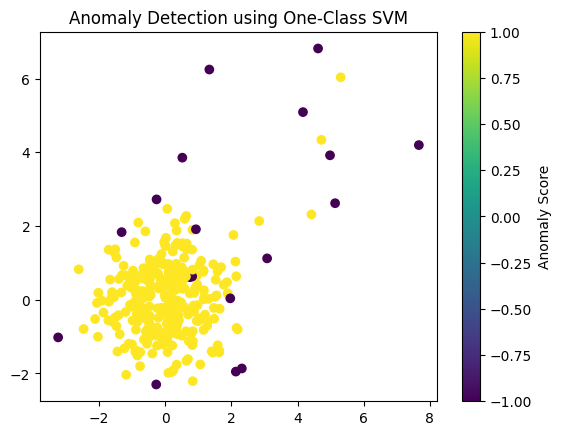

Detected anomalies: [ 89 104 110 131 142 149 151 196 230 235 239 250 300 302 304 305 307 308]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM

# Generate synthetic data with anomalies
np.random.seed(42)
normal_data = np.random.randn(300, 2)
anomalies = 4 + 1.5 * np.random.randn(10, 2)  # Generating anomalies far from normal data

# Combine normal and anomaly data
data = np.vstack([normal_data, anomalies])

# Initialize and fit the One-Class SVM model
clf = OneClassSVM(nu=0.05, kernel="rbf")  # Adjust the nu parameter as needed
clf.fit(data)

# Predict whether each data point is an anomaly (-1 for anomalies, 1 for normal data)
predictions = clf.predict(data)

# Visualize the results
plt.scatter(data[:, 0], data[:, 1], c=predictions, cmap='viridis')
plt.colorbar(label="Anomaly Score")
plt.title("Anomaly Detection using One-Class SVM")
plt.show()

# Identify anomalies (outliers)
anomalies_indices = np.where(predictions == -1)[0]
print("Detected anomalies:", anomalies_indices)